####**SKENARIO 1 SKRIPSI**

**SPLIT DATA 80:20**

**AUGMENTASI ON THE FLY**

**BATCH SIZE KLASIFIKASI 16 & 32**

**MENGGUNAKAN UNET**

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
import os

# Path folder ALPUKAT di Google Drive
project_path = '/content/drive/MyDrive/alpukat/dataset'
os.chdir(project_path)


# Verifikasi isi folder
!ls

best_class1_unet1.h5	images		      maskedunet2_train
best_class1_unet2.h5	images_aug	      masks
best_class2_rsunet7.h5	labels_converted.csv  masks_aug
best_class2_unet1.h5	labels.csv	      model.ipynb
best_model.keras	logs		      training_history1.json
best_rsunet5_model.h5	maskedrsunet7_test    training_history2.json
best_rsunet7_model.h5	maskedrsunet7_train   training_history5.json
best_unet1_model.h5	maskedunet1_train     training_history7.json
best_unet2_model.h5	maskedunet2_test


In [ ]:
pip install tensorflow

In [ ]:
import tensorflow as tf
from tensorflow.keras import layers, models
import tensorflow_datasets as tfds
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline
from sklearn.model_selection import train_test_split
import os
import glob
import random
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.losses import BinaryCrossentropy, SparseCategoricalCrossentropy
from tensorflow.keras.metrics import MeanIoU, SparseCategoricalAccuracy
from tensorflow.keras import layers, models, backend as K
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint
import json
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay, classification_report
import pandas as pd

In [ ]:
IMG_SIZE = 128
NUM_CLASSES = 3
BATCH_SIZE = 16
AUTOTUNE = tf.data.AUTOTUNE

In [ ]:
image_paths = sorted(glob.glob('/content/drive/MyDrive/alpukat/dataset/images_aug/*.*'))  # Untuk semua tipe gambar
mask_paths = sorted(glob.glob('/content/drive/MyDrive/alpukat/dataset/masks/*.*'))

print(len(image_paths))
print(len(mask_paths))

450
450


In [ ]:
labell_map = {
    'miki': 0,
    'aligator': 1,
    'marcus': 2
}

labels = [labell_map[os.path.basename(path).split('_')[0]] for path in image_paths]

In [ ]:
# Gunakan stratified split untuk menjaga proporsi kelas tetap
train_image_paths, test_image_paths, train_mask_paths, test_mask_paths, train_labels, test_labels = train_test_split(
    image_paths, mask_paths, labels,
    test_size=0.2,
    stratify=labels,   # menjaga distribusi kelas
    random_state=42
)


In [ ]:
from collections import Counter

# Hitung jumlah masing-masing label di data training
label_counts = Counter(train_labels)

# Tampilkan hasilnya
for label, count in label_counts.items():
    print(f"Label {label}: {count} data")


Label 1: 120 data
Label 2: 120 data
Label 0: 120 data


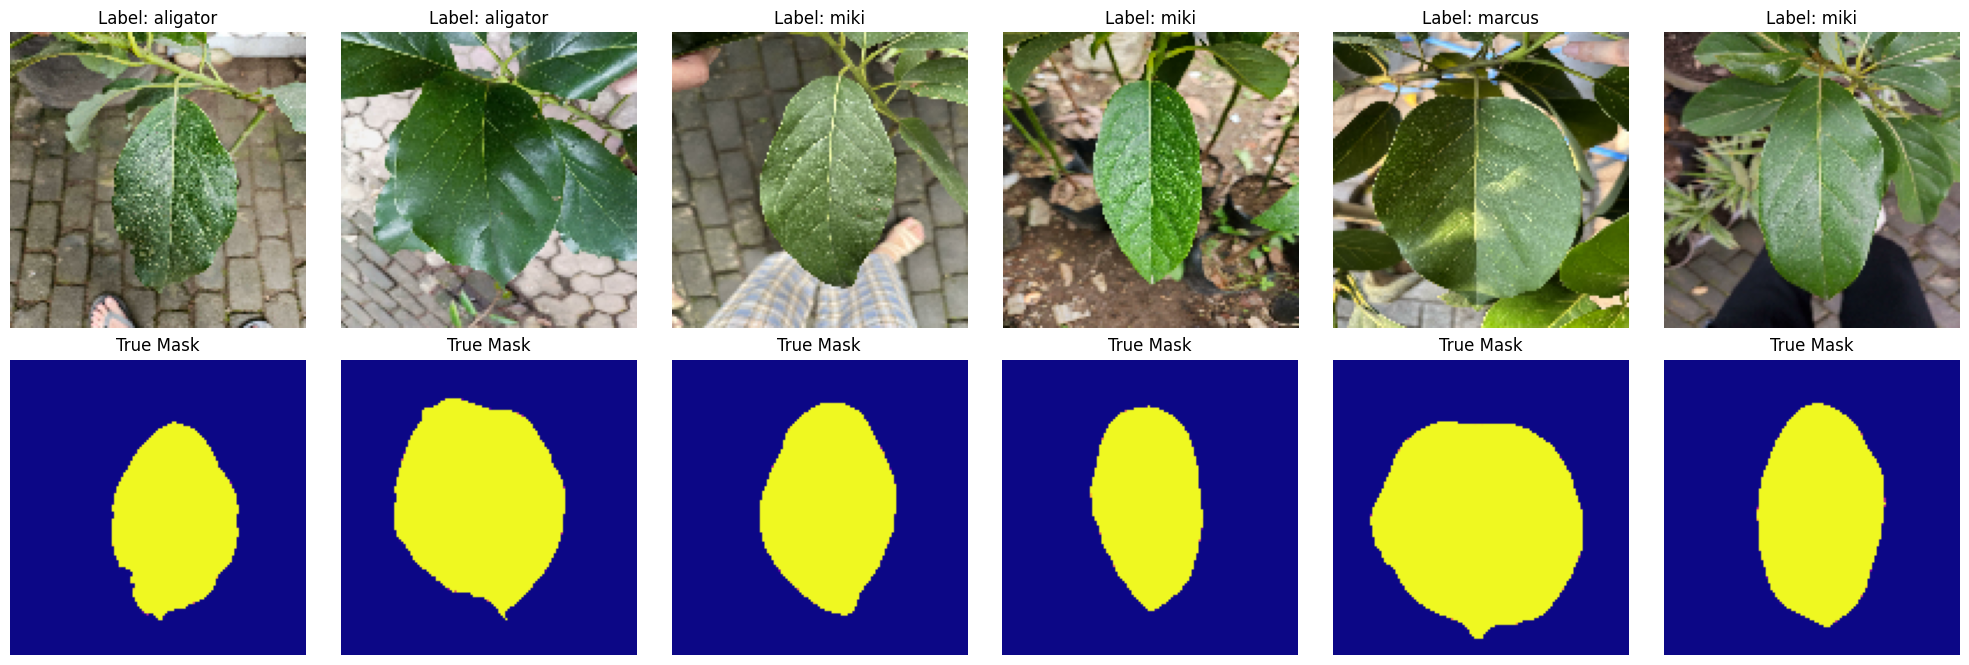

In [ ]:
# Sample 6 random image paths
sample_paths = random.sample(list(zip(image_paths, mask_paths)), 6)

plt.figure(figsize=(20, 10))

for i, (image_path, mask_path) in enumerate(sample_paths):
    # Ambil label dari nama file (misalnya, class diambil dari nama file gambar)
    class_name = os.path.basename(image_path).split('_')[0]
    label_name = class_name if class_name in label_map else 'unknown'

    # Load dan proses gambar
    img = tf.image.decode_jpeg(tf.io.read_file(image_path), channels=3)
    img = tf.image.resize(img, (128, 128)) / 255.0

    # Load dan proses mask
    mask = tf.image.decode_jpeg(tf.io.read_file(mask_path), channels=1)  # Mask grayscale
    mask = tf.image.resize(mask, (128, 128)) / 255.0  # Resize mask agar sesuai dengan gambar

    # Plot gambar asli
    plt.subplot(3, 6, i + 1)  # Baris 1, Gambar asli
    plt.imshow(img)
    plt.title(f"Label: {label_name}")
    plt.axis('off')

    # Plot true mask
    plt.subplot(3, 6, i + 7)  # Baris 2, True mask
    plt.imshow(mask, cmap='plasma')  # Gunakan colormap untuk visualisasi mask
    plt.title("True Mask")
    plt.axis('off')

plt.tight_layout()
plt.show()

##**DATA PREPROCESSINGG DAN AUGMENTASI**##

In [ ]:
import tensorflow as tf

# Fungsi preprocessing gambar dan mask
def load_and_preprocess_image(image_path, mask_path):
    image = tf.io.read_file(image_path)
    image = tf.image.decode_jpeg(image, channels=3)
    image = tf.image.resize(image, [128, 128])
    image = tf.cast(image, tf.float32) / 255.0

    mask = tf.io.read_file(mask_path)
    mask = tf.image.decode_png(mask, channels=1)
    mask = tf.image.resize(mask, [128, 128])
    mask = tf.cast(mask, tf.float32) / 255.0

    # Thresholding untuk membentuk mask biner
    mask = tf.where(mask > 0.5, 1.0, 0.0)

    return image, mask

# Fungsi preprocessing gambar dan mask
def load_and_preprocess_image(image_path, mask_path):
    image = tf.io.read_file(image_path)
    image = tf.image.decode_jpeg(image, channels=3)
    image = tf.image.resize(image, [256, 256])
    image = tf.cast(image, tf.float32) / 255.0

    mask = tf.io.read_file(mask_path)
    mask = tf.image.decode_png(mask, channels=1)
    mask = tf.image.resize(mask, [256, 256])
    mask = tf.cast(mask, tf.float32) / 255.0

    # Thresholding untuk membentuk mask biner
    mask = tf.where(mask > 0.5, 1.0, 0.0)

    return image, mask

In [ ]:
def augment_unet(image_path, mask_path):
    image, mask = load_and_preprocess_image(image_path, mask_path)

    # Augmentasi flip horizontal
    if tf.random.uniform(()) > 0.5:
        image = tf.image.flip_left_right(image)
        mask = tf.image.flip_left_right(mask)

    # Augmentasi flip vertikal
    if tf.random.uniform(()) > 0.5:
        image = tf.image.flip_up_down(image)
        mask = tf.image.flip_up_down(mask)

    # Augmentasi rotasi (90, 180, 270, 0)
    rotations = [0, 90, 180, 270]
    rotation_angle = tf.random.shuffle(rotations)[0]
    image = tf.image.rot90(image, k=rotation_angle // 90)
    mask = tf.image.rot90(mask, k=rotation_angle // 90)

    # Augmentasi transpose
    if tf.random.uniform(()) > 0.5:
        image = tf.image.transpose(image)
        mask = tf.image.transpose(mask)

    return image, mask

In [ ]:
train_unet_ds = tf.data.Dataset.from_tensor_slices((train_image_paths, train_mask_paths))
train_unet_ds = train_unet_ds.map(augment_unet, num_parallel_calls=AUTOTUNE)
train_unet_ds = train_unet_ds.shuffle(100).batch(BATCH_SIZE).prefetch(AUTOTUNE)

test_unet_ds = tf.data.Dataset.from_tensor_slices((test_image_paths, test_mask_paths))
test_unet_ds = test_unet_ds.map(load_and_preprocess_image, num_parallel_calls=AUTOTUNE)
test_unet_ds = test_unet_ds.batch(BATCH_SIZE).prefetch(AUTOTUNE)

NameError: name 'tf' is not defined

In [ ]:
# for image, mask in train_unet_ds.take(1):
#     print("Image shape:", image.shape)
#     print("Mask shape:", mask.shape)


Image shape: (16, 128, 128, 3)
Mask shape: (16, 128, 128, 1)


##**UNET MODEL**##

In [ ]:
def double_conv_block(x, n_filters):
    x = layers.Conv2D(n_filters, 3, padding='same', activation='relu', kernel_initializer='he_normal')(x)
    x = layers.Conv2D(n_filters, 3, padding='same', activation='relu', kernel_initializer='he_normal')(x)
    return x

def downsample_block(x, n_filters):
    f = double_conv_block(x, n_filters)
    p = layers.MaxPool2D(2)(f)
    p = layers.Dropout(0.3)(p)
    return f, p

def upsample_block(x, conv_features, n_filters):
    x = layers.Conv2DTranspose(n_filters, 3, 2, padding='same')(x)
    x = layers.concatenate([x, conv_features])
    x = layers.Dropout(0.3)(x)
    x = double_conv_block(x, n_filters)
    return x

In [ ]:
# --- U-Net Segmentasi ---
def build_unet():
    inputs = layers.Input(shape=(128, 128, 3))

    # Encoder
    f1, p1 = downsample_block(inputs, 64)
    f2, p2 = downsample_block(p1, 128)
    f3, p3 = downsample_block(p2, 256)
    f4, p4 = downsample_block(p3, 512)

    # Bottleneck
    bottleneck = double_conv_block(p4, 1024)

    # Decoder
    u6 = upsample_block(bottleneck, f4, 512)
    u7 = upsample_block(u6, f3, 256)
    u8 = upsample_block(u7, f2, 128)
    u9 = upsample_block(u8, f1, 64)

    # Output segmentasi
    segmentation_output = layers.Conv2D(1, (1, 1), activation='sigmoid', name='segmentation')(u9)

    model = models.Model(inputs=inputs, outputs=segmentation_output, name='U-Net-Segmenter')
    return model

In [ ]:
# Membuat model U-Net
unet_model = build_unet()

# Menampilkan summary dari model U-Net
unet_model.summary()

Model: "U-Net-Segmenter"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ input_layer         │ (None, 128, 128,  │          0 │ -                 │
│ (InputLayer)        │ 3)                │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d (Conv2D)     │ (None, 128, 128,  │      1,792 │ input_layer[0][0] │
│                     │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_1 (Conv2D)   │ (None, 128, 128,  │     36,928 │ conv2d[0][0]      │
│                     │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ max_pooling2d       │ (None, 64, 64,    │          0 │ conv2d_1[0][0]    │
│ (MaxPooling2D)      │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dropout (Dropout)   │ (None, 64, 64,    │          0 │ max_pooling2d[0]… │
│                     │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_2 (Conv2D)   │ (None, 64, 64,    │     73,856 │ dropout[0][0]     │
│                     │ 128)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_3 (Conv2D)   │ (None, 64, 64,    │    147,584 │ conv2d_2[0][0]    │
│                     │ 128)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ max_pooling2d_1     │ (None, 32, 32,    │          0 │ conv2d_3[0][0]    │
│ (MaxPooling2D)      │ 128)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dropout_1 (Dropout) │ (None, 32, 32,    │          0 │ max_pooling2d_1[… │
│                     │ 128)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_4 (Conv2D)   │ (None, 32, 32,    │    295,168 │ dropout_1[0][0]   │
│                     │ 256)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_5 (Conv2D)   │ (None, 32, 32,    │    590,080 │ conv2d_4[0][0]    │
│                     │ 256)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ max_pooling2d_2     │ (None, 16, 16,    │          0 │ conv2d_5[0][0]    │
│ (MaxPooling2D)      │ 256)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dropout_2 (Dropout) │ (None, 16, 16,    │          0 │ max_pooling2d_2[… │
│                     │ 256)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_6 (Conv2D)   │ (None, 16, 16,    │  1,180,160 │ dropout_2[0][0]   │
│                     │ 512)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_7 (Conv2D)   │ (None, 16, 16,    │  2,359,808 │ conv2d_6[0][0]    │
│                     │ 512)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ max_pooling2d_3     │ (None, 8, 8, 512) │          0 │ conv2d_7[0][0]    │
│ (MaxPooling2D)      │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dropout_3 (Dropout) │ (None, 8, 8, 512) │          0 │ max_pooling2d_3[

 Total params: 34,513,345 (131.66 MB)

 Trainable params: 34,513,345 (131.66 MB)

 Non-trainable params: 0 (0.00 B)

In [ ]:
def iou_metric(y_true, y_pred, smooth=1e-6):
    y_pred = tf.cast(y_pred > 0.5, tf.float32)  # Menggunakan threshold 0.5 untuk prediksi
    intersection = tf.reduce_sum(y_true * y_pred)
    union = tf.reduce_sum(y_true) + tf.reduce_sum(y_pred) - intersection
    iou = (intersection + smooth) / (union + smooth)
    return iou

In [ ]:
# Kompilasi model
unet_model.compile(
    optimizer='adam',
    loss='binary_crossentropy',  # Ganti dengan IoU loss jika sudah didefinisikan
    metrics=[iou_metric]
)

# Definisikan callbacks
callbacks = [
    EarlyStopping(monitor='val_loss', patience=10, restore_best_weights=True),
    ModelCheckpoint('best_unet1_model.h5', save_best_only=True, monitor='val_loss', mode='min')
]

In [ ]:
# Melatih model
history = unet_model.fit(
    train_unet_ds,
    epochs=100,
    validation_data=test_unet_ds,
    steps_per_epoch=len(train_unet_ds),
    validation_steps=len(test_unet_ds),
    callbacks=callbacks
)

Epoch 1/100
23/23 ━━━━━━━━━━━━━━━━━━━━ 0s 4s/step - iou_metric: 0.1161 - loss: 0.6060

23/23 ━━━━━━━━━━━━━━━━━━━━ 224s 6s/step - iou_metric: 0.1204 - loss: 0.6011 - val_iou_metric: 0.6000 - val_loss: 0.3239
Epoch 2/100
23/23 ━━━━━━━━━━━━━━━━━━━━ 88s 2s/step - iou_metric: 0.5030 - loss: 0.3542 - val_iou_metric: 0.5666 - val_loss: 0.3454
Epoch 3/100
23/23 ━━━━━━━━━━━━━━━━━━━━ 0s 1s/step - iou_metric: 0.5381 - loss: 0.3386

23/23 ━━━━━━━━━━━━━━━━━━━━ 49s 2s/step - iou_metric: 0.5389 - loss: 0.3384 - val_iou_metric: 0.6221 - val_loss: 0.2978
Epoch 4/100
23/23 ━━━━━━━━━━━━━━━━━━━━ 0s 1s/step - iou_metric: 0.5313 - loss: 0.3174

23/23 ━━━━━━━━━━━━━━━━━━━━ 80s 2s/step - iou_metric: 0.5326 - loss: 0.3196 - val_iou_metric: 0.6418 - val_loss: 0.2719
Epoch 5/100
23/23 ━━━━━━━━━━━━━━━━━━━━ 74s 1s/step - iou_metric: 0.3249 - loss: 0.4763 - val_iou_metric: 0.4905 - val_loss: 0.3353
Epoch 6/100
23/23 ━━━━━━━━━━━━━━━━━━━━ 41s 1s/step - iou_metric: 0.4395 - loss: 0.3450 - val_iou_metric: 0.5878 - val_loss: 0.2823
Epoch 7/100
23/23 ━━━━━━━━━━━━━━━━━━━━ 0s 1s/step - iou_metric: 0.5075 - loss: 0.3280

23/23 ━━━━━━━━━━━━━━━━━━━━ 54s 2s/step - iou_metric: 0.5079 - loss: 0.3280 - val_iou_metric: 0.6186 - val_loss: 0.2705
Epoch 8/100
23/23 ━━━━━━━━━━━━━━━━━━━━ 0s 1s/step - iou_metric: 0.5478 - loss: 0.3242

23/23 ━━━━━━━━━━━━━━━━━━━━ 76s 2s/step - iou_metric: 0.5480 - loss: 0.3241 - val_iou_metric: 0.6308 - val_loss: 0.2590
Epoch 9/100
23/23 ━━━━━━━━━━━━━━━━━━━━ 76s 1s/step - iou_metric: 0.6009 - loss: 0.2794 - val_iou_metric: 0.5582 - val_loss: 0.4023
Epoch 10/100
23/23 ━━━━━━━━━━━━━━━━━━━━ 84s 2s/step - iou_metric: 0.3697 - loss: 0.5253 - val_iou_metric: 0.6053 - val_loss: 0.2817
Epoch 11/100
23/23 ━━━━━━━━━━━━━━━━━━━━ 0s 1s/step - iou_metric: 0.5654 - loss: 0.3052

23/23 ━━━━━━━━━━━━━━━━━━━━ 94s 2s/step - iou_metric: 0.5669 - loss: 0.3043 - val_iou_metric: 0.7872 - val_loss: 0.1552
Epoch 12/100
23/23 ━━━━━━━━━━━━━━━━━━━━ 52s 2s/step - iou_metric: 0.6559 - loss: 0.2830 - val_iou_metric: 0.7838 - val_loss: 0.1730
Epoch 13/100
23/23 ━━━━━━━━━━━━━━━━━━━━ 72s 1s/step - iou_metric: 0.7596 - loss: 0.1821 - val_iou_metric: 0.8095 - val_loss: 0.1646
Epoch 14/100
23/23 ━━━━━━━━━━━━━━━━━━━━ 0s 953ms/step - iou_metric: 0.7903 - loss: 0.1655

23/23 ━━━━━━━━━━━━━━━━━━━━ 83s 2s/step - iou_metric: 0.7903 - loss: 0.1654 - val_iou_metric: 0.8256 - val_loss: 0.1302
Epoch 15/100
23/23 ━━━━━━━━━━━━━━━━━━━━ 0s 1s/step - iou_metric: 0.8009 - loss: 0.1493

23/23 ━━━━━━━━━━━━━━━━━━━━ 88s 2s/step - iou_metric: 0.8010 - loss: 0.1493 - val_iou_metric: 0.8342 - val_loss: 0.1238
Epoch 16/100
23/23 ━━━━━━━━━━━━━━━━━━━━ 50s 1s/step - iou_metric: 0.8084 - loss: 0.1401 - val_iou_metric: 0.8343 - val_loss: 0.1295
Epoch 17/100
23/23 ━━━━━━━━━━━━━━━━━━━━ 74s 2s/step - iou_metric: 0.8112 - loss: 0.1355 - val_iou_metric: 0.8254 - val_loss: 0.1404
Epoch 18/100
23/23 ━━━━━━━━━━━━━━━━━━━━ 0s 1s/step - iou_metric: 0.7973 - loss: 0.1472

23/23 ━━━━━━━━━━━━━━━━━━━━ 53s 2s/step - iou_metric: 0.7977 - loss: 0.1470 - val_iou_metric: 0.8420 - val_loss: 0.1150
Epoch 19/100
23/23 ━━━━━━━━━━━━━━━━━━━━ 0s 1s/step - iou_metric: 0.8119 - loss: 0.1353

23/23 ━━━━━━━━━━━━━━━━━━━━ 84s 2s/step - iou_metric: 0.8121 - loss: 0.1353 - val_iou_metric: 0.8499 - val_loss: 0.1117
Epoch 20/100
23/23 ━━━━━━━━━━━━━━━━━━━━ 51s 2s/step - iou_metric: 0.8266 - loss: 0.1257 - val_iou_metric: 0.8174 - val_loss: 0.1710
Epoch 21/100
23/23 ━━━━━━━━━━━━━━━━━━━━ 0s 983ms/step - iou_metric: 0.8202 - loss: 0.1335

23/23 ━━━━━━━━━━━━━━━━━━━━ 48s 2s/step - iou_metric: 0.8203 - loss: 0.1333 - val_iou_metric: 0.8616 - val_loss: 0.1046
Epoch 22/100
23/23 ━━━━━━━━━━━━━━━━━━━━ 0s 1s/step - iou_metric: 0.8361 - loss: 0.1156

23/23 ━━━━━━━━━━━━━━━━━━━━ 77s 2s/step - iou_metric: 0.8363 - loss: 0.1157 - val_iou_metric: 0.8646 - val_loss: 0.1035
Epoch 23/100
23/23 ━━━━━━━━━━━━━━━━━━━━ 0s 1s/step - iou_metric: 0.8448 - loss: 0.1119

23/23 ━━━━━━━━━━━━━━━━━━━━ 92s 2s/step - iou_metric: 0.8450 - loss: 0.1117 - val_iou_metric: 0.8803 - val_loss: 0.0957
Epoch 24/100
23/23 ━━━━━━━━━━━━━━━━━━━━ 0s 1s/step - iou_metric: 0.8651 - loss: 0.0978

23/23 ━━━━━━━━━━━━━━━━━━━━ 78s 2s/step - iou_metric: 0.8652 - loss: 0.0978 - val_iou_metric: 0.8740 - val_loss: 0.0892
Epoch 25/100
23/23 ━━━━━━━━━━━━━━━━━━━━ 0s 1s/step - iou_metric: 0.8641 - loss: 0.0971

23/23 ━━━━━━━━━━━━━━━━━━━━ 59s 2s/step - iou_metric: 0.8643 - loss: 0.0970 - val_iou_metric: 0.8908 - val_loss: 0.0773
Epoch 26/100
23/23 ━━━━━━━━━━━━━━━━━━━━ 0s 2s/step - iou_metric: 0.8708 - loss: 0.0931

23/23 ━━━━━━━━━━━━━━━━━━━━ 64s 3s/step - iou_metric: 0.8706 - loss: 0.0932 - val_iou_metric: 0.8934 - val_loss: 0.0760
Epoch 27/100
23/23 ━━━━━━━━━━━━━━━━━━━━ 0s 1s/step - iou_metric: 0.8824 - loss: 0.0848

23/23 ━━━━━━━━━━━━━━━━━━━━ 58s 2s/step - iou_metric: 0.8825 - loss: 0.0848 - val_iou_metric: 0.9051 - val_loss: 0.0663
Epoch 28/100
23/23 ━━━━━━━━━━━━━━━━━━━━ 0s 1s/step - iou_metric: 0.8894 - loss: 0.0785

23/23 ━━━━━━━━━━━━━━━━━━━━ 72s 2s/step - iou_metric: 0.8892 - loss: 0.0786 - val_iou_metric: 0.9103 - val_loss: 0.0629
Epoch 29/100
23/23 ━━━━━━━━━━━━━━━━━━━━ 73s 1s/step - iou_metric: 0.8862 - loss: 0.0800 - val_iou_metric: 0.8786 - val_loss: 0.0876
Epoch 30/100
23/23 ━━━━━━━━━━━━━━━━━━━━ 38s 1s/step - iou_metric: 0.8803 - loss: 0.0836 - val_iou_metric: 0.9025 - val_loss: 0.0682
Epoch 31/100
23/23 ━━━━━━━━━━━━━━━━━━━━ 38s 1s/step - iou_metric: 0.8979 - loss: 0.0711 - val_iou_metric: 0.9027 - val_loss: 0.0727
Epoch 32/100
23/23 ━━━━━━━━━━━━━━━━━━━━ 0s 937ms/step - iou_metric: 0.8965 - loss: 0.0709

23/23 ━━━━━━━━━━━━━━━━━━━━ 46s 2s/step - iou_metric: 0.8965 - loss: 0.0710 - val_iou_metric: 0.9151 - val_loss: 0.0582
Epoch 33/100
23/23 ━━━━━━━━━━━━━━━━━━━━ 0s 1s/step - iou_metric: 0.8968 - loss: 0.0722

23/23 ━━━━━━━━━━━━━━━━━━━━ 95s 2s/step - iou_metric: 0.8969 - loss: 0.0721 - val_iou_metric: 0.9187 - val_loss: 0.0566
Epoch 34/100
23/23 ━━━━━━━━━━━━━━━━━━━━ 66s 1s/step - iou_metric: 0.9007 - loss: 0.0677 - val_iou_metric: 0.9131 - val_loss: 0.0595
Epoch 35/100
23/23 ━━━━━━━━━━━━━━━━━━━━ 0s 1s/step - iou_metric: 0.9006 - loss: 0.0687

23/23 ━━━━━━━━━━━━━━━━━━━━ 48s 2s/step - iou_metric: 0.9008 - loss: 0.0687 - val_iou_metric: 0.9214 - val_loss: 0.0549
Epoch 36/100
23/23 ━━━━━━━━━━━━━━━━━━━━ 52s 2s/step - iou_metric: 0.9060 - loss: 0.0647 - val_iou_metric: 0.9026 - val_loss: 0.0706
Epoch 37/100
23/23 ━━━━━━━━━━━━━━━━━━━━ 40s 1s/step - iou_metric: 0.9053 - loss: 0.0653 - val_iou_metric: 0.9160 - val_loss: 0.0558
Epoch 38/100
23/23 ━━━━━━━━━━━━━━━━━━━━ 0s 1s/step - iou_metric: 0.9158 - loss: 0.0610

23/23 ━━━━━━━━━━━━━━━━━━━━ 45s 2s/step - iou_metric: 0.9154 - loss: 0.0612 - val_iou_metric: 0.9202 - val_loss: 0.0548
Epoch 39/100
23/23 ━━━━━━━━━━━━━━━━━━━━ 0s 1s/step - iou_metric: 0.9056 - loss: 0.0661

23/23 ━━━━━━━━━━━━━━━━━━━━ 55s 2s/step - iou_metric: 0.9056 - loss: 0.0662 - val_iou_metric: 0.9239 - val_loss: 0.0511
Epoch 40/100
23/23 ━━━━━━━━━━━━━━━━━━━━ 69s 1s/step - iou_metric: 0.9129 - loss: 0.0597 - val_iou_metric: 0.9133 - val_loss: 0.0633
Epoch 41/100
23/23 ━━━━━━━━━━━━━━━━━━━━ 0s 1s/step - iou_metric: 0.9078 - loss: 0.0647

23/23 ━━━━━━━━━━━━━━━━━━━━ 89s 2s/step - iou_metric: 0.9080 - loss: 0.0646 - val_iou_metric: 0.9258 - val_loss: 0.0505
Epoch 42/100
23/23 ━━━━━━━━━━━━━━━━━━━━ 0s 955ms/step - iou_metric: 0.9223 - loss: 0.0544

23/23 ━━━━━━━━━━━━━━━━━━━━ 81s 2s/step - iou_metric: 0.9223 - loss: 0.0544 - val_iou_metric: 0.9280 - val_loss: 0.0494
Epoch 43/100
23/23 ━━━━━━━━━━━━━━━━━━━━ 0s 971ms/step - iou_metric: 0.9239 - loss: 0.0516

23/23 ━━━━━━━━━━━━━━━━━━━━ 80s 2s/step - iou_metric: 0.9240 - loss: 0.0516 - val_iou_metric: 0.9339 - val_loss: 0.0437
Epoch 44/100
23/23 ━━━━━━━━━━━━━━━━━━━━ 50s 1s/step - iou_metric: 0.9260 - loss: 0.0503 - val_iou_metric: 0.9213 - val_loss: 0.0563
Epoch 45/100
23/23 ━━━━━━━━━━━━━━━━━━━━ 0s 996ms/step - iou_metric: 0.9268 - loss: 0.0491

23/23 ━━━━━━━━━━━━━━━━━━━━ 79s 2s/step - iou_metric: 0.9268 - loss: 0.0491 - val_iou_metric: 0.9410 - val_loss: 0.0402
Epoch 46/100
23/23 ━━━━━━━━━━━━━━━━━━━━ 76s 1s/step - iou_metric: 0.9245 - loss: 0.0534 - val_iou_metric: 0.9399 - val_loss: 0.0422
Epoch 47/100
23/23 ━━━━━━━━━━━━━━━━━━━━ 83s 1s/step - iou_metric: 0.9319 - loss: 0.0463 - val_iou_metric: 0.9235 - val_loss: 0.0525
Epoch 48/100
23/23 ━━━━━━━━━━━━━━━━━━━━ 43s 2s/step - iou_metric: 0.9345 - loss: 0.0446 - val_iou_metric: 0.9118 - val_loss: 0.0741
Epoch 49/100
23/23 ━━━━━━━━━━━━━━━━━━━━ 81s 1s/step - iou_metric: 0.9263 - loss: 0.0512 - val_iou_metric: 0.9353 - val_loss: 0.0449
Epoch 50/100
23/23 ━━━━━━━━━━━━━━━━━━━━ 83s 1s/step - iou_metric: 0.9361 - loss: 0.0432 - val_iou_metric: 0.9314 - val_loss: 0.0469
Epoch 51/100
23/23 ━━━━━━━━━━━━━━━━━━━━ 81s 2s/step - iou_metric: 0.9306 - loss: 0.0476 - val_iou_metric: 0.9407 - val_loss: 0.0406
Epoch 52/100
23/23 ━━━━━━━━━━━━━━━━━━━━ 82s 1s/step - iou_metric: 0.9288 - loss: 0.0476 -

23/23 ━━━━━━━━━━━━━━━━━━━━ 87s 2s/step - iou_metric: 0.9430 - loss: 0.0383 - val_iou_metric: 0.9401 - val_loss: 0.0398
Epoch 55/100
23/23 ━━━━━━━━━━━━━━━━━━━━ 0s 1s/step - iou_metric: 0.9373 - loss: 0.0420

23/23 ━━━━━━━━━━━━━━━━━━━━ 55s 2s/step - iou_metric: 0.9374 - loss: 0.0420 - val_iou_metric: 0.9454 - val_loss: 0.0372
Epoch 56/100
23/23 ━━━━━━━━━━━━━━━━━━━━ 0s 1s/step - iou_metric: 0.9467 - loss: 0.0359

23/23 ━━━━━━━━━━━━━━━━━━━━ 78s 2s/step - iou_metric: 0.9466 - loss: 0.0359 - val_iou_metric: 0.9448 - val_loss: 0.0367
Epoch 57/100
23/23 ━━━━━━━━━━━━━━━━━━━━ 53s 2s/step - iou_metric: 0.9436 - loss: 0.0369 - val_iou_metric: 0.9145 - val_loss: 0.0738
Epoch 58/100
23/23 ━━━━━━━━━━━━━━━━━━━━ 41s 1s/step - iou_metric: 0.9313 - loss: 0.0508 - val_iou_metric: 0.9437 - val_loss: 0.0372
Epoch 59/100
23/23 ━━━━━━━━━━━━━━━━━━━━ 0s 1s/step - iou_metric: 0.9400 - loss: 0.0412

23/23 ━━━━━━━━━━━━━━━━━━━━ 53s 2s/step - iou_metric: 0.9401 - loss: 0.0411 - val_iou_metric: 0.9492 - val_loss: 0.0355
Epoch 60/100
23/23 ━━━━━━━━━━━━━━━━━━━━ 51s 2s/step - iou_metric: 0.9471 - loss: 0.0359 - val_iou_metric: 0.9320 - val_loss: 0.0514
Epoch 61/100
23/23 ━━━━━━━━━━━━━━━━━━━━ 43s 2s/step - iou_metric: 0.9397 - loss: 0.0413 - val_iou_metric: 0.9262 - val_loss: 0.0519
Epoch 62/100
23/23 ━━━━━━━━━━━━━━━━━━━━ 79s 1s/step - iou_metric: 0.9297 - loss: 0.0485 - val_iou_metric: 0.9369 - val_loss: 0.0467
Epoch 63/100
23/23 ━━━━━━━━━━━━━━━━━━━━ 0s 973ms/step - iou_metric: 0.9457 - loss: 0.0358

23/23 ━━━━━━━━━━━━━━━━━━━━ 48s 2s/step - iou_metric: 0.9456 - loss: 0.0359 - val_iou_metric: 0.9536 - val_loss: 0.0331
Epoch 64/100
23/23 ━━━━━━━━━━━━━━━━━━━━ 77s 1s/step - iou_metric: 0.9343 - loss: 0.0456 - val_iou_metric: 0.9382 - val_loss: 0.0414
Epoch 65/100
23/23 ━━━━━━━━━━━━━━━━━━━━ 0s 1s/step - iou_metric: 0.9440 - loss: 0.0370

23/23 ━━━━━━━━━━━━━━━━━━━━ 86s 2s/step - iou_metric: 0.9441 - loss: 0.0370 - val_iou_metric: 0.9565 - val_loss: 0.0289
Epoch 66/100
23/23 ━━━━━━━━━━━━━━━━━━━━ 76s 1s/step - iou_metric: 0.9513 - loss: 0.0333 - val_iou_metric: 0.9544 - val_loss: 0.0306
Epoch 67/100
23/23 ━━━━━━━━━━━━━━━━━━━━ 39s 1s/step - iou_metric: 0.9525 - loss: 0.0315 - val_iou_metric: 0.9521 - val_loss: 0.0324
Epoch 68/100
23/23 ━━━━━━━━━━━━━━━━━━━━ 39s 1s/step - iou_metric: 0.9474 - loss: 0.0344 - val_iou_metric: 0.9534 - val_loss: 0.0302
Epoch 69/100
23/23 ━━━━━━━━━━━━━━━━━━━━ 43s 1s/step - iou_metric: 0.9564 - loss: 0.0290 - val_iou_metric: 0.9546 - val_loss: 0.0318
Epoch 70/100
23/23 ━━━━━━━━━━━━━━━━━━━━ 81s 1s/step - iou_metric: 0.9541 - loss: 0.0300 - val_iou_metric: 0.9500 - val_loss: 0.0387
Epoch 71/100
23/23 ━━━━━━━━━━━━━━━━━━━━ 0s 1s/step - iou_metric: 0.9555 - loss: 0.0306

23/23 ━━━━━━━━━━━━━━━━━━━━ 50s 2s/step - iou_metric: 0.9554 - loss: 0.0307 - val_iou_metric: 0.9584 - val_loss: 0.0277
Epoch 72/100
23/23 ━━━━━━━━━━━━━━━━━━━━ 0s 1s/step - iou_metric: 0.9528 - loss: 0.0301

23/23 ━━━━━━━━━━━━━━━━━━━━ 61s 2s/step - iou_metric: 0.9529 - loss: 0.0301 - val_iou_metric: 0.9614 - val_loss: 0.0261
Epoch 73/100
23/23 ━━━━━━━━━━━━━━━━━━━━ 0s 968ms/step - iou_metric: 0.9568 - loss: 0.0286

23/23 ━━━━━━━━━━━━━━━━━━━━ 65s 2s/step - iou_metric: 0.9568 - loss: 0.0286 - val_iou_metric: 0.9623 - val_loss: 0.0255
Epoch 74/100
23/23 ━━━━━━━━━━━━━━━━━━━━ 0s 979ms/step - iou_metric: 0.9594 - loss: 0.0263

23/23 ━━━━━━━━━━━━━━━━━━━━ 87s 2s/step - iou_metric: 0.9594 - loss: 0.0263 - val_iou_metric: 0.9627 - val_loss: 0.0253
Epoch 75/100
23/23 ━━━━━━━━━━━━━━━━━━━━ 75s 1s/step - iou_metric: 0.9640 - loss: 0.0238 - val_iou_metric: 0.9578 - val_loss: 0.0279
Epoch 76/100
23/23 ━━━━━━━━━━━━━━━━━━━━ 82s 1s/step - iou_metric: 0.9583 - loss: 0.0268 - val_iou_metric: 0.9541 - val_loss: 0.0332
Epoch 77/100
23/23 ━━━━━━━━━━━━━━━━━━━━ 41s 1s/step - iou_metric: 0.9580 - loss: 0.0282 - val_iou_metric: 0.9530 - val_loss: 0.0348
Epoch 78/100
23/23 ━━━━━━━━━━━━━━━━━━━━ 81s 1s/step - iou_metric: 0.9567 - loss: 0.0294 - val_iou_metric: 0.9592 - val_loss: 0.0278
Epoch 79/100
23/23 ━━━━━━━━━━━━━━━━━━━━ 39s 1s/step - iou_metric: 0.9601 - loss: 0.0257 - val_iou_metric: 0.9619 - val_loss: 0.0257
Epoch 80/100
23/23 ━━━━━━━━━━━━━━━━━━━━ 0s 985ms/step - iou_metric: 0.9625 - loss: 0.0246

23/23 ━━━━━━━━━━━━━━━━━━━━ 46s 2s/step - iou_metric: 0.9625 - loss: 0.0247 - val_iou_metric: 0.9662 - val_loss: 0.0232
Epoch 81/100
23/23 ━━━━━━━━━━━━━━━━━━━━ 79s 2s/step - iou_metric: 0.9617 - loss: 0.0249 - val_iou_metric: 0.9569 - val_loss: 0.0313
Epoch 82/100
23/23 ━━━━━━━━━━━━━━━━━━━━ 81s 2s/step - iou_metric: 0.9555 - loss: 0.0286 - val_iou_metric: 0.9573 - val_loss: 0.0297
Epoch 83/100
23/23 ━━━━━━━━━━━━━━━━━━━━ 42s 2s/step - iou_metric: 0.9566 - loss: 0.0292 - val_iou_metric: 0.9634 - val_loss: 0.0237
Epoch 84/100
23/23 ━━━━━━━━━━━━━━━━━━━━ 84s 2s/step - iou_metric: 0.9613 - loss: 0.0251 - val_iou_metric: 0.9624 - val_loss: 0.0270
Epoch 85/100
23/23 ━━━━━━━━━━━━━━━━━━━━ 81s 2s/step - iou_metric: 0.9613 - loss: 0.0247 - val_iou_metric: 0.9643 - val_loss: 0.0251
Epoch 86/100
23/23 ━━━━━━━━━━━━━━━━━━━━ 41s 1s/step - iou_metric: 0.9642 - loss: 0.0230 - val_iou_metric: 0.9643 - val_loss: 0.0249
Epoch 87/100
23/23 ━━━━━━━━━━━━━━━━━━━━ 0s 1s/step - iou_metric: 0.9653 - loss: 0.0230

23/23 ━━━━━━━━━━━━━━━━━━━━ 48s 2s/step - iou_metric: 0.9654 - loss: 0.0229 - val_iou_metric: 0.9681 - val_loss: 0.0223
Epoch 88/100
23/23 ━━━━━━━━━━━━━━━━━━━━ 77s 2s/step - iou_metric: 0.9679 - loss: 0.0203 - val_iou_metric: 0.9655 - val_loss: 0.0255
Epoch 89/100
23/23 ━━━━━━━━━━━━━━━━━━━━ 81s 2s/step - iou_metric: 0.9649 - loss: 0.0234 - val_iou_metric: 0.9645 - val_loss: 0.0256
Epoch 90/100
23/23 ━━━━━━━━━━━━━━━━━━━━ 0s 1s/step - iou_metric: 0.9563 - loss: 0.0277

23/23 ━━━━━━━━━━━━━━━━━━━━ 48s 2s/step - iou_metric: 0.9565 - loss: 0.0277 - val_iou_metric: 0.9689 - val_loss: 0.0209
Epoch 91/100
23/23 ━━━━━━━━━━━━━━━━━━━━ 52s 2s/step - iou_metric: 0.9654 - loss: 0.0225 - val_iou_metric: 0.9683 - val_loss: 0.0222
Epoch 92/100
23/23 ━━━━━━━━━━━━━━━━━━━━ 70s 1s/step - iou_metric: 0.9660 - loss: 0.0216 - val_iou_metric: 0.9599 - val_loss: 0.0292
Epoch 93/100
23/23 ━━━━━━━━━━━━━━━━━━━━ 42s 1s/step - iou_metric: 0.9669 - loss: 0.0216 - val_iou_metric: 0.9595 - val_loss: 0.0321
Epoch 94/100
23/23 ━━━━━━━━━━━━━━━━━━━━ 39s 1s/step - iou_metric: 0.9622 - loss: 0.0257 - val_iou_metric: 0.9509 - val_loss: 0.0353
Epoch 95/100
23/23 ━━━━━━━━━━━━━━━━━━━━ 41s 1s/step - iou_metric: 0.4843 - loss: 10.3714 - val_iou_metric: 0.2140 - val_loss: 0.6141
Epoch 96/100
23/23 ━━━━━━━━━━━━━━━━━━━━ 43s 1s/step - iou_metric: 0.1127 - loss: 0.5457 - val_iou_metric: 0.4729 - val_loss: 0.4593
Epoch 97/100
23/23 ━━━━━━━━━━━━━━━━━━━━ 42s 1s/step - iou_metric: 0.2863 - loss: 0.4164 

In [ ]:
# Simpan history ke file JSON
history_dict = history.history
with open('training_history1.json', 'w') as json_file:
    json.dump(history_dict, json_file)

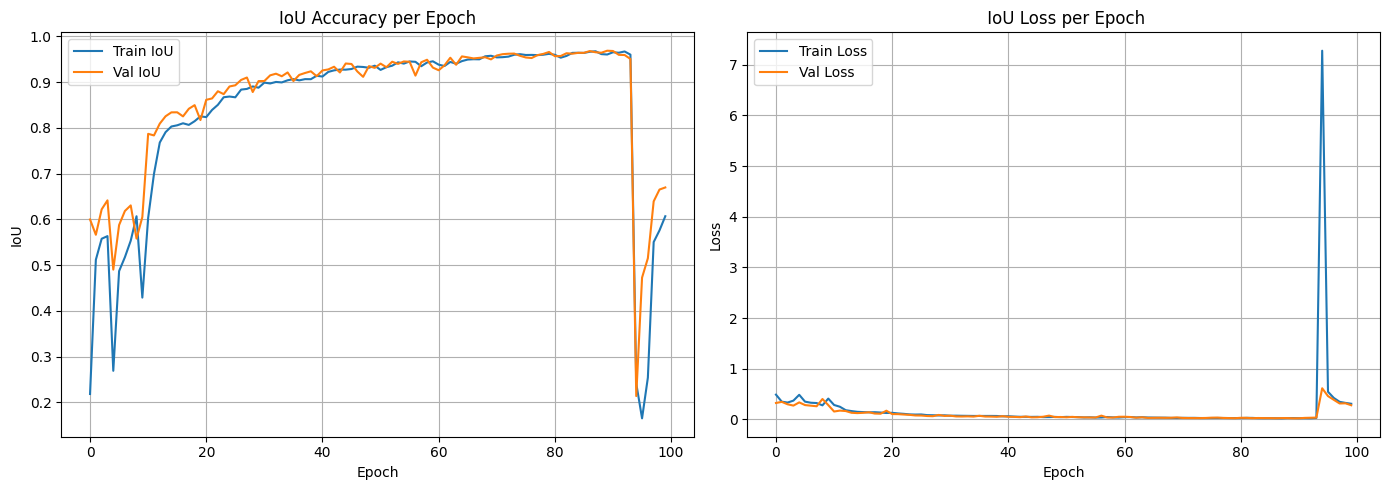

In [ ]:
# Ekstrak data dari history
history_dict = history.history

# Buat plot
plt.figure(figsize=(14, 5))

# Plot IoU (iou_metric)
plt.subplot(1, 2, 1)
plt.plot(history_dict['iou_metric'], label='Train IoU')
plt.plot(history_dict['val_iou_metric'], label='Val IoU')
plt.title('IoU Accuracy per Epoch')
plt.xlabel('Epoch')
plt.ylabel('IoU')
plt.legend()
plt.grid(True)

# Plot Loss
plt.subplot(1, 2, 2)
plt.plot(history_dict['loss'], label='Train Loss')
plt.plot(history_dict['val_loss'], label='Val Loss')
plt.title(' IoU Loss per Epoch')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()
plt.grid(True)

plt.tight_layout()
plt.show()


1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 1s/step


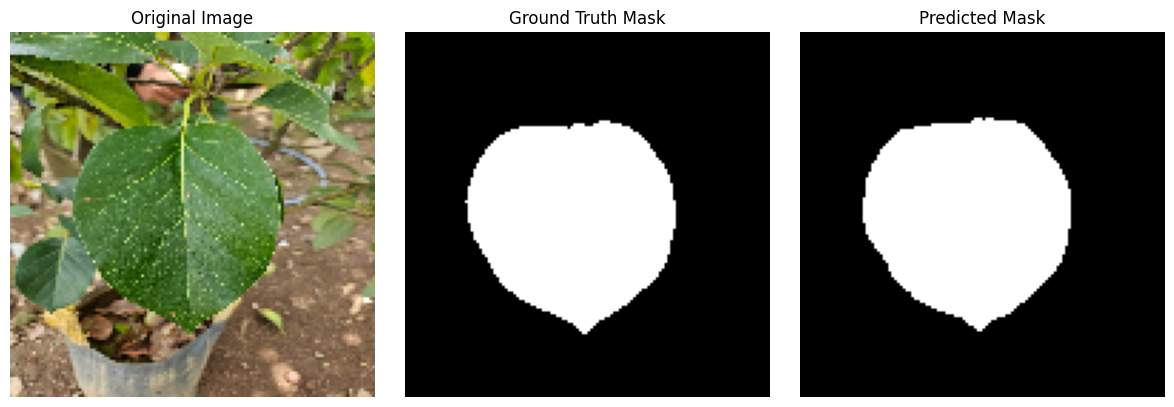

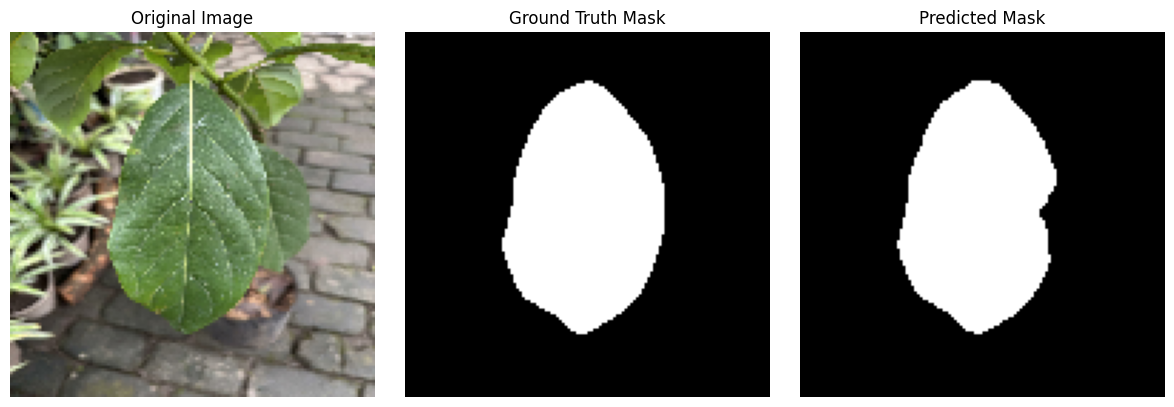

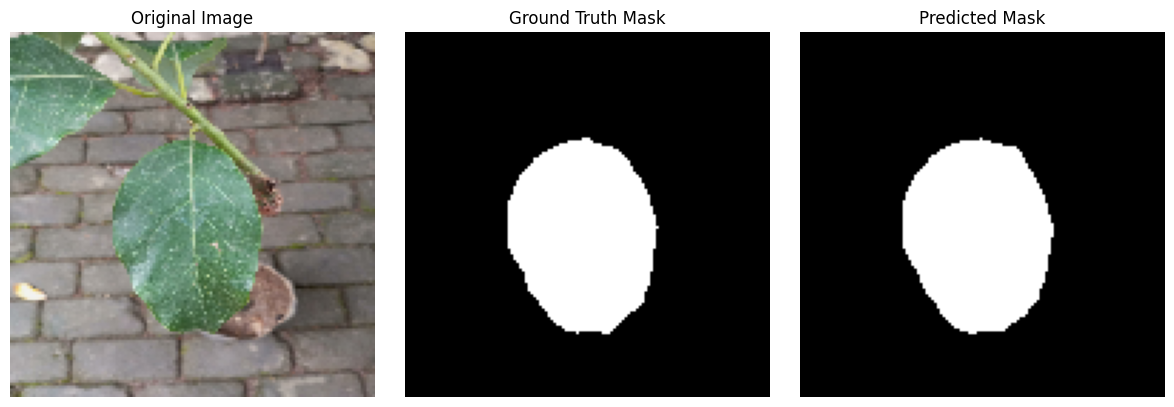

In [ ]:
import matplotlib.pyplot as plt
import numpy as np

def display_sample_prediction(unet_model, dataset, num_samples=3):
    for images, masks in dataset.take(1):
        preds = unet_model.predict(images)
        preds = (preds > 0.5).astype(np.uint8)  # Threshold prediksi

        for i in range(num_samples):
            image = images[i].numpy()
            gt_mask = masks[i].numpy().squeeze()
            pred_mask = preds[i].squeeze()

            plt.figure(figsize=(12, 4))

            # Gambar asli
            plt.subplot(1, 3, 1)
            plt.imshow(image)
            plt.title("Original Image")
            plt.axis('off')

            # Ground truth mask
            plt.subplot(1, 3, 2)
            plt.imshow(gt_mask, cmap='gray')
            plt.title("Ground Truth Mask")
            plt.axis('off')

            # Predicted mask
            plt.subplot(1, 3, 3)
            plt.imshow(pred_mask, cmap='gray')
            plt.title("Predicted Mask")
            plt.axis('off')

            plt.tight_layout()
            plt.show()

display_sample_prediction(unet_model, test_unet_ds, num_samples=3)

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 173ms/step


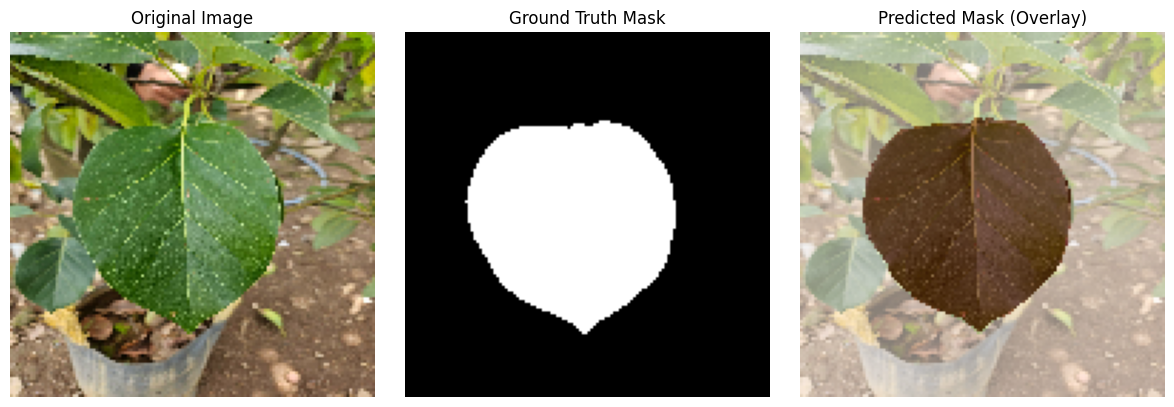

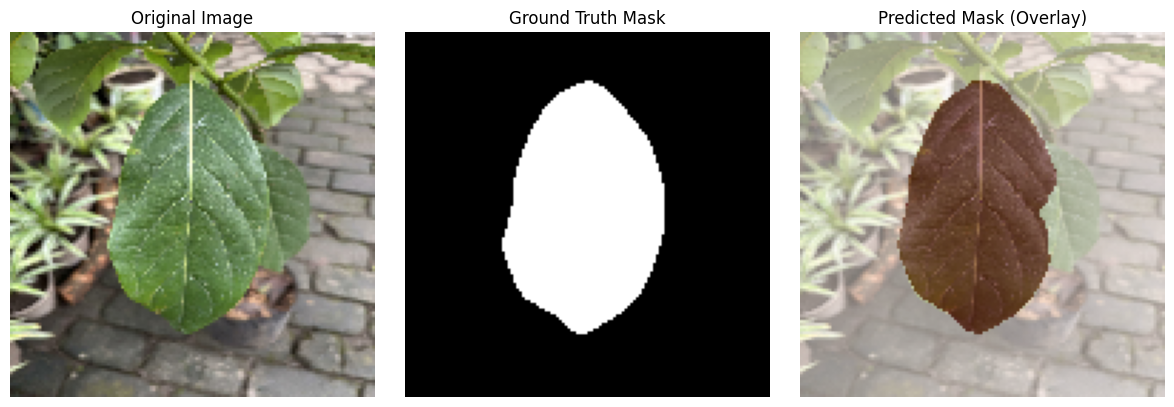

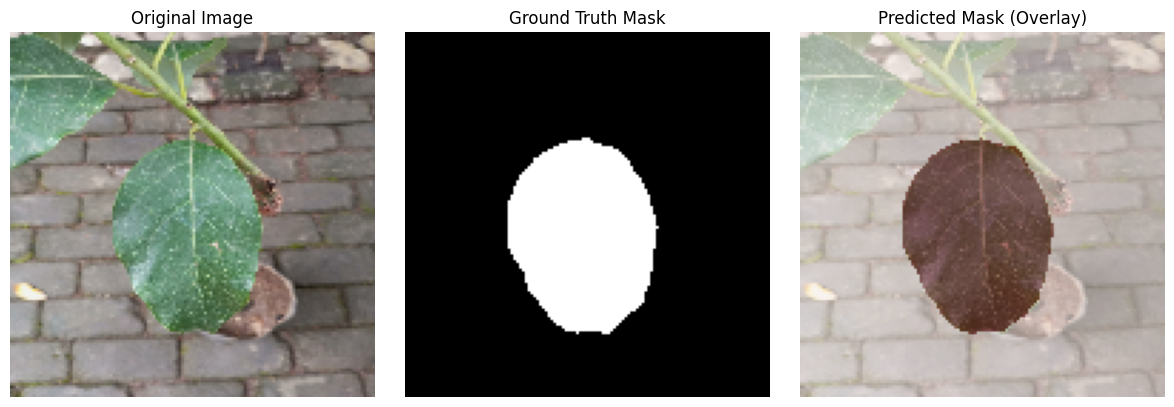

In [ ]:
def display_sample_prediction(unet_model, dataset, num_samples=3):
    for images, masks in dataset.take(1):
        preds = unet_model.predict(images)
        preds = (preds > 0.5).astype(np.uint8)  # Threshold prediksi

        for i in range(num_samples):
            image = images[i].numpy()
            gt_mask = masks[i].numpy().squeeze()
            pred_mask = preds[i].squeeze()

            plt.figure(figsize=(12, 4))

            # Gambar asli
            plt.subplot(1, 3, 1)
            plt.imshow(image)
            plt.title("Original Image")
            plt.axis('off')

            # Ground truth mask
            plt.subplot(1, 3, 2)
            plt.imshow(gt_mask, cmap='gray')
            plt.title("Ground Truth Mask")
            plt.axis('off')

            # Predicted mask overlay dengan gambar asli
            plt.subplot(1, 3, 3)
            plt.imshow(image)
            plt.imshow(pred_mask, cmap='Reds', alpha=0.5)  # Overlay mask
            plt.title("Predicted Mask (Overlay)")
            plt.axis('off')

            plt.tight_layout()
            plt.show()

display_sample_prediction(unet_model, test_unet_ds, num_samples=3)

##**CLASSIFICATION MODEL**##

In [ ]:
# from tensorflow.keras.models import load_model

# # Load model U-Net dari checkpoint
# unet_model = load_model('/content/drive/MyDrive/alpukat/dataset/best_unet1_model.h5')

In [ ]:
# Gunakan lowercase untuk key
keys_tensor = tf.constant([k.lower() for k in labell_map.keys()])
vals_tensor = tf.constant(list(labell_map.values()), dtype=tf.int32)
table_init = tf.lookup.KeyValueTensorInitializer(keys_tensor, vals_tensor)
label_table = tf.lookup.StaticHashTable(table_init, default_value=-1)

def extract_label_from_filename_tf(filename):
    filename = tf.strings.lower(filename)
    label_str = tf.strings.split(filename, '_')[0]
    return label_table.lookup(label_str)

In [ ]:
def apply_unet_segmentation_to_image(image, segmentation_output, threshold=0.5):
    if isinstance(image, tf.Tensor):
        image = tf.cast(image, tf.float32)

    if image.shape[-1] != 3:
        raise ValueError(f"Image must have 3 channels. Got shape: {image.shape}")

    binary_mask = tf.cast(segmentation_output > threshold, tf.float32)
    if len(binary_mask.shape) == 2:
        binary_mask = tf.expand_dims(binary_mask, axis=-1)
    binary_mask_rgb = tf.repeat(binary_mask, repeats=3, axis=-1)

    if binary_mask_rgb.shape != image.shape:
        binary_mask_rgb = tf.image.resize(binary_mask_rgb, image.shape[:2])

    masked_image = image * binary_mask_rgb
    return masked_image

In [ ]:
from tqdm import tqdm

def save_masked_dataset(image_paths, unet_model, save_dir, image_size=(128, 128)):
    os.makedirs(save_dir, exist_ok=True)
    for path in tqdm(image_paths):
        # Load & resize
        image_raw = tf.io.read_file(path)
        image = tf.image.decode_jpeg(image_raw, channels=3)
        image = tf.image.resize(image, image_size)
        image = tf.cast(image, tf.float32) / 255.0

        # Predict mask
        pred = unet_model(tf.expand_dims(image, 0), training=False)
        pred = tf.squeeze(pred, axis=0)

        # Apply mask
        masked_image = apply_unet_segmentation_to_image(image, pred)

        # Simpan hasil
        fname = os.path.basename(path)
        save_path = os.path.join(save_dir, fname)
        masked_uint8 = tf.image.convert_image_dtype(masked_image, tf.uint8)
        encoded = tf.image.encode_jpeg(masked_uint8)
        tf.io.write_file(save_path, encoded)


In [ ]:
save_masked_dataset(train_image_paths, unet_model, "maskedunet1_train")
save_masked_dataset(test_image_paths, unet_model, "maskedunet1_test")

100%|██████████| 90/90 [00:16<00:00,  5.39it/s]


In [ ]:
def load_masked_dataset(image_dir):
    image_paths = tf.io.gfile.glob(os.path.join(image_dir, '*.jpg'))
    ds = tf.data.Dataset.from_tensor_slices(image_paths)

    def load_image_and_label(path):
        image_raw = tf.io.read_file(path)
        image = tf.image.decode_jpeg(image_raw, channels=3)
        image = tf.image.resize(image, [128, 128])
        image = tf.cast(image, tf.float32) / 255.0

        filename = tf.strings.split(path, '/')[-1]
        label = extract_label_from_filename_tf(filename)
        return image, label

    return ds.map(load_image_and_label, num_parallel_calls=tf.data.AUTOTUNE)


In [ ]:
# Batching dan prefetch
classification_train_ds_16 = load_masked_dataset("maskedunet1_train").batch(16).prefetch(tf.data.AUTOTUNE)
classification_test_ds_16 = load_masked_dataset("maskedunet1_test").batch(16).prefetch(tf.data.AUTOTUNE)

classification_train_ds_32 = load_masked_dataset("maskedunet1_train").batch(32).prefetch(tf.data.AUTOTUNE)
classification_test_ds_32 = load_masked_dataset("maskedunet1_test").batch(32).prefetch(tf.data.AUTOTUNE)

In [ ]:
def classification_model(input_shape=(128, 128, 3)):
    inputs = tf.keras.layers.Input(input_shape)

    x = tf.keras.layers.Conv2D(32, (3, 3), activation='relu', padding='same')(inputs)
    x = tf.keras.layers.MaxPooling2D((2, 2))(x)

    x = tf.keras.layers.Conv2D(64, (3, 3), activation='relu', padding='same')(x)
    x = tf.keras.layers.MaxPooling2D((2, 2))(x)

    x = tf.keras.layers.Conv2D(128, (3, 3), activation='relu', padding='same')(x)
    x = tf.keras.layers.GlobalAveragePooling2D()(x)

    x = tf.keras.layers.Dense(64, activation='relu')(x)
    x = tf.keras.layers.Dropout(0.5)(x)

    outputs = tf.keras.layers.Dense(3, activation='softmax')(x)

    return tf.keras.models.Model(inputs, outputs)


In [ ]:
clf_model_class1 = classification_model()
clf_model_class2 = classification_model()

clf_model_class1.summary()

Model: "functional_8"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ input_layer_9 (InputLayer)      │ (None, 128, 128, 3)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_42 (Conv2D)              │ (None, 128, 128, 32)   │           896 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_20 (MaxPooling2D) │ (None, 64, 64, 32)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_43 (Conv2D)              │ (None, 64, 64, 64)     │        18,496 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_21 (MaxPooling2D) │ (None, 32, 32, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_44 (Conv2D)              │ (None, 32, 32, 128)    │        73,856 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ global_average_pooling2d_8      │ (None, 128)            │             0 │
│ (GlobalAveragePooling2D)        │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_16 (Dense)                │ (None, 64)             │         8,256 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_16 (Dropout)            │ (None, 64)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_17 (Dense)                │ (None, 3)              │           195 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 101,699 (397.26 KB)

 Trainable params: 101,699 (397.26 KB)

 Non-trainable params: 0 (0.00 B)

In [ ]:
clf_model_class1.compile(
    optimizer='adam',
    loss='sparse_categorical_crossentropy',
    metrics=['accuracy']
)

clf_model_class2.compile(
    optimizer='adam',
    loss='sparse_categorical_crossentropy',
    metrics=['accuracy']
)


# Definisikan callbacks
callbacks_class1 = [
    ModelCheckpoint('best_class1_unet1.h5', save_best_only=True, monitor='val_loss', mode='min')
]

callbacks_class2 = [
    ModelCheckpoint('best_class2_unet1.h5', save_best_only=True, monitor='val_loss', mode='min')
]

##***TRAINING CLASS BS 16***##

In [ ]:
history_class1 = clf_model_class1.fit(
    classification_train_ds_16,   # dataset sudah dibatch dengan batch size 16
    validation_data=classification_test_ds_16,   # dataset validation juga sudah dibatch
    epochs=100,
    callbacks=callbacks_class1
)

Epoch 1/100
23/23 ━━━━━━━━━━━━━━━━━━━━ 0s 83ms/step - accuracy: 0.2892 - loss: 1.1041

23/23 ━━━━━━━━━━━━━━━━━━━━ 6s 129ms/step - accuracy: 0.2900 - loss: 1.1041 - val_accuracy: 0.3333 - val_loss: 1.0982
Epoch 2/100
21/23 ━━━━━━━━━━━━━━━━━━━━ 0s 36ms/step - accuracy: 0.3232 - loss: 1.0980

23/23 ━━━━━━━━━━━━━━━━━━━━ 1s 52ms/step - accuracy: 0.3233 - loss: 1.0981 - val_accuracy: 0.4333 - val_loss: 1.0977
Epoch 3/100
22/23 ━━━━━━━━━━━━━━━━━━━━ 0s 37ms/step - accuracy: 0.3924 - loss: 1.0971

23/23 ━━━━━━━━━━━━━━━━━━━━ 1s 52ms/step - accuracy: 0.3923 - loss: 1.0970 - val_accuracy: 0.4889 - val_loss: 1.0964
Epoch 4/100
23/23 ━━━━━━━━━━━━━━━━━━━━ 0s 37ms/step - accuracy: 0.3987 - loss: 1.0947

23/23 ━━━━━━━━━━━━━━━━━━━━ 1s 53ms/step - accuracy: 0.3981 - loss: 1.0947 - val_accuracy: 0.3333 - val_loss: 1.0901
Epoch 5/100
22/23 ━━━━━━━━━━━━━━━━━━━━ 0s 44ms/step - accuracy: 0.3396 - loss: 1.0988

23/23 ━━━━━━━━━━━━━━━━━━━━ 3s 64ms/step - accuracy: 0.3456 - loss: 1.0982 - val_accuracy: 0.3889 - val_loss: 1.0759
Epoch 6/100
22/23 ━━━━━━━━━━━━━━━━━━━━ 0s 44ms/step - accuracy: 0.4141 - loss: 1.0698

23/23 ━━━━━━━━━━━━━━━━━━━━ 2s 60ms/step - accuracy: 0.4169 - loss: 1.0693 - val_accuracy: 0.6333 - val_loss: 1.0402
Epoch 7/100
22/23 ━━━━━━━━━━━━━━━━━━━━ 0s 39ms/step - accuracy: 0.4654 - loss: 1.0370

23/23 ━━━━━━━━━━━━━━━━━━━━ 1s 55ms/step - accuracy: 0.4667 - loss: 1.0367 - val_accuracy: 0.4333 - val_loss: 1.0099
Epoch 8/100
22/23 ━━━━━━━━━━━━━━━━━━━━ 0s 38ms/step - accuracy: 0.5079 - loss: 1.0041

23/23 ━━━━━━━━━━━━━━━━━━━━ 1s 56ms/step - accuracy: 0.5094 - loss: 1.0023 - val_accuracy: 0.6000 - val_loss: 0.9079
Epoch 9/100
23/23 ━━━━━━━━━━━━━━━━━━━━ 0s 37ms/step - accuracy: 0.5506 - loss: 0.9187

23/23 ━━━━━━━━━━━━━━━━━━━━ 1s 53ms/step - accuracy: 0.5516 - loss: 0.9176 - val_accuracy: 0.7111 - val_loss: 0.7483
Epoch 10/100
22/23 ━━━━━━━━━━━━━━━━━━━━ 0s 38ms/step - accuracy: 0.6559 - loss: 0.7724

23/23 ━━━━━━━━━━━━━━━━━━━━ 1s 56ms/step - accuracy: 0.6578 - loss: 0.7680 - val_accuracy: 0.8333 - val_loss: 0.5697
Epoch 11/100
23/23 ━━━━━━━━━━━━━━━━━━━━ 1s 52ms/step - accuracy: 0.6749 - loss: 0.6945 - val_accuracy: 0.8000 - val_loss: 0.5803
Epoch 12/100
21/23 ━━━━━━━━━━━━━━━━━━━━ 0s 38ms/step - accuracy: 0.7141 - loss: 0.6713

23/23 ━━━━━━━━━━━━━━━━━━━━ 1s 56ms/step - accuracy: 0.7123 - loss: 0.6700 - val_accuracy: 0.8444 - val_loss: 0.5577
Epoch 13/100
23/23 ━━━━━━━━━━━━━━━━━━━━ 0s 39ms/step - accuracy: 0.7220 - loss: 0.6293

23/23 ━━━━━━━━━━━━━━━━━━━━ 1s 58ms/step - accuracy: 0.7210 - loss: 0.6296 - val_accuracy: 0.7889 - val_loss: 0.5271
Epoch 14/100
23/23 ━━━━━━━━━━━━━━━━━━━━ 3s 65ms/step - accuracy: 0.7543 - loss: 0.6196 - val_accuracy: 0.7444 - val_loss: 0.5816
Epoch 15/100
22/23 ━━━━━━━━━━━━━━━━━━━━ 0s 38ms/step - accuracy: 0.6912 - loss: 0.6603

23/23 ━━━━━━━━━━━━━━━━━━━━ 1s 56ms/step - accuracy: 0.6917 - loss: 0.6592 - val_accuracy: 0.7778 - val_loss: 0.4877
Epoch 16/100
21/23 ━━━━━━━━━━━━━━━━━━━━ 0s 37ms/step - accuracy: 0.7445 - loss: 0.5764

23/23 ━━━━━━━━━━━━━━━━━━━━ 2s 53ms/step - accuracy: 0.7474 - loss: 0.5721 - val_accuracy: 0.8333 - val_loss: 0.4494
Epoch 17/100
23/23 ━━━━━━━━━━━━━━━━━━━━ 1s 55ms/step - accuracy: 0.7175 - loss: 0.5940 - val_accuracy: 0.7889 - val_loss: 0.4665
Epoch 18/100
23/23 ━━━━━━━━━━━━━━━━━━━━ 0s 45ms/step - accuracy: 0.7521 - loss: 0.5994

23/23 ━━━━━━━━━━━━━━━━━━━━ 3s 68ms/step - accuracy: 0.7525 - loss: 0.5994 - val_accuracy: 0.8444 - val_loss: 0.4281
Epoch 19/100
23/23 ━━━━━━━━━━━━━━━━━━━━ 0s 41ms/step - accuracy: 0.7419 - loss: 0.5455

23/23 ━━━━━━━━━━━━━━━━━━━━ 1s 57ms/step - accuracy: 0.7432 - loss: 0.5447 - val_accuracy: 0.8222 - val_loss: 0.4256
Epoch 20/100
22/23 ━━━━━━━━━━━━━━━━━━━━ 0s 42ms/step - accuracy: 0.8302 - loss: 0.4651

23/23 ━━━━━━━━━━━━━━━━━━━━ 1s 62ms/step - accuracy: 0.8283 - loss: 0.4650 - val_accuracy: 0.8222 - val_loss: 0.4139
Epoch 21/100
22/23 ━━━━━━━━━━━━━━━━━━━━ 0s 47ms/step - accuracy: 0.8035 - loss: 0.4745

23/23 ━━━━━━━━━━━━━━━━━━━━ 2s 67ms/step - accuracy: 0.8032 - loss: 0.4746 - val_accuracy: 0.8556 - val_loss: 0.3887
Epoch 22/100
23/23 ━━━━━━━━━━━━━━━━━━━━ 2s 50ms/step - accuracy: 0.8182 - loss: 0.4796 - val_accuracy: 0.8222 - val_loss: 0.4108
Epoch 23/100
23/23 ━━━━━━━━━━━━━━━━━━━━ 1s 49ms/step - accuracy: 0.8137 - loss: 0.4720 - val_accuracy: 0.8556 - val_loss: 0.3893
Epoch 24/100
22/23 ━━━━━━━━━━━━━━━━━━━━ 0s 39ms/step - accuracy: 0.8248 - loss: 0.4455

23/23 ━━━━━━━━━━━━━━━━━━━━ 1s 55ms/step - accuracy: 0.8241 - loss: 0.4449 - val_accuracy: 0.8667 - val_loss: 0.3699
Epoch 25/100
23/23 ━━━━━━━━━━━━━━━━━━━━ 1s 49ms/step - accuracy: 0.8187 - loss: 0.4768 - val_accuracy: 0.8667 - val_loss: 0.3748
Epoch 26/100
22/23 ━━━━━━━━━━━━━━━━━━━━ 0s 38ms/step - accuracy: 0.8417 - loss: 0.4257

23/23 ━━━━━━━━━━━━━━━━━━━━ 1s 53ms/step - accuracy: 0.8417 - loss: 0.4246 - val_accuracy: 0.8667 - val_loss: 0.3634
Epoch 27/100
23/23 ━━━━━━━━━━━━━━━━━━━━ 1s 51ms/step - accuracy: 0.7983 - loss: 0.4678 - val_accuracy: 0.8778 - val_loss: 0.3641
Epoch 28/100
23/23 ━━━━━━━━━━━━━━━━━━━━ 1s 52ms/step - accuracy: 0.8629 - loss: 0.4067 - val_accuracy: 0.8556 - val_loss: 0.3799
Epoch 29/100
23/23 ━━━━━━━━━━━━━━━━━━━━ 1s 57ms/step - accuracy: 0.8409 - loss: 0.4229 - val_accuracy: 0.8222 - val_loss: 0.3936
Epoch 30/100
23/23 ━━━━━━━━━━━━━━━━━━━━ 0s 45ms/step - accuracy: 0.8573 - loss: 0.3893

23/23 ━━━━━━━━━━━━━━━━━━━━ 2s 82ms/step - accuracy: 0.8575 - loss: 0.3886 - val_accuracy: 0.8778 - val_loss: 0.3473
Epoch 31/100
23/23 ━━━━━━━━━━━━━━━━━━━━ 0s 37ms/step - accuracy: 0.8778 - loss: 0.3285

23/23 ━━━━━━━━━━━━━━━━━━━━ 2s 52ms/step - accuracy: 0.8771 - loss: 0.3288 - val_accuracy: 0.8667 - val_loss: 0.3270
Epoch 32/100
23/23 ━━━━━━━━━━━━━━━━━━━━ 0s 37ms/step - accuracy: 0.8454 - loss: 0.4103

23/23 ━━━━━━━━━━━━━━━━━━━━ 1s 53ms/step - accuracy: 0.8460 - loss: 0.4086 - val_accuracy: 0.8667 - val_loss: 0.3237
Epoch 33/100
23/23 ━━━━━━━━━━━━━━━━━━━━ 1s 49ms/step - accuracy: 0.8707 - loss: 0.3473 - val_accuracy: 0.8000 - val_loss: 0.4147
Epoch 34/100
23/23 ━━━━━━━━━━━━━━━━━━━━ 1s 52ms/step - accuracy: 0.8385 - loss: 0.3849 - val_accuracy: 0.8333 - val_loss: 0.3504
Epoch 35/100
23/23 ━━━━━━━━━━━━━━━━━━━━ 1s 52ms/step - accuracy: 0.8706 - loss: 0.3362 - val_accuracy: 0.8778 - val_loss: 0.3356
Epoch 36/100
23/23 ━━━━━━━━━━━━━━━━━━━━ 1s 55ms/step - accuracy: 0.8673 - loss: 0.3407 - val_accuracy: 0.8667 - val_loss: 0.3273
Epoch 37/100
23/23 ━━━━━━━━━━━━━━━━━━━━ 1s 55ms/step - accuracy: 0.8753 - loss: 0.3084 - val_accuracy: 0.8667 - val_loss: 0.3238
Epoch 38/100
23/23 ━━━━━━━━━━━━━━━━━━━━ 3s 80ms/step - accuracy: 0.8758 - loss: 0.3142 - val_accuracy: 0.8556 - val_loss: 0.3739
Epoch 39/100
23/23 ━━━━━━━━━━━━━━━━━━━━ 2s 55ms/step - accuracy: 0.8896 - loss: 0.3225 - val_accuracy: 0.8667 

23/23 ━━━━━━━━━━━━━━━━━━━━ 2s 88ms/step - accuracy: 0.9020 - loss: 0.2731 - val_accuracy: 0.8778 - val_loss: 0.2974
Epoch 45/100
23/23 ━━━━━━━━━━━━━━━━━━━━ 2s 65ms/step - accuracy: 0.9087 - loss: 0.2618 - val_accuracy: 0.8667 - val_loss: 0.3643
Epoch 46/100
23/23 ━━━━━━━━━━━━━━━━━━━━ 2s 52ms/step - accuracy: 0.8766 - loss: 0.3388 - val_accuracy: 0.8667 - val_loss: 0.3294
Epoch 47/100
23/23 ━━━━━━━━━━━━━━━━━━━━ 1s 55ms/step - accuracy: 0.9060 - loss: 0.2819 - val_accuracy: 0.8667 - val_loss: 0.3390
Epoch 48/100
23/23 ━━━━━━━━━━━━━━━━━━━━ 2s 51ms/step - accuracy: 0.9113 - loss: 0.2453 - val_accuracy: 0.8556 - val_loss: 0.3771
Epoch 49/100
23/23 ━━━━━━━━━━━━━━━━━━━━ 1s 56ms/step - accuracy: 0.9256 - loss: 0.2448 - val_accuracy: 0.8667 - val_loss: 0.3640
Epoch 50/100
23/23 ━━━━━━━━━━━━━━━━━━━━ 1s 54ms/step - accuracy: 0.9368 - loss: 0.2097 - val_accuracy: 0.8556 - val_loss: 0.3166
Epoch 51/100
23/23 ━━━━━━━━━━━━━━━━━━━━ 3s 66ms/step - accuracy: 0.8774 - loss: 0.3151 - val_accuracy: 0.8667 

23/23 ━━━━━━━━━━━━━━━━━━━━ 2s 66ms/step - accuracy: 0.9222 - loss: 0.2222 - val_accuracy: 0.8889 - val_loss: 0.2842
Epoch 56/100
23/23 ━━━━━━━━━━━━━━━━━━━━ 1s 57ms/step - accuracy: 0.9413 - loss: 0.1861 - val_accuracy: 0.8778 - val_loss: 0.3116
Epoch 57/100
23/23 ━━━━━━━━━━━━━━━━━━━━ 3s 54ms/step - accuracy: 0.9400 - loss: 0.1964 - val_accuracy: 0.8667 - val_loss: 0.3950
Epoch 58/100
23/23 ━━━━━━━━━━━━━━━━━━━━ 3s 65ms/step - accuracy: 0.9063 - loss: 0.2714 - val_accuracy: 0.8556 - val_loss: 0.4232
Epoch 59/100
23/23 ━━━━━━━━━━━━━━━━━━━━ 2s 54ms/step - accuracy: 0.9223 - loss: 0.2638 - val_accuracy: 0.8667 - val_loss: 0.3206
Epoch 60/100
23/23 ━━━━━━━━━━━━━━━━━━━━ 1s 55ms/step - accuracy: 0.9304 - loss: 0.2213 - val_accuracy: 0.8667 - val_loss: 0.3171
Epoch 61/100
23/23 ━━━━━━━━━━━━━━━━━━━━ 3s 56ms/step - accuracy: 0.9195 - loss: 0.2448 - val_accuracy: 0.8667 - val_loss: 0.3355
Epoch 62/100
23/23 ━━━━━━━━━━━━━━━━━━━━ 3s 55ms/step - accuracy: 0.9063 - loss: 0.2794 - val_accuracy: 0.8778 

23/23 ━━━━━━━━━━━━━━━━━━━━ 2s 66ms/step - accuracy: 0.9182 - loss: 0.2602 - val_accuracy: 0.9111 - val_loss: 0.2805
Epoch 65/100
23/23 ━━━━━━━━━━━━━━━━━━━━ 2s 64ms/step - accuracy: 0.9214 - loss: 0.2248 - val_accuracy: 0.8889 - val_loss: 0.2927
Epoch 66/100
23/23 ━━━━━━━━━━━━━━━━━━━━ 1s 54ms/step - accuracy: 0.9264 - loss: 0.2245 - val_accuracy: 0.9000 - val_loss: 0.2967
Epoch 67/100
23/23 ━━━━━━━━━━━━━━━━━━━━ 1s 55ms/step - accuracy: 0.9174 - loss: 0.2138 - val_accuracy: 0.8889 - val_loss: 0.3088
Epoch 68/100
22/23 ━━━━━━━━━━━━━━━━━━━━ 0s 41ms/step - accuracy: 0.9425 - loss: 0.1895

23/23 ━━━━━━━━━━━━━━━━━━━━ 3s 64ms/step - accuracy: 0.9417 - loss: 0.1906 - val_accuracy: 0.9000 - val_loss: 0.2605
Epoch 69/100
23/23 ━━━━━━━━━━━━━━━━━━━━ 2s 55ms/step - accuracy: 0.9319 - loss: 0.2042 - val_accuracy: 0.8556 - val_loss: 0.3067
Epoch 70/100
23/23 ━━━━━━━━━━━━━━━━━━━━ 1s 56ms/step - accuracy: 0.9476 - loss: 0.1799 - val_accuracy: 0.8778 - val_loss: 0.3000
Epoch 71/100
23/23 ━━━━━━━━━━━━━━━━━━━━ 1s 59ms/step - accuracy: 0.9157 - loss: 0.1967 - val_accuracy: 0.9222 - val_loss: 0.2677
Epoch 72/100
23/23 ━━━━━━━━━━━━━━━━━━━━ 2s 64ms/step - accuracy: 0.9436 - loss: 0.1924 - val_accuracy: 0.9222 - val_loss: 0.2634
Epoch 73/100
23/23 ━━━━━━━━━━━━━━━━━━━━ 2s 56ms/step - accuracy: 0.9449 - loss: 0.1891 - val_accuracy: 0.9000 - val_loss: 0.2689
Epoch 74/100
23/23 ━━━━━━━━━━━━━━━━━━━━ 1s 55ms/step - accuracy: 0.9172 - loss: 0.2873 - val_accuracy: 0.8556 - val_loss: 0.3446
Epoch 75/100
23/23 ━━━━━━━━━━━━━━━━━━━━ 3s 56ms/step - accuracy: 0.9230 - loss: 0.2066 - val_accuracy: 0.9000 

23/23 ━━━━━━━━━━━━━━━━━━━━ 2s 65ms/step - accuracy: 0.9481 - loss: 0.1684 - val_accuracy: 0.9222 - val_loss: 0.2569
Epoch 78/100
23/23 ━━━━━━━━━━━━━━━━━━━━ 2s 58ms/step - accuracy: 0.9514 - loss: 0.1694 - val_accuracy: 0.9000 - val_loss: 0.2777
Epoch 79/100
23/23 ━━━━━━━━━━━━━━━━━━━━ 3s 64ms/step - accuracy: 0.9258 - loss: 0.1889 - val_accuracy: 0.9111 - val_loss: 0.2649
Epoch 80/100
23/23 ━━━━━━━━━━━━━━━━━━━━ 1s 52ms/step - accuracy: 0.9391 - loss: 0.2098 - val_accuracy: 0.9000 - val_loss: 0.2787
Epoch 81/100
23/23 ━━━━━━━━━━━━━━━━━━━━ 1s 56ms/step - accuracy: 0.9343 - loss: 0.2023 - val_accuracy: 0.8889 - val_loss: 0.2918
Epoch 82/100
23/23 ━━━━━━━━━━━━━━━━━━━━ 1s 56ms/step - accuracy: 0.9533 - loss: 0.1689 - val_accuracy: 0.9000 - val_loss: 0.2612
Epoch 83/100
23/23 ━━━━━━━━━━━━━━━━━━━━ 1s 52ms/step - accuracy: 0.9497 - loss: 0.1649 - val_accuracy: 0.9222 - val_loss: 0.2641
Epoch 84/100
23/23 ━━━━━━━━━━━━━━━━━━━━ 1s 56ms/step - accuracy: 0.9467 - loss: 0.1641 - val_accuracy: 0.9222 

23/23 ━━━━━━━━━━━━━━━━━━━━ 3s 64ms/step - accuracy: 0.9413 - loss: 0.1646 - val_accuracy: 0.9222 - val_loss: 0.2536
Epoch 86/100
23/23 ━━━━━━━━━━━━━━━━━━━━ 1s 58ms/step - accuracy: 0.9415 - loss: 0.1859 - val_accuracy: 0.8889 - val_loss: 0.2876
Epoch 87/100
23/23 ━━━━━━━━━━━━━━━━━━━━ 2s 77ms/step - accuracy: 0.9236 - loss: 0.2194 - val_accuracy: 0.9111 - val_loss: 0.2627
Epoch 88/100
22/23 ━━━━━━━━━━━━━━━━━━━━ 0s 41ms/step - accuracy: 0.9530 - loss: 0.1783

23/23 ━━━━━━━━━━━━━━━━━━━━ 1s 60ms/step - accuracy: 0.9530 - loss: 0.1761 - val_accuracy: 0.9222 - val_loss: 0.2536
Epoch 89/100
23/23 ━━━━━━━━━━━━━━━━━━━━ 2s 55ms/step - accuracy: 0.9356 - loss: 0.1779 - val_accuracy: 0.9222 - val_loss: 0.2558
Epoch 90/100
23/23 ━━━━━━━━━━━━━━━━━━━━ 1s 54ms/step - accuracy: 0.9606 - loss: 0.1501 - val_accuracy: 0.9333 - val_loss: 0.2583
Epoch 91/100
23/23 ━━━━━━━━━━━━━━━━━━━━ 1s 56ms/step - accuracy: 0.9589 - loss: 0.1335 - val_accuracy: 0.9222 - val_loss: 0.2571
Epoch 92/100
23/23 ━━━━━━━━━━━━━━━━━━━━ 2s 51ms/step - accuracy: 0.9366 - loss: 0.1866 - val_accuracy: 0.9000 - val_loss: 0.2855
Epoch 93/100
23/23 ━━━━━━━━━━━━━━━━━━━━ 1s 51ms/step - accuracy: 0.9069 - loss: 0.2119 - val_accuracy: 0.9333 - val_loss: 0.2602
Epoch 94/100
23/23 ━━━━━━━━━━━━━━━━━━━━ 2s 63ms/step - accuracy: 0.9245 - loss: 0.2002 - val_accuracy: 0.9333 - val_loss: 0.2678
Epoch 95/100
23/23 ━━━━━━━━━━━━━━━━━━━━ 2s 78ms/step - accuracy: 0.9608 - loss: 0.1338 - val_accuracy: 0.9333 

In [ ]:
label_map = {
    0: "miki",
    1: "aligator",
    2: "marcus"
}


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 287ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 37ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 50ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 53ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 56ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 364ms/step


<Figure size 800x600 with 0 Axes>

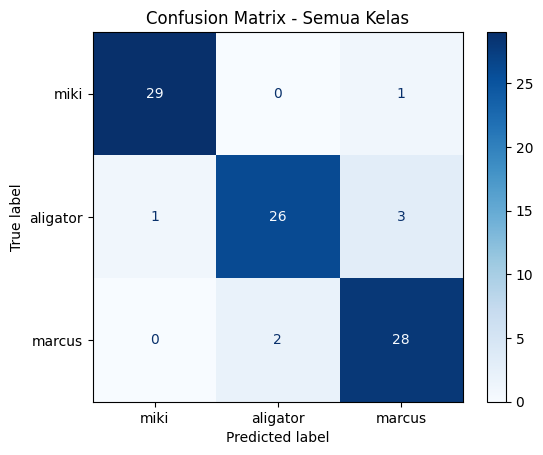

Classification Report - Semua Kelas:
              precision    recall  f1-score   support

        miki       0.97      0.97      0.97        30
    aligator       0.93      0.87      0.90        30
      marcus       0.88      0.93      0.90        30

    accuracy                           0.92        90
   macro avg       0.92      0.92      0.92        90
weighted avg       0.92      0.92      0.92        90

              precision    recall  f1-score    support
miki           0.966667  0.966667  0.966667  30.000000
aligator       0.928571  0.866667  0.896552  30.000000
marcus         0.875000  0.933333  0.903226  30.000000
accuracy       0.922222  0.922222  0.922222   0.922222
macro avg      0.923413  0.922222  0.922148  90.000000
weighted avg   0.923413  0.922222  0.922148  90.000000


In [ ]:
# Inisialisasi
y_true_all = []
y_pred_all = []

# Loop untuk mengumpulkan prediksi dan label dari seluruh test data
for image_batch, label_batch in classification_test_ds_16:
    predictions = clf_model_class1.predict(image_batch)
    predicted_labels = tf.argmax(predictions, axis=1).numpy()

    y_true_all.extend(label_batch.numpy())
    y_pred_all.extend(predicted_labels)

# Confusion Matrix
cm = confusion_matrix(y_true_all, y_pred_all)
display_labels = [label_map[i] for i in sorted(set(y_true_all + y_pred_all))]  # label_map = {0: "Kelas 1", 1: "Kelas 2", 2: "Kelas 3"}
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=display_labels)

# Visualisasi
plt.figure(figsize=(8, 6))
disp.plot(cmap=plt.cm.Blues, values_format='d')
plt.title("Confusion Matrix - Semua Kelas")
plt.grid(False)
plt.show()

# Classification Report
print("Classification Report - Semua Kelas:")
print(classification_report(y_true_all, y_pred_all, target_names=display_labels))

# (Opsional) Tampilkan sebagai DataFrame
report_df = pd.DataFrame(
    classification_report(
        y_true_all,
        y_pred_all,
        target_names=display_labels,
        output_dict=True
)
).transpose()
print(report_df)

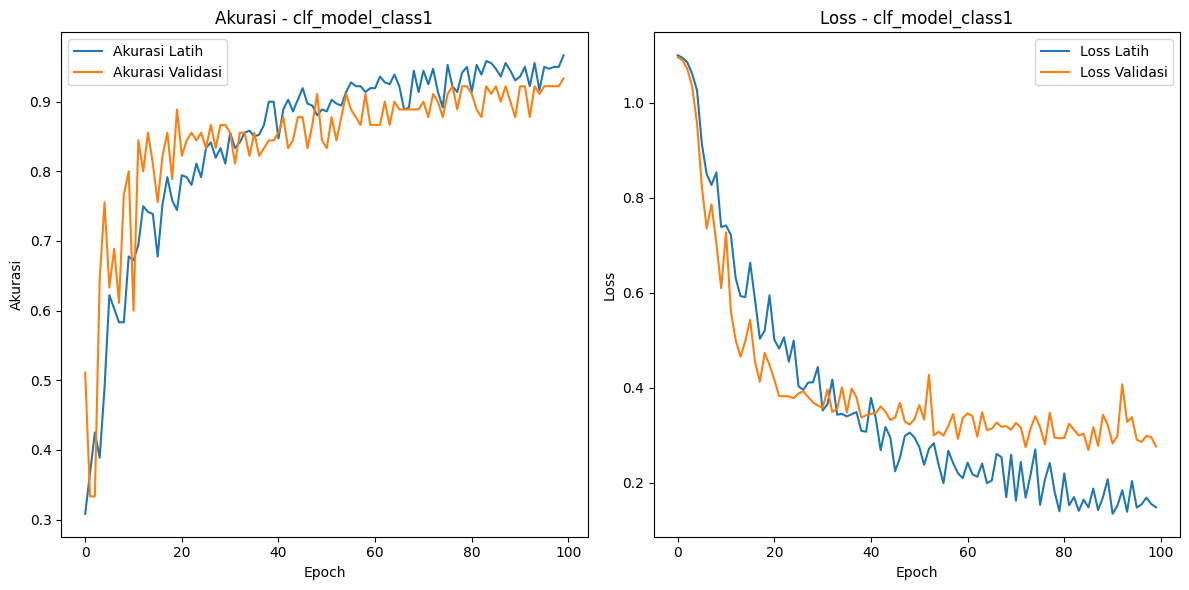

In [ ]:
import matplotlib.pyplot as plt

# Plot History untuk clf_model_class1
plt.figure(figsize=(12, 6))

# Plot Akurasi dan Loss untuk clf_model_class1
plt.subplot(1, 2, 1)  # Subplot pertama untuk akurasi
plt.plot(history_class1.history['accuracy'], label='Akurasi Latih')
plt.plot(history_class1.history['val_accuracy'], label='Akurasi Validasi')
plt.title("Akurasi - clf_model_class1")
plt.xlabel('Epoch')
plt.ylabel('Akurasi')
plt.legend(loc='best')

plt.subplot(1, 2, 2)  # Subplot kedua untuk loss
plt.plot(history_class1.history['loss'], label='Loss Latih')
plt.plot(history_class1.history['val_loss'], label='Loss Validasi')
plt.title("Loss - clf_model_class1")
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend(loc='best')

plt.tight_layout()
plt.show()

##***TRAINING CLASS BS 32***##

In [ ]:
history_class2 = clf_model_class2.fit(
    classification_train_ds_32,   # dataset sudah dibatch dengan batch size 32
    validation_data=classification_test_ds_32,   # dataset validation juga sudah dibatch
    epochs=100,
    callbacks=callbacks_class2
)

Epoch 1/100
12/12 ━━━━━━━━━━━━━━━━━━━━ 0s 194ms/step - accuracy: 0.2778 - loss: 1.1011

12/12 ━━━━━━━━━━━━━━━━━━━━ 12s 339ms/step - accuracy: 0.2776 - loss: 1.1011 - val_accuracy: 0.3333 - val_loss: 1.0974
Epoch 2/100
11/12 ━━━━━━━━━━━━━━━━━━━━ 0s 91ms/step - accuracy: 0.2877 - loss: 1.0973

12/12 ━━━━━━━━━━━━━━━━━━━━ 3s 128ms/step - accuracy: 0.2952 - loss: 1.0972 - val_accuracy: 0.3333 - val_loss: 1.0955
Epoch 3/100
11/12 ━━━━━━━━━━━━━━━━━━━━ 0s 73ms/step - accuracy: 0.2892 - loss: 1.1038

12/12 ━━━━━━━━━━━━━━━━━━━━ 2s 105ms/step - accuracy: 0.2947 - loss: 1.1032 - val_accuracy: 0.3333 - val_loss: 1.0942
Epoch 4/100
11/12 ━━━━━━━━━━━━━━━━━━━━ 0s 73ms/step - accuracy: 0.3700 - loss: 1.0949

12/12 ━━━━━━━━━━━━━━━━━━━━ 1s 99ms/step - accuracy: 0.3759 - loss: 1.0945 - val_accuracy: 0.5667 - val_loss: 1.0876
Epoch 5/100
11/12 ━━━━━━━━━━━━━━━━━━━━ 0s 75ms/step - accuracy: 0.4548 - loss: 1.0874

12/12 ━━━━━━━━━━━━━━━━━━━━ 1s 108ms/step - accuracy: 0.4506 - loss: 1.0874 - val_accuracy: 0.6444 - val_loss: 1.0679
Epoch 6/100
11/12 ━━━━━━━━━━━━━━━━━━━━ 0s 74ms/step - accuracy: 0.4440 - loss: 1.0629

12/12 ━━━━━━━━━━━━━━━━━━━━ 1s 106ms/step - accuracy: 0.4475 - loss: 1.0623 - val_accuracy: 0.5778 - val_loss: 1.0320
Epoch 7/100
11/12 ━━━━━━━━━━━━━━━━━━━━ 0s 72ms/step - accuracy: 0.4703 - loss: 1.0351

12/12 ━━━━━━━━━━━━━━━━━━━━ 2s 139ms/step - accuracy: 0.4680 - loss: 1.0338 - val_accuracy: 0.4667 - val_loss: 0.9951
Epoch 8/100
11/12 ━━━━━━━━━━━━━━━━━━━━ 0s 93ms/step - accuracy: 0.5077 - loss: 0.9936

12/12 ━━━━━━━━━━━━━━━━━━━━ 2s 117ms/step - accuracy: 0.5116 - loss: 0.9903 - val_accuracy: 0.6333 - val_loss: 0.8931
Epoch 9/100
11/12 ━━━━━━━━━━━━━━━━━━━━ 0s 72ms/step - accuracy: 0.5705 - loss: 0.9186

12/12 ━━━━━━━━━━━━━━━━━━━━ 2s 97ms/step - accuracy: 0.5699 - loss: 0.9170 - val_accuracy: 0.5333 - val_loss: 0.8632
Epoch 10/100
11/12 ━━━━━━━━━━━━━━━━━━━━ 0s 72ms/step - accuracy: 0.5473 - loss: 0.9086

12/12 ━━━━━━━━━━━━━━━━━━━━ 1s 99ms/step - accuracy: 0.5511 - loss: 0.9021 - val_accuracy: 0.6222 - val_loss: 0.8110
Epoch 11/100
11/12 ━━━━━━━━━━━━━━━━━━━━ 0s 73ms/step - accuracy: 0.5659 - loss: 0.8343

12/12 ━━━━━━━━━━━━━━━━━━━━ 1s 107ms/step - accuracy: 0.5737 - loss: 0.8274 - val_accuracy: 0.6778 - val_loss: 0.7315
Epoch 12/100
12/12 ━━━━━━━━━━━━━━━━━━━━ 1s 94ms/step - accuracy: 0.6140 - loss: 0.7972 - val_accuracy: 0.5000 - val_loss: 0.8166
Epoch 13/100
11/12 ━━━━━━━━━━━━━━━━━━━━ 0s 74ms/step - accuracy: 0.5954 - loss: 0.8206

12/12 ━━━━━━━━━━━━━━━━━━━━ 1s 100ms/step - accuracy: 0.6055 - loss: 0.8086 - val_accuracy: 0.7333 - val_loss: 0.6329
Epoch 14/100
11/12 ━━━━━━━━━━━━━━━━━━━━ 0s 71ms/step - accuracy: 0.6838 - loss: 0.7316

12/12 ━━━━━━━━━━━━━━━━━━━━ 1s 104ms/step - accuracy: 0.6872 - loss: 0.7269 - val_accuracy: 0.7889 - val_loss: 0.5759
Epoch 15/100
12/12 ━━━━━━━━━━━━━━━━━━━━ 2s 137ms/step - accuracy: 0.7231 - loss: 0.6635 - val_accuracy: 0.7222 - val_loss: 0.6370
Epoch 16/100
12/12 ━━━━━━━━━━━━━━━━━━━━ 1s 118ms/step - accuracy: 0.6496 - loss: 0.7342 - val_accuracy: 0.7667 - val_loss: 0.5869
Epoch 17/100
12/12 ━━━━━━━━━━━━━━━━━━━━ 2s 96ms/step - accuracy: 0.7151 - loss: 0.6716 - val_accuracy: 0.7222 - val_loss: 0.5934
Epoch 18/100
11/12 ━━━━━━━━━━━━━━━━━━━━ 0s 74ms/step - accuracy: 0.6759 - loss: 0.6930

12/12 ━━━━━━━━━━━━━━━━━━━━ 1s 101ms/step - accuracy: 0.6831 - loss: 0.6847 - val_accuracy: 0.8000 - val_loss: 0.5431
Epoch 19/100
12/12 ━━━━━━━━━━━━━━━━━━━━ 1s 102ms/step - accuracy: 0.7436 - loss: 0.6347 - val_accuracy: 0.7889 - val_loss: 0.5443
Epoch 20/100
12/12 ━━━━━━━━━━━━━━━━━━━━ 1s 97ms/step - accuracy: 0.6821 - loss: 0.6781 - val_accuracy: 0.6889 - val_loss: 0.6290
Epoch 21/100
11/12 ━━━━━━━━━━━━━━━━━━━━ 0s 73ms/step - accuracy: 0.6835 - loss: 0.6958

12/12 ━━━━━━━━━━━━━━━━━━━━ 1s 101ms/step - accuracy: 0.6937 - loss: 0.6828 - val_accuracy: 0.8000 - val_loss: 0.5165
Epoch 22/100
11/12 ━━━━━━━━━━━━━━━━━━━━ 0s 81ms/step - accuracy: 0.7291 - loss: 0.6120

12/12 ━━━━━━━━━━━━━━━━━━━━ 1s 112ms/step - accuracy: 0.7336 - loss: 0.6021 - val_accuracy: 0.7889 - val_loss: 0.5101
Epoch 23/100
11/12 ━━━━━━━━━━━━━━━━━━━━ 0s 79ms/step - accuracy: 0.7089 - loss: 0.6247

12/12 ━━━━━━━━━━━━━━━━━━━━ 1s 106ms/step - accuracy: 0.7144 - loss: 0.6166 - val_accuracy: 0.8222 - val_loss: 0.4835
Epoch 24/100
11/12 ━━━━━━━━━━━━━━━━━━━━ 0s 87ms/step - accuracy: 0.7464 - loss: 0.6092

12/12 ━━━━━━━━━━━━━━━━━━━━ 3s 127ms/step - accuracy: 0.7495 - loss: 0.6018 - val_accuracy: 0.8111 - val_loss: 0.4754
Epoch 25/100
12/12 ━━━━━━━━━━━━━━━━━━━━ 2s 105ms/step - accuracy: 0.7635 - loss: 0.5590 - val_accuracy: 0.7889 - val_loss: 0.5024
Epoch 26/100
11/12 ━━━━━━━━━━━━━━━━━━━━ 0s 77ms/step - accuracy: 0.7432 - loss: 0.5921

12/12 ━━━━━━━━━━━━━━━━━━━━ 1s 110ms/step - accuracy: 0.7455 - loss: 0.5850 - val_accuracy: 0.8111 - val_loss: 0.4705
Epoch 27/100
12/12 ━━━━━━━━━━━━━━━━━━━━ 2s 102ms/step - accuracy: 0.7653 - loss: 0.5958 - val_accuracy: 0.7889 - val_loss: 0.5081
Epoch 28/100
12/12 ━━━━━━━━━━━━━━━━━━━━ 1s 101ms/step - accuracy: 0.7646 - loss: 0.5689 - val_accuracy: 0.8111 - val_loss: 0.4770
Epoch 29/100
11/12 ━━━━━━━━━━━━━━━━━━━━ 0s 78ms/step - accuracy: 0.7395 - loss: 0.5886

12/12 ━━━━━━━━━━━━━━━━━━━━ 1s 111ms/step - accuracy: 0.7462 - loss: 0.5766 - val_accuracy: 0.8222 - val_loss: 0.4481
Epoch 30/100
12/12 ━━━━━━━━━━━━━━━━━━━━ 3s 145ms/step - accuracy: 0.7698 - loss: 0.5727 - val_accuracy: 0.8111 - val_loss: 0.4870
Epoch 31/100
11/12 ━━━━━━━━━━━━━━━━━━━━ 0s 82ms/step - accuracy: 0.7487 - loss: 0.6046

12/12 ━━━━━━━━━━━━━━━━━━━━ 2s 113ms/step - accuracy: 0.7549 - loss: 0.5946 - val_accuracy: 0.8111 - val_loss: 0.4435
Epoch 32/100
12/12 ━━━━━━━━━━━━━━━━━━━━ 1s 99ms/step - accuracy: 0.7597 - loss: 0.5415 - val_accuracy: 0.7778 - val_loss: 0.4961
Epoch 33/100
12/12 ━━━━━━━━━━━━━━━━━━━━ 1s 105ms/step - accuracy: 0.7731 - loss: 0.5571 - val_accuracy: 0.8000 - val_loss: 0.4740
Epoch 34/100
11/12 ━━━━━━━━━━━━━━━━━━━━ 0s 78ms/step - accuracy: 0.7639 - loss: 0.5791

12/12 ━━━━━━━━━━━━━━━━━━━━ 1s 110ms/step - accuracy: 0.7694 - loss: 0.5672 - val_accuracy: 0.8222 - val_loss: 0.4283
Epoch 35/100
12/12 ━━━━━━━━━━━━━━━━━━━━ 1s 103ms/step - accuracy: 0.8165 - loss: 0.5032 - val_accuracy: 0.8111 - val_loss: 0.4423
Epoch 36/100
12/12 ━━━━━━━━━━━━━━━━━━━━ 1s 104ms/step - accuracy: 0.8241 - loss: 0.4951 - val_accuracy: 0.8444 - val_loss: 0.4358
Epoch 37/100
12/12 ━━━━━━━━━━━━━━━━━━━━ 1s 101ms/step - accuracy: 0.7822 - loss: 0.5869 - val_accuracy: 0.7556 - val_loss: 0.4820
Epoch 38/100
11/12 ━━━━━━━━━━━━━━━━━━━━ 0s 76ms/step - accuracy: 0.7965 - loss: 0.5646

12/12 ━━━━━━━━━━━━━━━━━━━━ 1s 108ms/step - accuracy: 0.8047 - loss: 0.5514 - val_accuracy: 0.8556 - val_loss: 0.4237
Epoch 39/100
11/12 ━━━━━━━━━━━━━━━━━━━━ 0s 88ms/step - accuracy: 0.7932 - loss: 0.5634

12/12 ━━━━━━━━━━━━━━━━━━━━ 1s 122ms/step - accuracy: 0.7934 - loss: 0.5549 - val_accuracy: 0.8444 - val_loss: 0.4228
Epoch 40/100
12/12 ━━━━━━━━━━━━━━━━━━━━ 2s 104ms/step - accuracy: 0.7858 - loss: 0.5164 - val_accuracy: 0.8444 - val_loss: 0.4300
Epoch 41/100
11/12 ━━━━━━━━━━━━━━━━━━━━ 0s 77ms/step - accuracy: 0.7769 - loss: 0.5257

12/12 ━━━━━━━━━━━━━━━━━━━━ 1s 109ms/step - accuracy: 0.7839 - loss: 0.5128 - val_accuracy: 0.8444 - val_loss: 0.4143
Epoch 42/100
11/12 ━━━━━━━━━━━━━━━━━━━━ 0s 79ms/step - accuracy: 0.7744 - loss: 0.4894

12/12 ━━━━━━━━━━━━━━━━━━━━ 3s 111ms/step - accuracy: 0.7818 - loss: 0.4792 - val_accuracy: 0.8444 - val_loss: 0.3770
Epoch 43/100
11/12 ━━━━━━━━━━━━━━━━━━━━ 0s 78ms/step - accuracy: 0.8053 - loss: 0.4465

12/12 ━━━━━━━━━━━━━━━━━━━━ 1s 107ms/step - accuracy: 0.8096 - loss: 0.4404 - val_accuracy: 0.8667 - val_loss: 0.3691
Epoch 44/100
12/12 ━━━━━━━━━━━━━━━━━━━━ 3s 107ms/step - accuracy: 0.8199 - loss: 0.4614 - val_accuracy: 0.8333 - val_loss: 0.4289
Epoch 45/100
12/12 ━━━━━━━━━━━━━━━━━━━━ 3s 119ms/step - accuracy: 0.7969 - loss: 0.5589 - val_accuracy: 0.8444 - val_loss: 0.3867
Epoch 46/100
11/12 ━━━━━━━━━━━━━━━━━━━━ 0s 96ms/step - accuracy: 0.8323 - loss: 0.4556

12/12 ━━━━━━━━━━━━━━━━━━━━ 2s 174ms/step - accuracy: 0.8346 - loss: 0.4486 - val_accuracy: 0.8556 - val_loss: 0.3668
Epoch 47/100
11/12 ━━━━━━━━━━━━━━━━━━━━ 0s 79ms/step - accuracy: 0.8434 - loss: 0.4135

12/12 ━━━━━━━━━━━━━━━━━━━━ 2s 106ms/step - accuracy: 0.8470 - loss: 0.4075 - val_accuracy: 0.8889 - val_loss: 0.3597
Epoch 48/100
11/12 ━━━━━━━━━━━━━━━━━━━━ 0s 78ms/step - accuracy: 0.7903 - loss: 0.4750

12/12 ━━━━━━━━━━━━━━━━━━━━ 3s 110ms/step - accuracy: 0.7956 - loss: 0.4640 - val_accuracy: 0.8778 - val_loss: 0.3326
Epoch 49/100
12/12 ━━━━━━━━━━━━━━━━━━━━ 1s 111ms/step - accuracy: 0.8477 - loss: 0.3693 - val_accuracy: 0.8778 - val_loss: 0.3385
Epoch 50/100
12/12 ━━━━━━━━━━━━━━━━━━━━ 1s 102ms/step - accuracy: 0.8450 - loss: 0.4205 - val_accuracy: 0.8444 - val_loss: 0.3902
Epoch 51/100
12/12 ━━━━━━━━━━━━━━━━━━━━ 1s 106ms/step - accuracy: 0.8345 - loss: 0.4041 - val_accuracy: 0.8556 - val_loss: 0.3805
Epoch 52/100
11/12 ━━━━━━━━━━━━━━━━━━━━ 0s 79ms/step - accuracy: 0.8505 - loss: 0.4429

12/12 ━━━━━━━━━━━━━━━━━━━━ 1s 109ms/step - accuracy: 0.8522 - loss: 0.4321 - val_accuracy: 0.8778 - val_loss: 0.3260
Epoch 53/100
12/12 ━━━━━━━━━━━━━━━━━━━━ 1s 120ms/step - accuracy: 0.8319 - loss: 0.3899 - val_accuracy: 0.8778 - val_loss: 0.3470
Epoch 54/100
11/12 ━━━━━━━━━━━━━━━━━━━━ 0s 91ms/step - accuracy: 0.8472 - loss: 0.3902

12/12 ━━━━━━━━━━━━━━━━━━━━ 2s 130ms/step - accuracy: 0.8515 - loss: 0.3826 - val_accuracy: 0.9000 - val_loss: 0.2962
Epoch 55/100
11/12 ━━━━━━━━━━━━━━━━━━━━ 0s 79ms/step - accuracy: 0.8429 - loss: 0.4007

12/12 ━━━━━━━━━━━━━━━━━━━━ 2s 107ms/step - accuracy: 0.8448 - loss: 0.3982 - val_accuracy: 0.9111 - val_loss: 0.2960
Epoch 56/100
12/12 ━━━━━━━━━━━━━━━━━━━━ 1s 106ms/step - accuracy: 0.8630 - loss: 0.3466 - val_accuracy: 0.9000 - val_loss: 0.3168
Epoch 57/100
12/12 ━━━━━━━━━━━━━━━━━━━━ 2s 102ms/step - accuracy: 0.8504 - loss: 0.3934 - val_accuracy: 0.8778 - val_loss: 0.3395
Epoch 58/100
12/12 ━━━━━━━━━━━━━━━━━━━━ 1s 105ms/step - accuracy: 0.8658 - loss: 0.3629 - val_accuracy: 0.8333 - val_loss: 0.3865
Epoch 59/100
12/12 ━━━━━━━━━━━━━━━━━━━━ 1s 105ms/step - accuracy: 0.8609 - loss: 0.3612 - val_accuracy: 0.8667 - val_loss: 0.3534
Epoch 60/100
12/12 ━━━━━━━━━━━━━━━━━━━━ 1s 103ms/step - accuracy: 0.8398 - loss: 0.3717 - val_accuracy: 0.8778 - val_loss: 0.3373
Epoch 61/100
12/12 ━━━━━━━━━━━━━━━━━━━━ 2s 161ms/step - accuracy: 0.8652 - loss: 0.3607 - val_accuracy: 0.9111 - val_loss: 0.3034
Epoch 62/100
12/12 ━━━━━━━━━━━━━━━━━━━━ 2s 126ms/step - accuracy: 0.8522 - loss: 0.3835 - val_accuracy:

12/12 ━━━━━━━━━━━━━━━━━━━━ 1s 118ms/step - accuracy: 0.9096 - loss: 0.2920 - val_accuracy: 0.9111 - val_loss: 0.2611
Epoch 68/100
12/12 ━━━━━━━━━━━━━━━━━━━━ 1s 104ms/step - accuracy: 0.8900 - loss: 0.3006 - val_accuracy: 0.9333 - val_loss: 0.2788
Epoch 69/100
12/12 ━━━━━━━━━━━━━━━━━━━━ 3s 117ms/step - accuracy: 0.8563 - loss: 0.3877 - val_accuracy: 0.9111 - val_loss: 0.2923
Epoch 70/100
12/12 ━━━━━━━━━━━━━━━━━━━━ 1s 99ms/step - accuracy: 0.8459 - loss: 0.3695 - val_accuracy: 0.9111 - val_loss: 0.3400
Epoch 71/100
12/12 ━━━━━━━━━━━━━━━━━━━━ 1s 99ms/step - accuracy: 0.8710 - loss: 0.3634 - val_accuracy: 0.8333 - val_loss: 0.3659
Epoch 72/100
12/12 ━━━━━━━━━━━━━━━━━━━━ 1s 106ms/step - accuracy: 0.8727 - loss: 0.3401 - val_accuracy: 0.9111 - val_loss: 0.2904
Epoch 73/100
11/12 ━━━━━━━━━━━━━━━━━━━━ 0s 76ms/step - accuracy: 0.9033 - loss: 0.3032

12/12 ━━━━━━━━━━━━━━━━━━━━ 1s 108ms/step - accuracy: 0.9045 - loss: 0.2959 - val_accuracy: 0.9222 - val_loss: 0.2596
Epoch 74/100
12/12 ━━━━━━━━━━━━━━━━━━━━ 1s 98ms/step - accuracy: 0.9108 - loss: 0.2645 - val_accuracy: 0.9333 - val_loss: 0.2788
Epoch 75/100
12/12 ━━━━━━━━━━━━━━━━━━━━ 1s 103ms/step - accuracy: 0.8896 - loss: 0.2889 - val_accuracy: 0.9000 - val_loss: 0.2843
Epoch 76/100
12/12 ━━━━━━━━━━━━━━━━━━━━ 1s 97ms/step - accuracy: 0.9001 - loss: 0.3191 - val_accuracy: 0.9333 - val_loss: 0.2679
Epoch 77/100
12/12 ━━━━━━━━━━━━━━━━━━━━ 2s 141ms/step - accuracy: 0.8818 - loss: 0.3210 - val_accuracy: 0.9333 - val_loss: 0.2811
Epoch 78/100
12/12 ━━━━━━━━━━━━━━━━━━━━ 2s 147ms/step - accuracy: 0.8953 - loss: 0.2794 - val_accuracy: 0.9222 - val_loss: 0.2782
Epoch 79/100
12/12 ━━━━━━━━━━━━━━━━━━━━ 1s 98ms/step - accuracy: 0.8660 - loss: 0.3111 - val_accuracy: 0.8889 - val_loss: 0.3362
Epoch 80/100
12/12 ━━━━━━━━━━━━━━━━━━━━ 1s 103ms/step - accuracy: 0.8809 - loss: 0.3214 - val_accuracy: 0.

12/12 ━━━━━━━━━━━━━━━━━━━━ 1s 110ms/step - accuracy: 0.9473 - loss: 0.2258 - val_accuracy: 0.9333 - val_loss: 0.2299
Epoch 83/100
12/12 ━━━━━━━━━━━━━━━━━━━━ 2s 97ms/step - accuracy: 0.9132 - loss: 0.2652 - val_accuracy: 0.9222 - val_loss: 0.2389
Epoch 84/100
12/12 ━━━━━━━━━━━━━━━━━━━━ 1s 97ms/step - accuracy: 0.9001 - loss: 0.2664 - val_accuracy: 0.9333 - val_loss: 0.2423
Epoch 85/100
12/12 ━━━━━━━━━━━━━━━━━━━━ 1s 97ms/step - accuracy: 0.9066 - loss: 0.2749 - val_accuracy: 0.8667 - val_loss: 0.3310
Epoch 86/100
12/12 ━━━━━━━━━━━━━━━━━━━━ 2s 150ms/step - accuracy: 0.8664 - loss: 0.3020 - val_accuracy: 0.9000 - val_loss: 0.3052
Epoch 87/100
12/12 ━━━━━━━━━━━━━━━━━━━━ 2s 142ms/step - accuracy: 0.8972 - loss: 0.2855 - val_accuracy: 0.9000 - val_loss: 0.3391
Epoch 88/100
12/12 ━━━━━━━━━━━━━━━━━━━━ 1s 95ms/step - accuracy: 0.8963 - loss: 0.2686 - val_accuracy: 0.9000 - val_loss: 0.2582
Epoch 89/100
12/12 ━━━━━━━━━━━━━━━━━━━━ 1s 102ms/step - accuracy: 0.9247 - loss: 0.2564 - val_accuracy: 0.9

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 344ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 34ms/step


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 304ms/step


<Figure size 800x600 with 0 Axes>

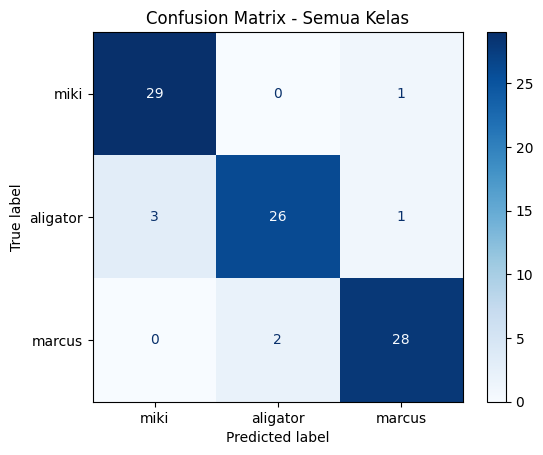

Classification Report - Semua Kelas:
              precision    recall  f1-score   support

        miki       0.91      0.97      0.94        30
    aligator       0.93      0.87      0.90        30
      marcus       0.93      0.93      0.93        30

    accuracy                           0.92        90
   macro avg       0.92      0.92      0.92        90
weighted avg       0.92      0.92      0.92        90

              precision    recall  f1-score    support
miki           0.906250  0.966667  0.935484  30.000000
aligator       0.928571  0.866667  0.896552  30.000000
marcus         0.933333  0.933333  0.933333  30.000000
accuracy       0.922222  0.922222  0.922222   0.922222
macro avg      0.922718  0.922222  0.921790  90.000000
weighted avg   0.922718  0.922222  0.921790  90.000000


In [ ]:
# Inisialisasi
y_true_all2 = []
y_pred_all2 = []

# Loop untuk mengumpulkan prediksi dan label dari seluruh test data
for image_batch, label_batch in classification_test_ds_32:
    predictions = clf_model_class2.predict(image_batch)
    predicted_labels = tf.argmax(predictions, axis=1).numpy()

    y_true_all2.extend(label_batch.numpy())
    y_pred_all2.extend(predicted_labels)

# Confusion Matrix
cm = confusion_matrix(y_true_all2, y_pred_all2)
display_labels = [label_map[i] for i in sorted(set(y_true_all2 + y_pred_all2))]  # label_map = {0: "Kelas 1", 1: "Kelas 2", 2: "Kelas 3"}
disp2 = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=display_labels)

# Visualisasi
plt.figure(figsize=(8, 6))
disp2.plot(cmap=plt.cm.Blues, values_format='d')
plt.title("Confusion Matrix - Semua Kelas")
plt.grid(False)
plt.show()

# Classification Report
print("Classification Report - Semua Kelas:")
print(classification_report(y_true_all2, y_pred_all2, target_names=display_labels))

# (Opsional) Tampilkan sebagai DataFrame
report_df2 = pd.DataFrame(
    classification_report(
        y_true_all2,
        y_pred_all2,
        target_names=display_labels,
        output_dict=True
)
).transpose()
print(report_df2)

In [ ]:
# Plot History untuk clf_model_class2
plt.figure(figsize=(12, 6))

# Plot Akurasi dan Loss untuk clf_model_class2
plt.subplot(1, 2, 1)  # Subplot pertama untuk akurasi
plt.plot(history_class2.history['accuracy'], label='Akurasi Latih')
plt.plot(history_class2.history['val_accuracy'], label='Akurasi Validasi')
plt.title("Akurasi - clf_model_class2")
plt.xlabel('Epoch')
plt.ylabel('Akurasi')
plt.legend(loc='best')

plt.subplot(1, 2, 2)  # Subplot kedua untuk loss
plt.plot(history_class2.history['loss'], label='Loss Latih')
plt.plot(history_class2.history['val_loss'], label='Loss Validasi')
plt.title("Loss - clf_model_class2")
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend(loc='best')

plt.tight_layout()
plt.show()


##**VISUALISASI AKHIR**##

In [ ]:
# # Warna RGB untuk setiap kelas
# COLOR_MAP = {
#     0: [0, 255, 0],    # marcus → hijau
#     1: [0, 0, 255],    # miki → biru
#     2: [255, 0, 0],    # aligator → merah
# }

# def colorize_binary_mask(mask, label_idx):
#     color = tf.constant(COLOR_MAP.get(label_idx, [255, 255, 255]), dtype=tf.uint8)
#     mask = tf.cast(mask > 0.5, tf.uint8)
#     mask_rgb = tf.repeat(mask, repeats=3, axis=-1) * color
#     return mask_rgb

In [ ]:
# def visualize_all_test_images(image_paths, mask_paths, labels, unet_model, clf_model, label_map, max_visualize=None):
#     label_names = {v: k for k, v in label_map.items()}
#     num_samples = len(image_paths)

#     if max_visualize is not None:
#         num_samples = min(num_samples, max_visualize)

#     for i in range(num_samples):
#         image_path = image_paths[i]
#         mask_path = mask_paths[i]
#         true_label_idx = labels[i]

#         # Load image
#         image_raw = tf.io.read_file(image_path)
#         image = tf.image.decode_jpeg(image_raw, channels=3)
#         image = tf.image.resize(image, [128, 128])
#         image = tf.cast(image, tf.float32) / 255.0

#         # Load ground truth mask
#         try:
#             mask_raw = tf.io.read_file(mask_path)
#             gt_mask = tf.image.decode_jpeg(mask_raw, channels=1)
#             gt_mask = tf.image.resize(gt_mask, [128, 128])
#             gt_mask = tf.cast(gt_mask, tf.float32)
#         except:
#             gt_mask = tf.zeros((128, 128, 1), dtype=tf.float32)

#         # Predict mask with U-Net
#         pred_mask = unet_model(tf.expand_dims(image, 0), training=False)
#         pred_mask = tf.squeeze(pred_mask, 0)

#         # Apply predicted mask for feature extraction
#         masked_image = apply_unet_segmentation_to_image(image, pred_mask)

#         # Predict label with classifier
#         pred_probs = clf_model(tf.expand_dims(masked_image, 0), training=False)
#         pred_label_idx = int(tf.argmax(pred_probs, axis=-1).numpy()[0])

#         # Convert label to string
#         true_label_str = label_names.get(true_label_idx, f"Unknown ({true_label_idx})")
#         pred_label_str = label_names.get(pred_label_idx, f"Unknown ({pred_label_idx})")

#         # Visualisasi
#         fig, axes = plt.subplots(1, 5, figsize=(22, 5))
#         axes[0].imshow(image.numpy())
#         axes[0].set_title("Original Image")
#         axes[0].axis('off')

#         axes[1].imshow(colorize_binary_mask(gt_mask, true_label_idx))
#         axes[1].set_title("Ground Truth Mask")
#         axes[1].axis('off')

#         axes[2].imshow(tf.squeeze(pred_mask), cmap='gray')
#         axes[2].set_title("Predicted Mask (U-Net)")
#         axes[2].axis('off')

#         axes[3].imshow(masked_image.numpy())
#         axes[3].set_title("Masked Image (Fitur Ekstraksi)")
#         axes[3].axis('off')

#         axes[4].imshow(masked_image.numpy())
#         axes[4].set_title(f"Label Asli: {true_label_str}\nPrediksi: {pred_label_str}")
#         axes[4].axis('off')

#         filename = image_path.split('/')[-1]
#         plt.suptitle(f"Visualisasi: {filename}", fontsize=14, y=1.05)
#         plt.tight_layout()
#         plt.show()

Daftar warna ground truth untuk setiap jenis daun:
- marcus: hijau
- miki: biru
- aligator: merah


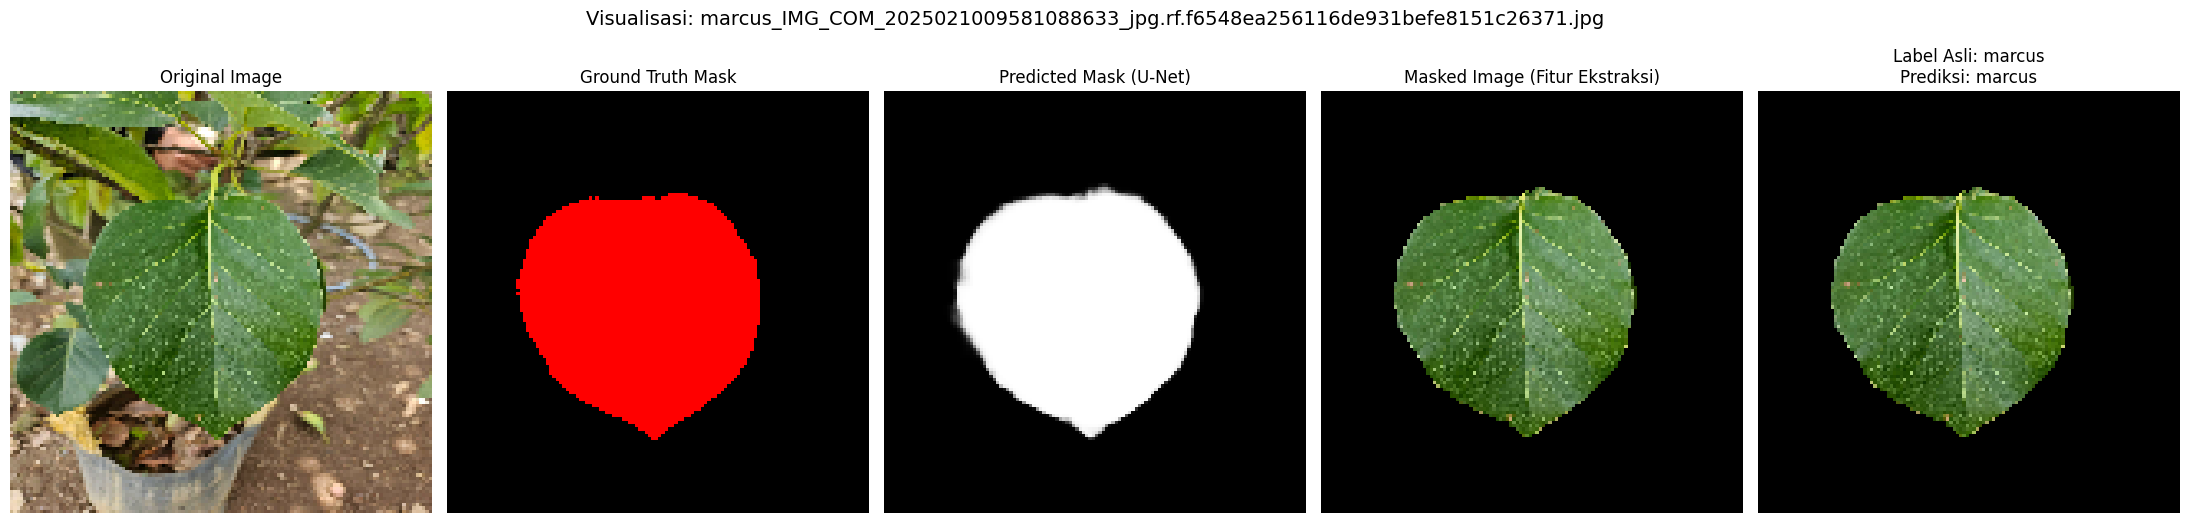

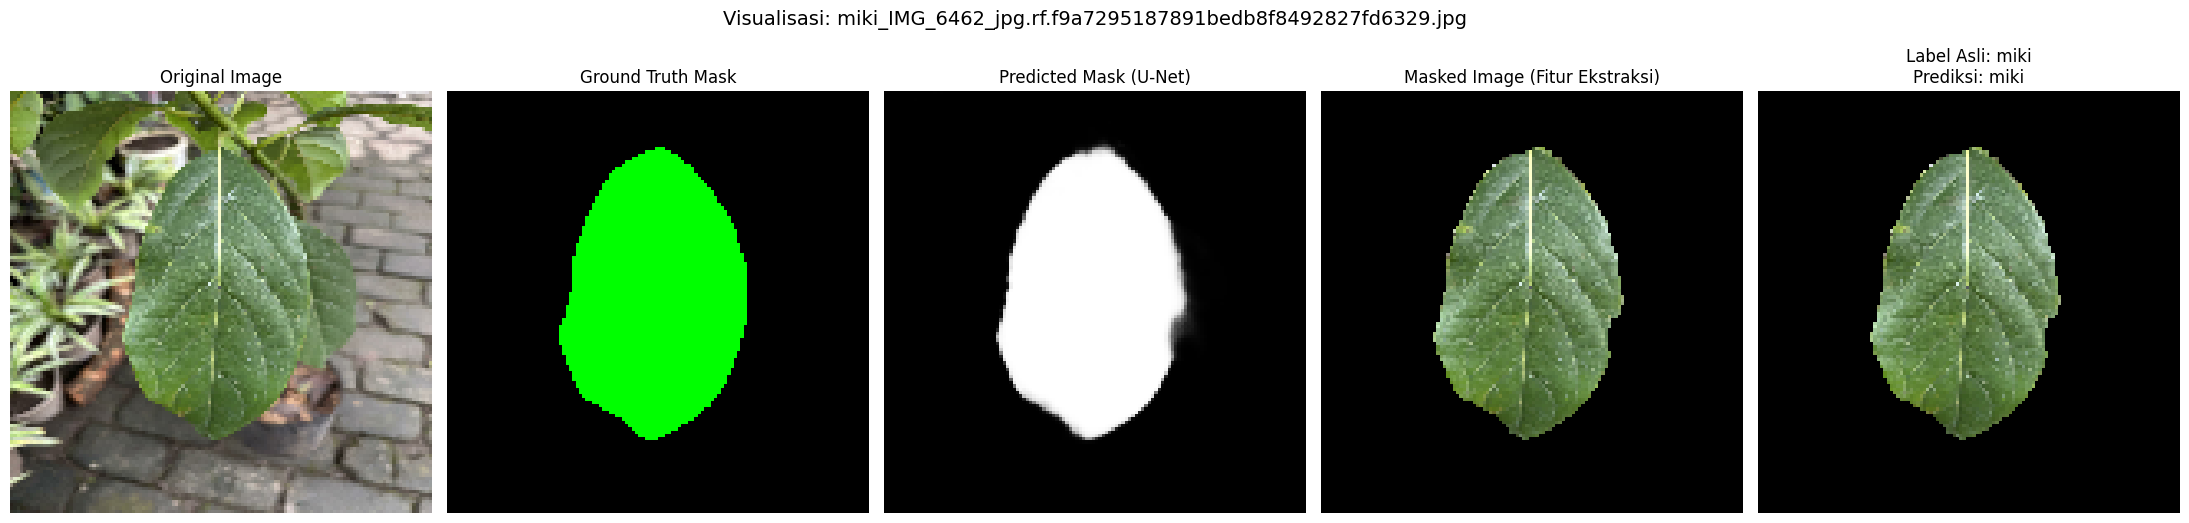

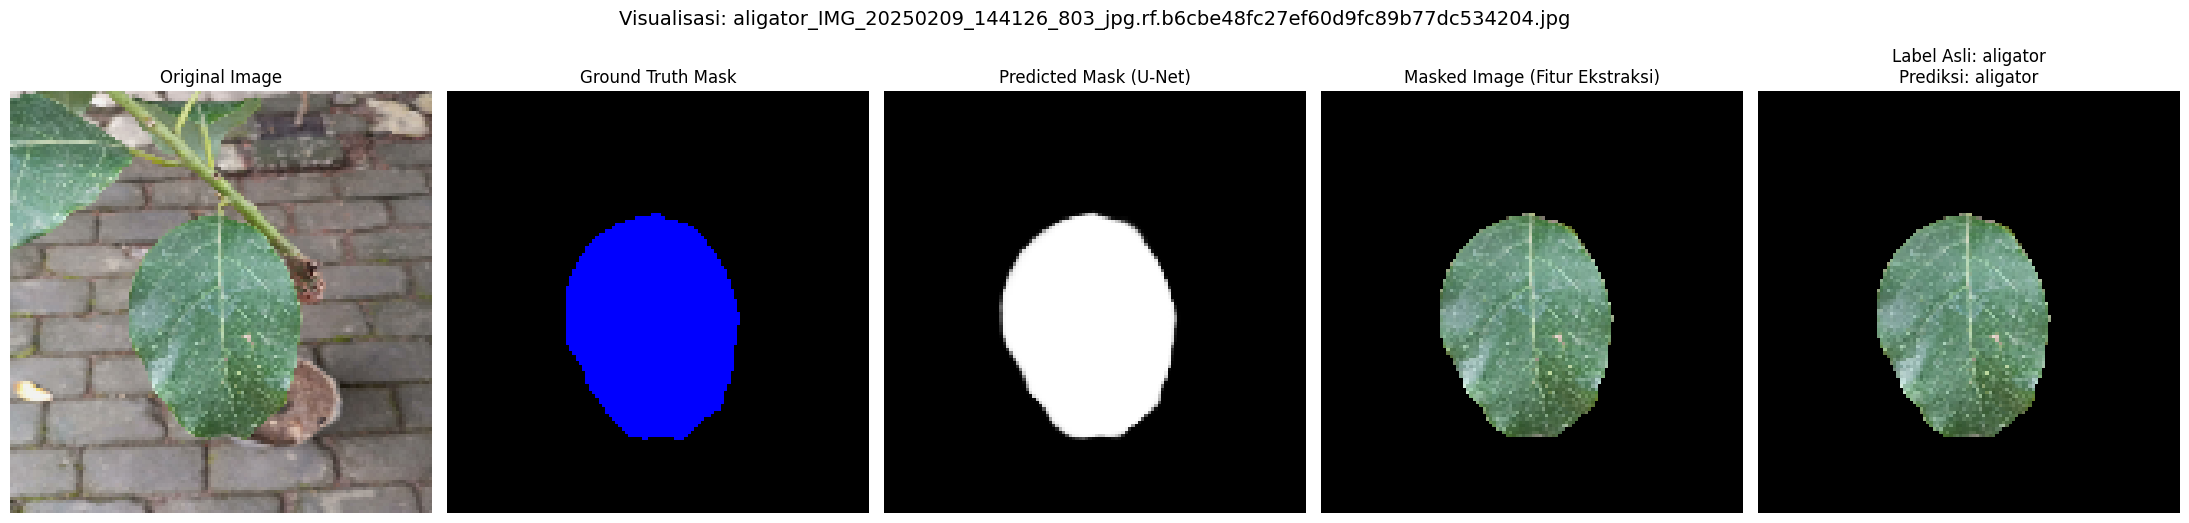

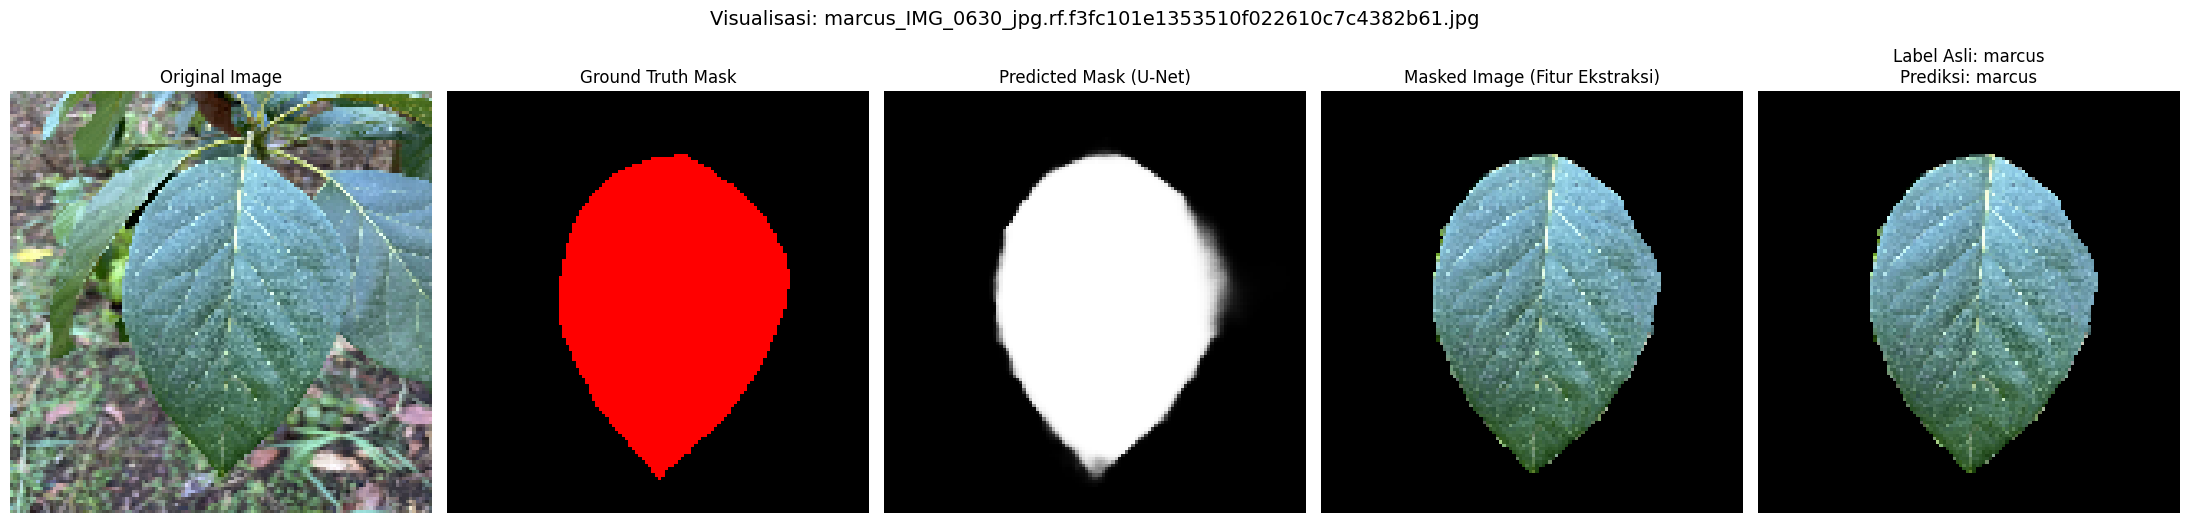

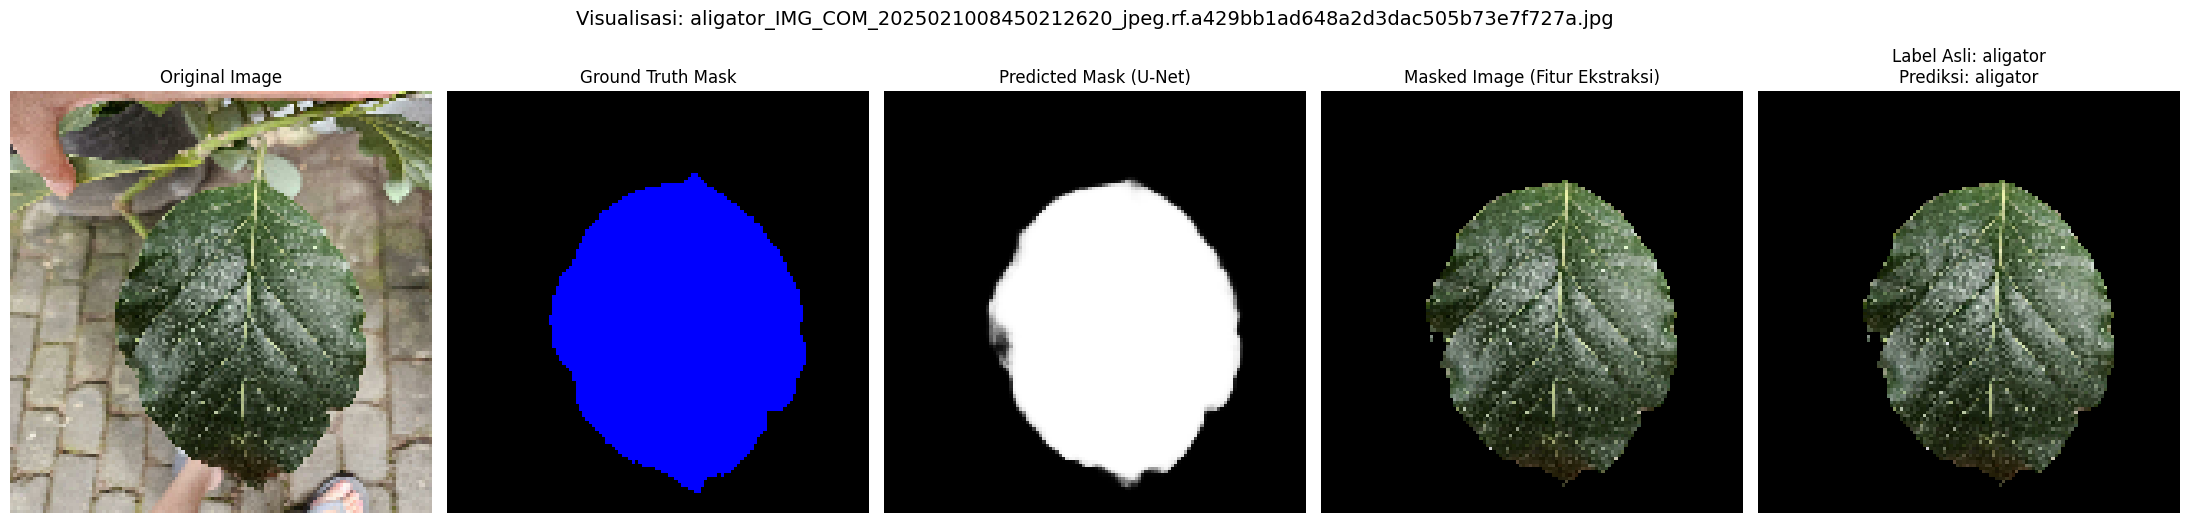

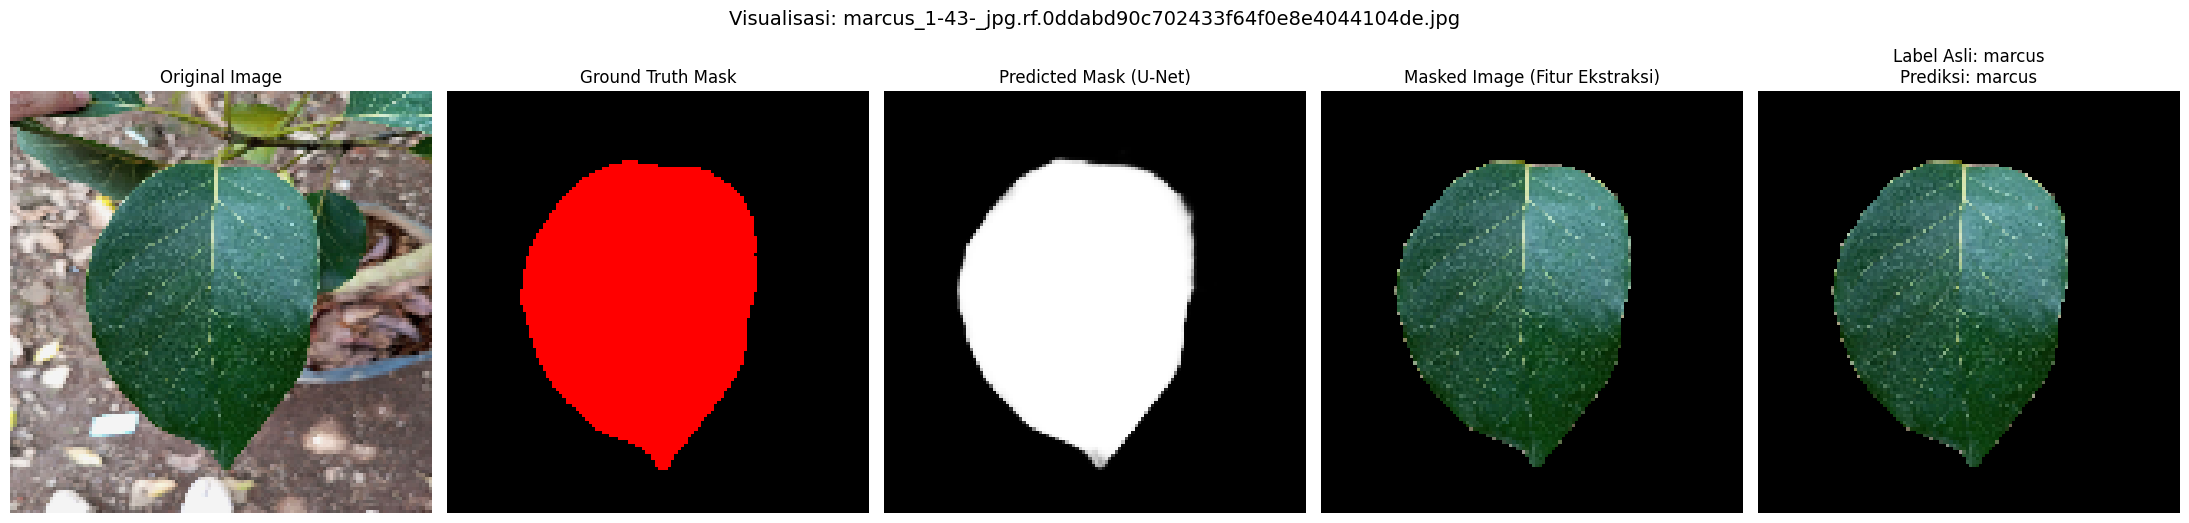

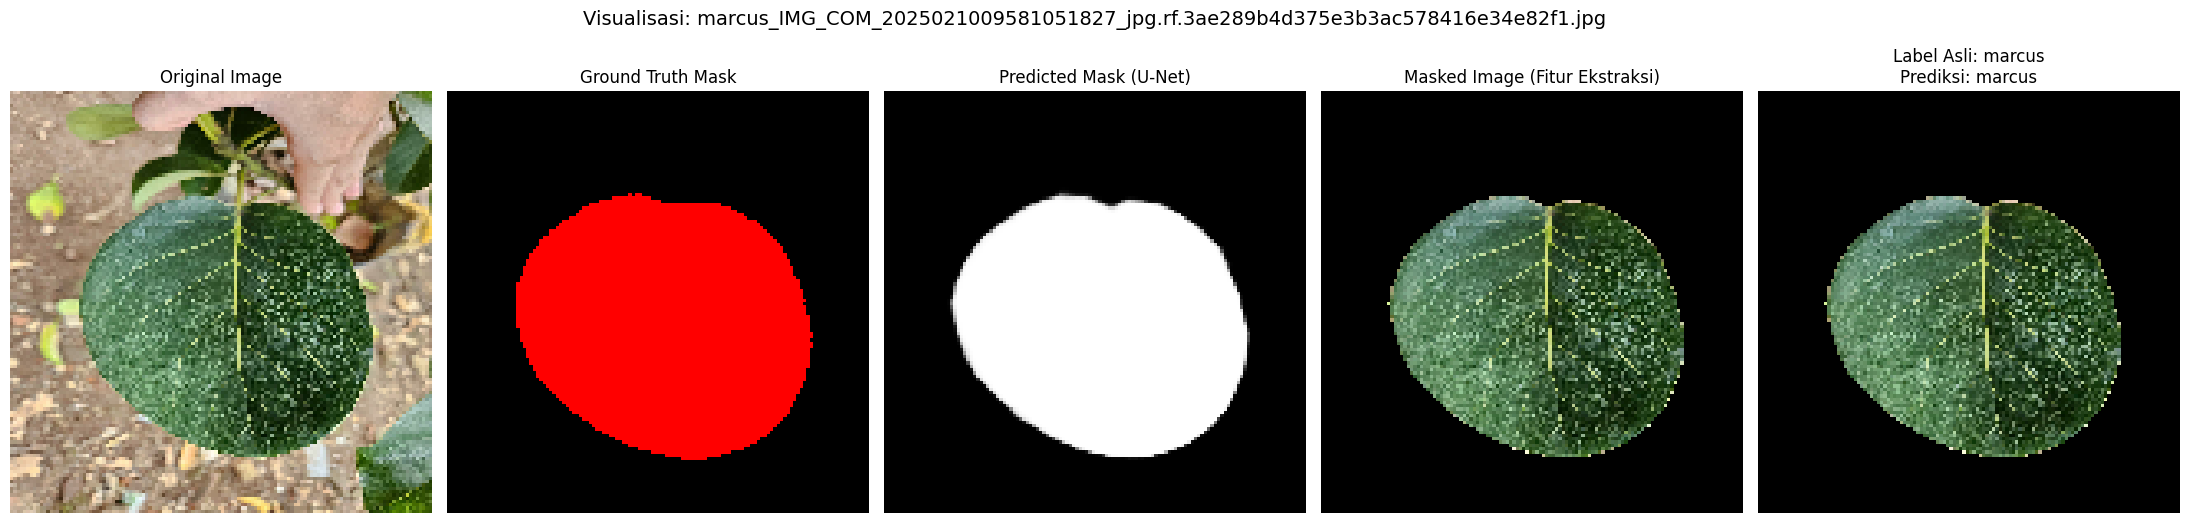

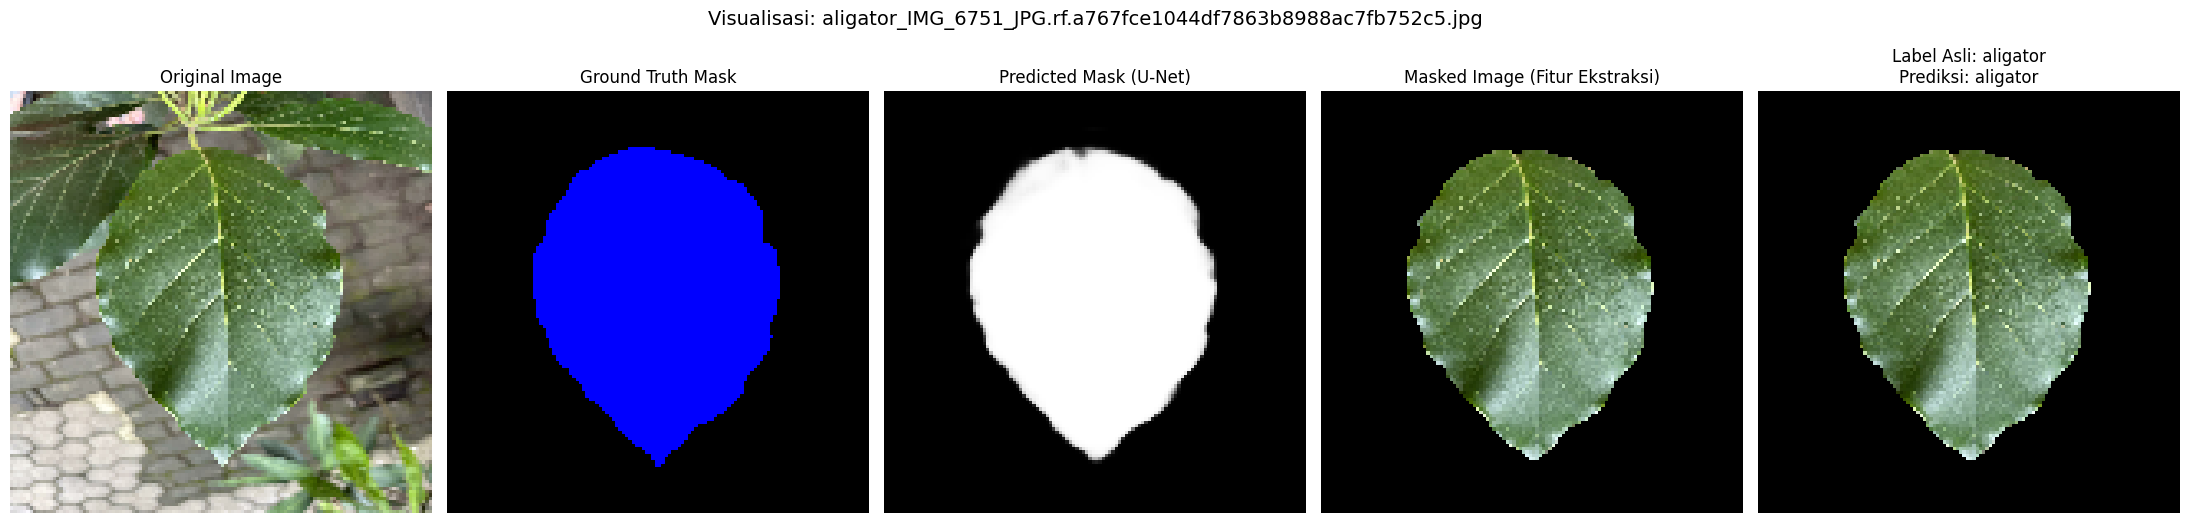

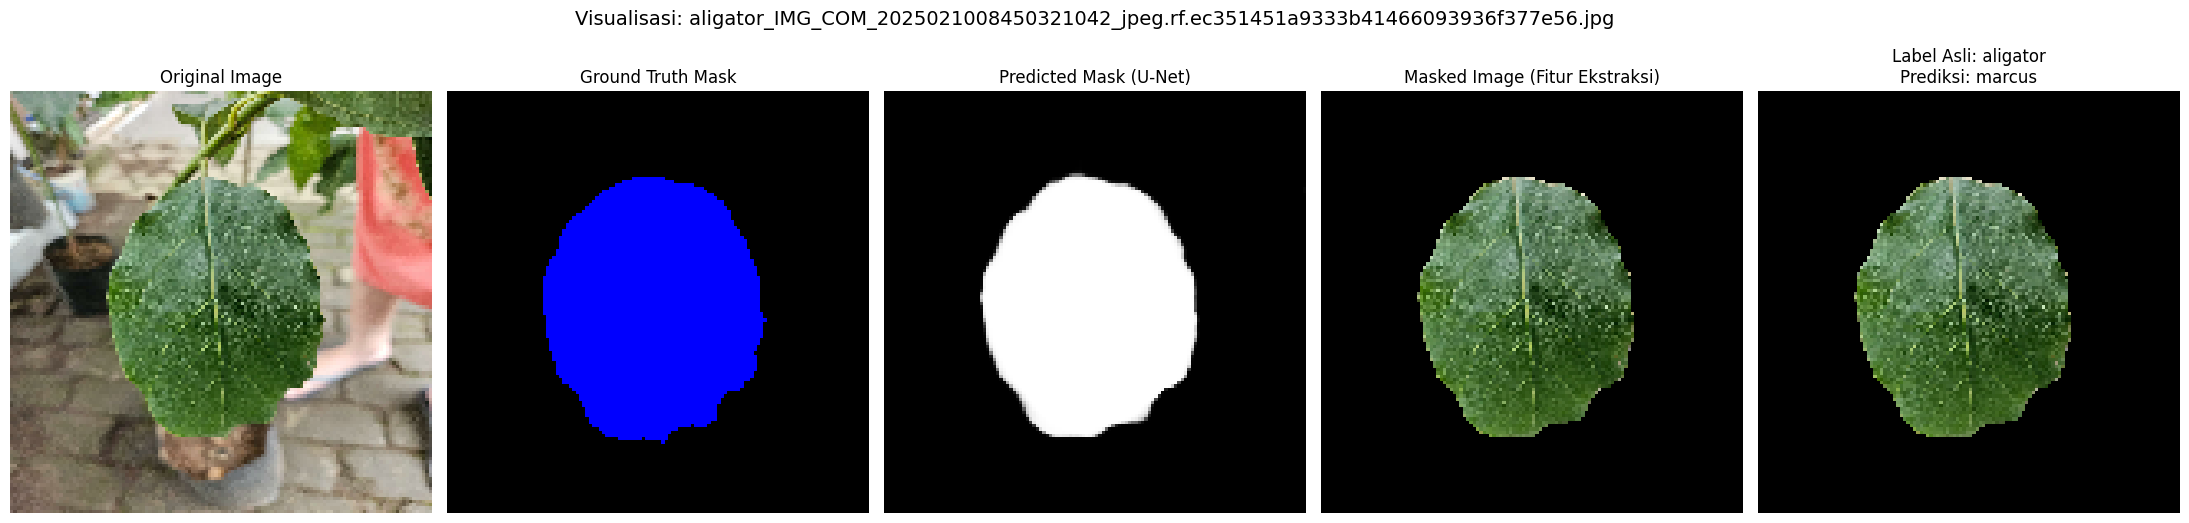

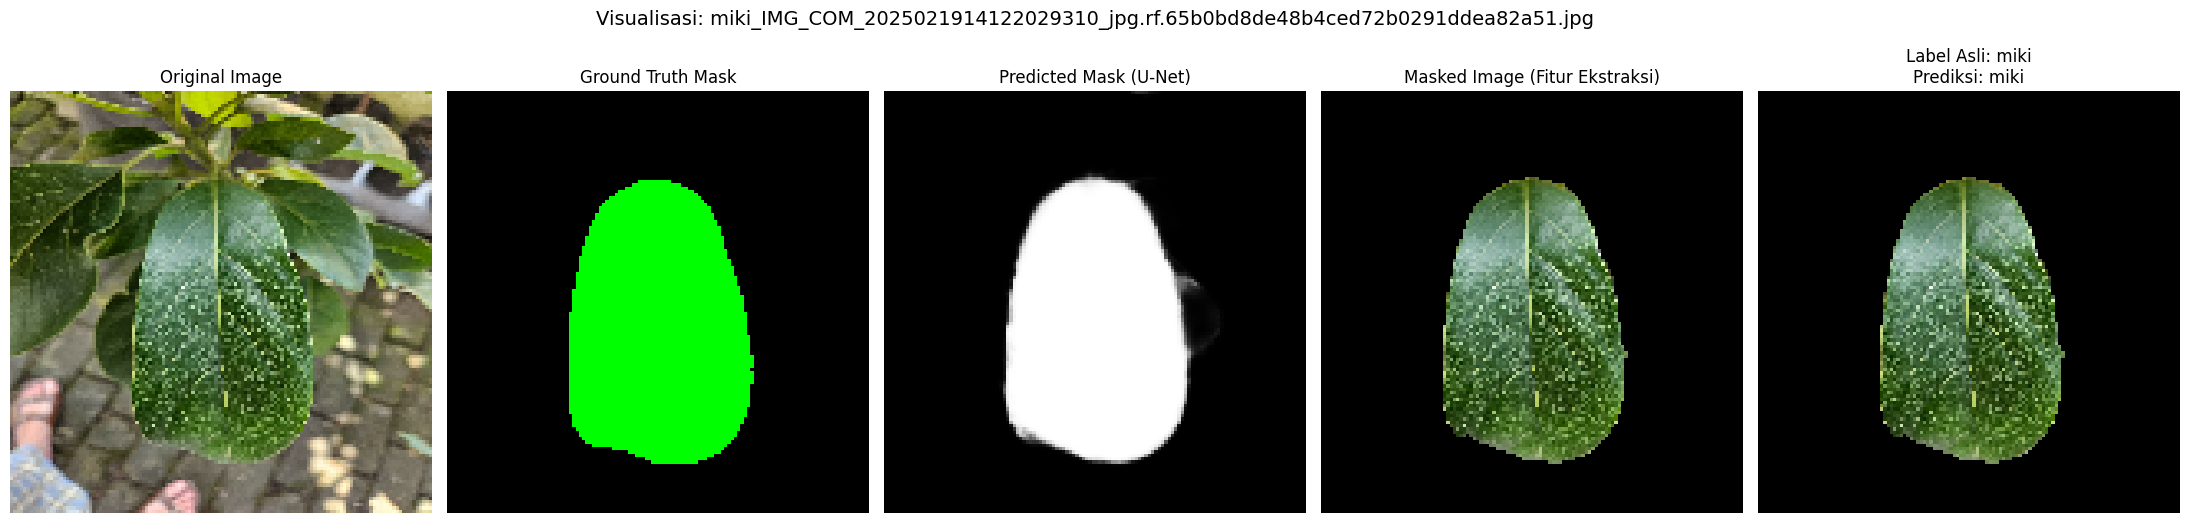

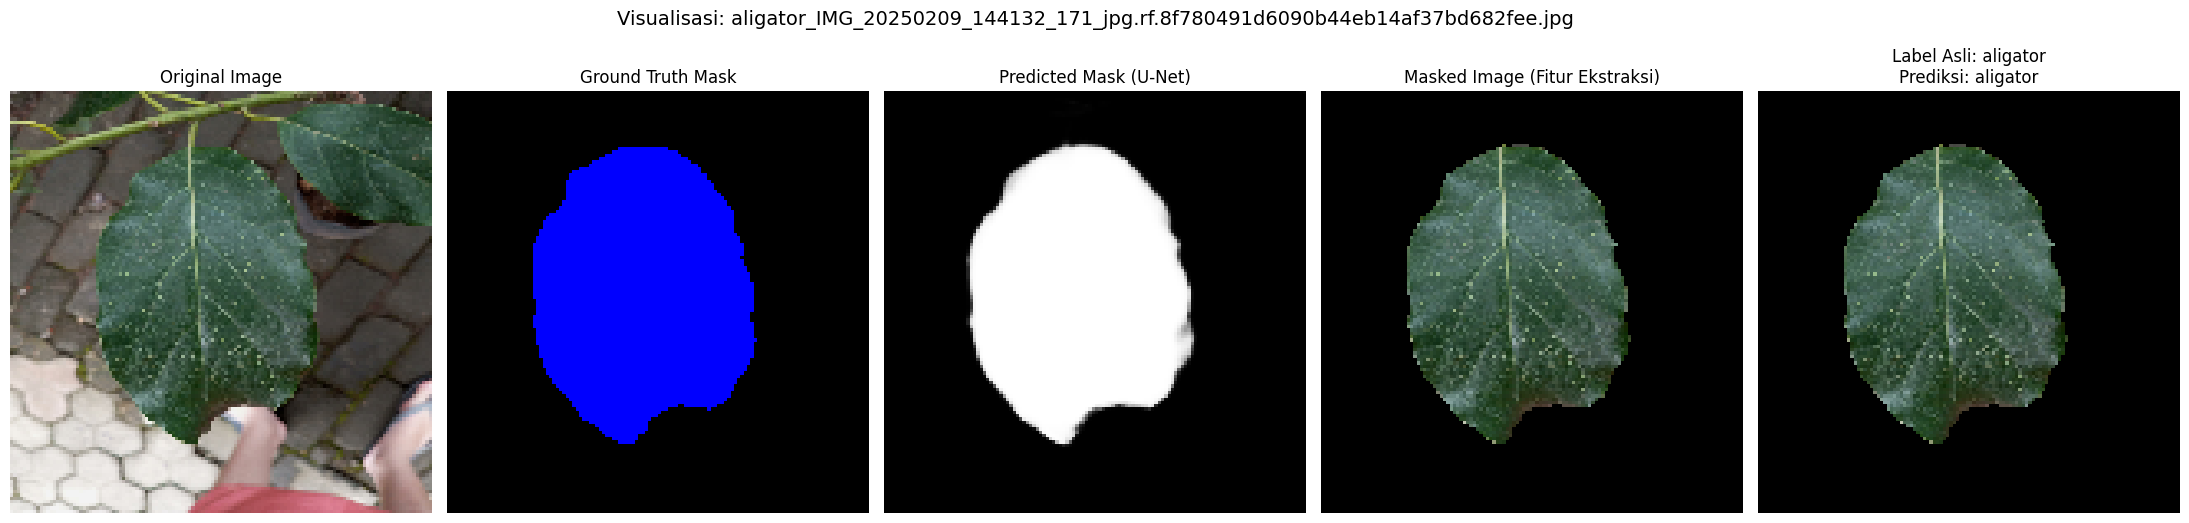

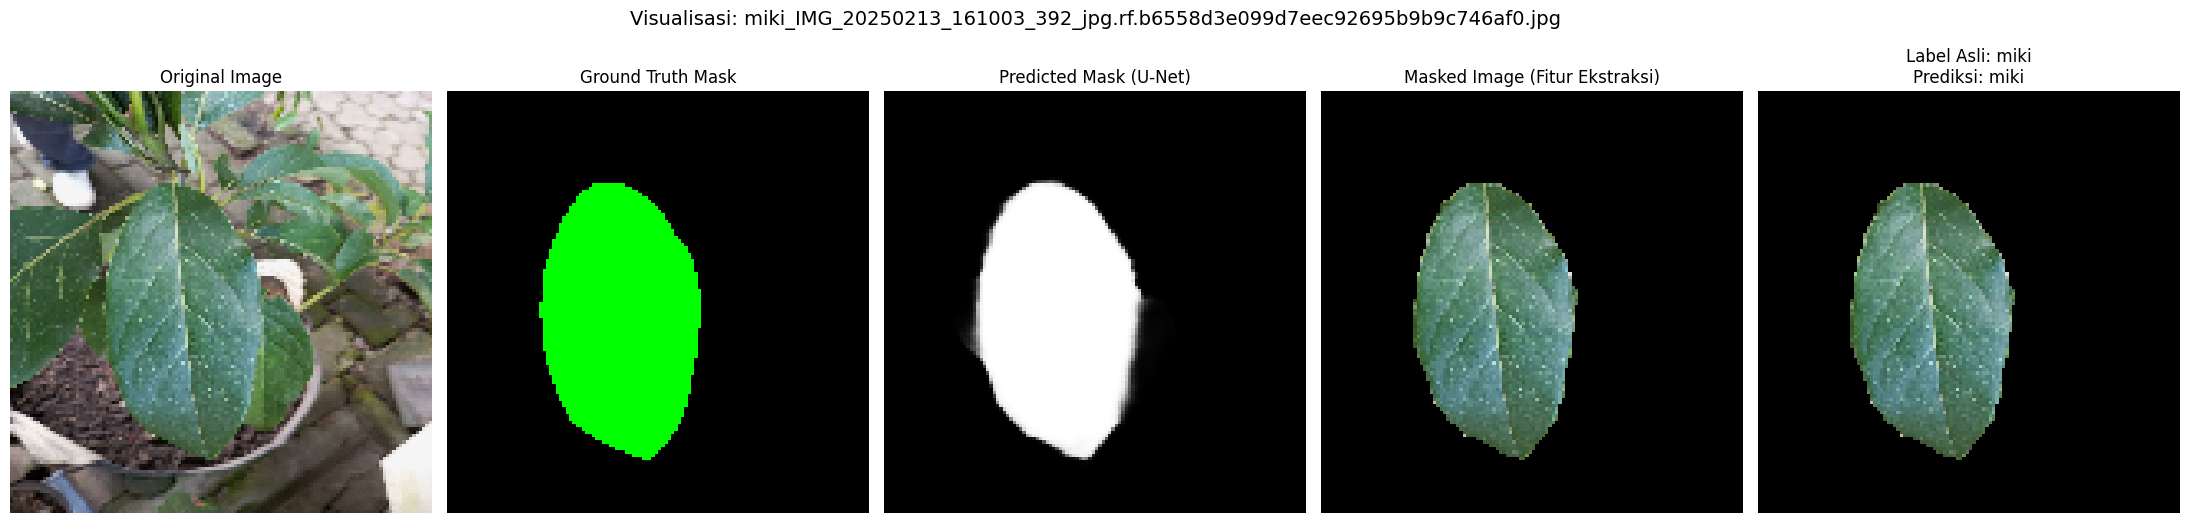

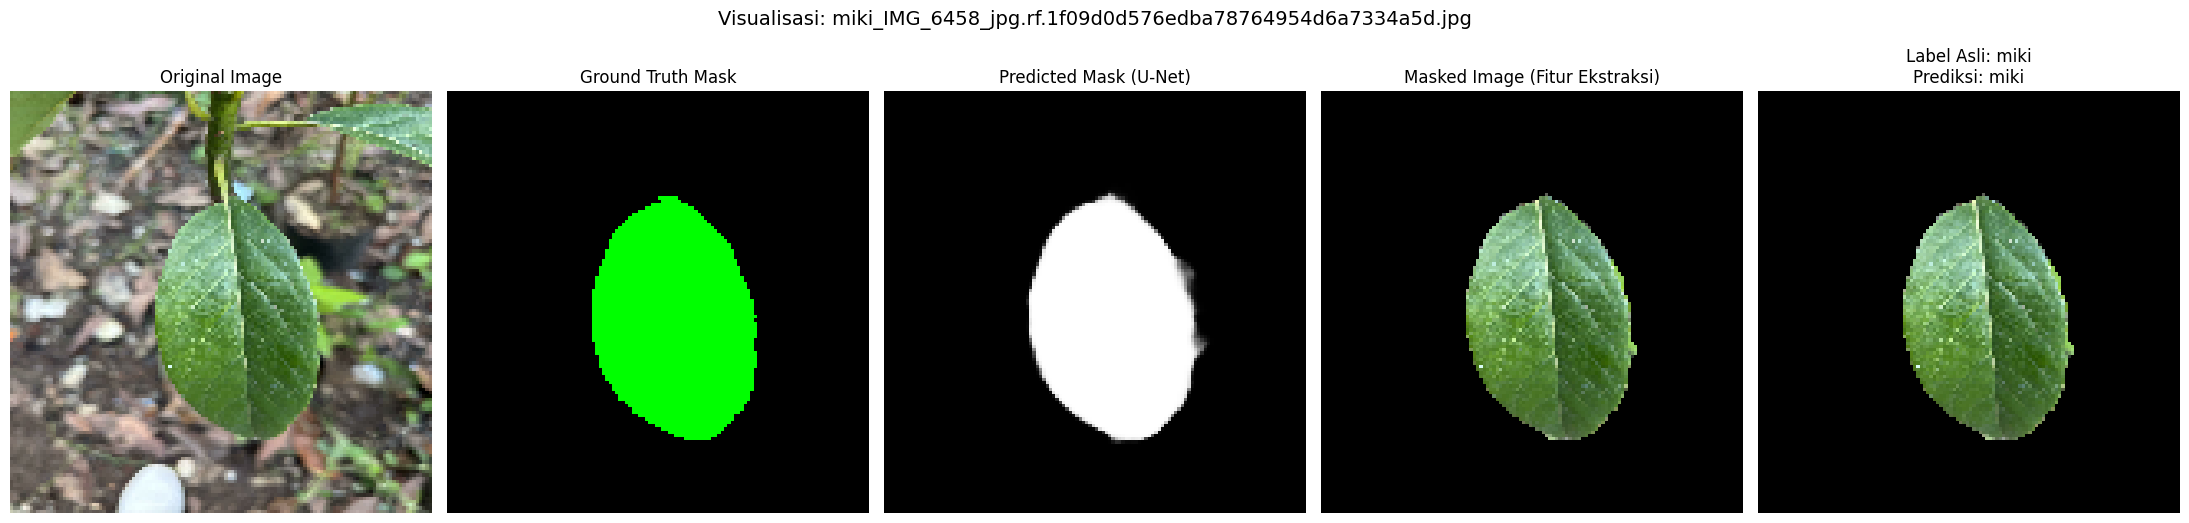

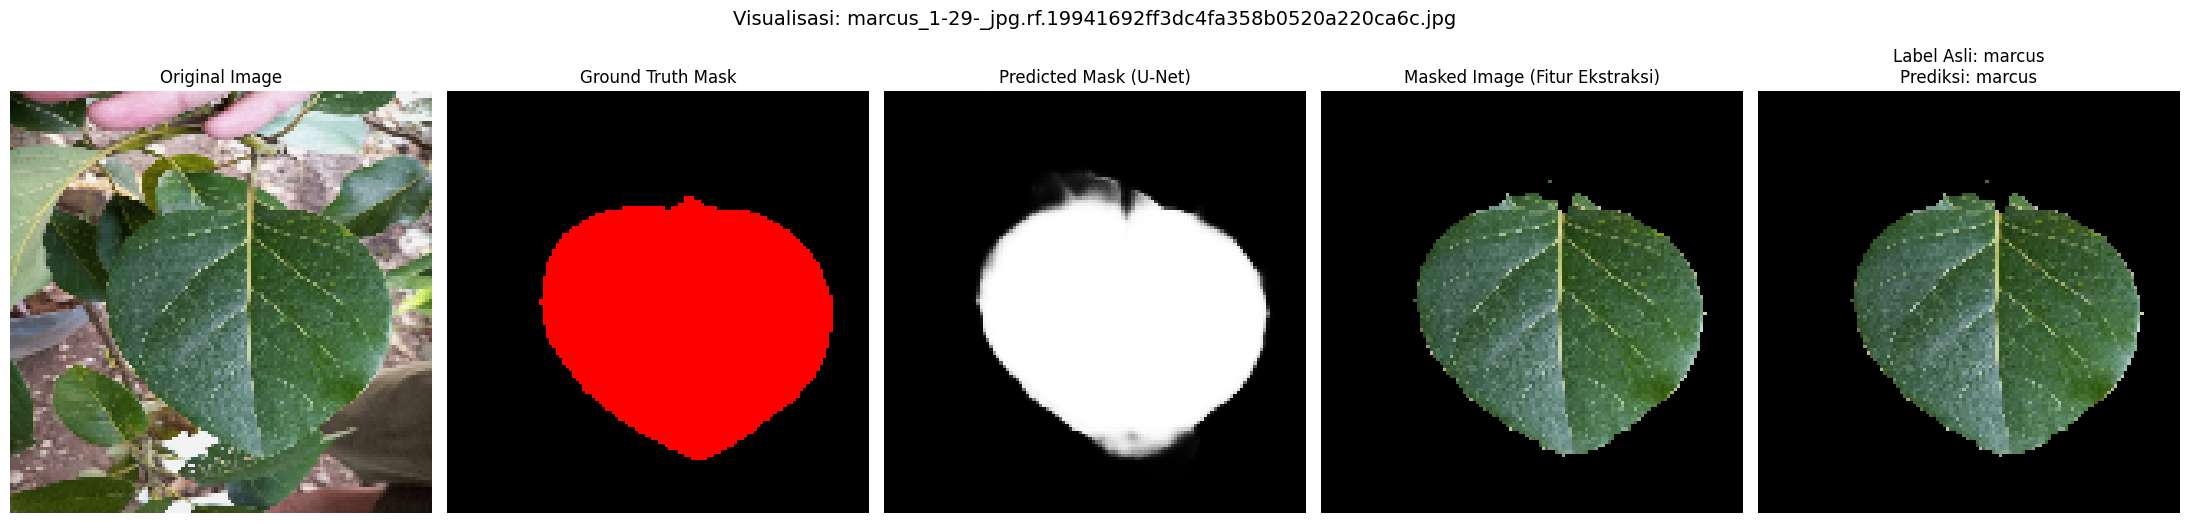

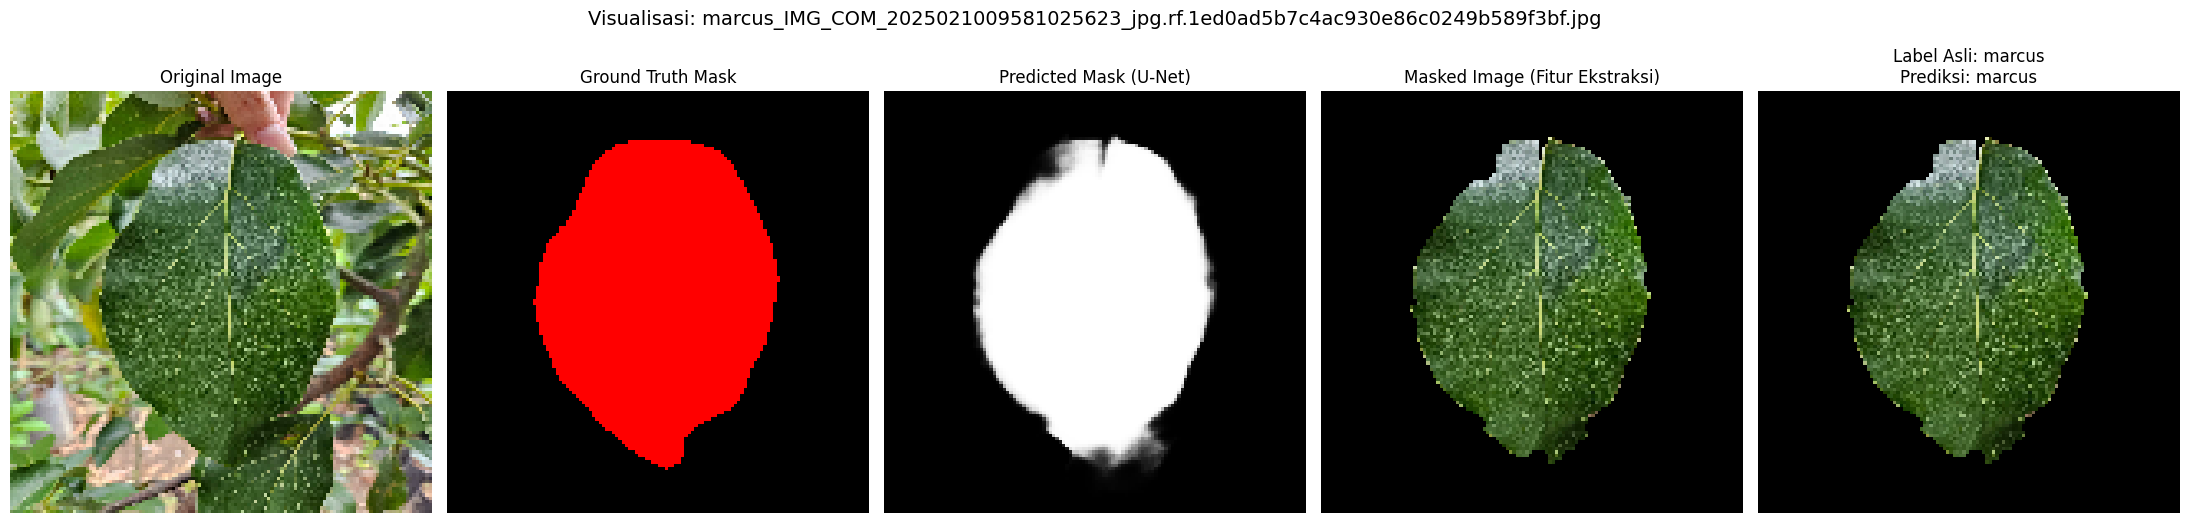

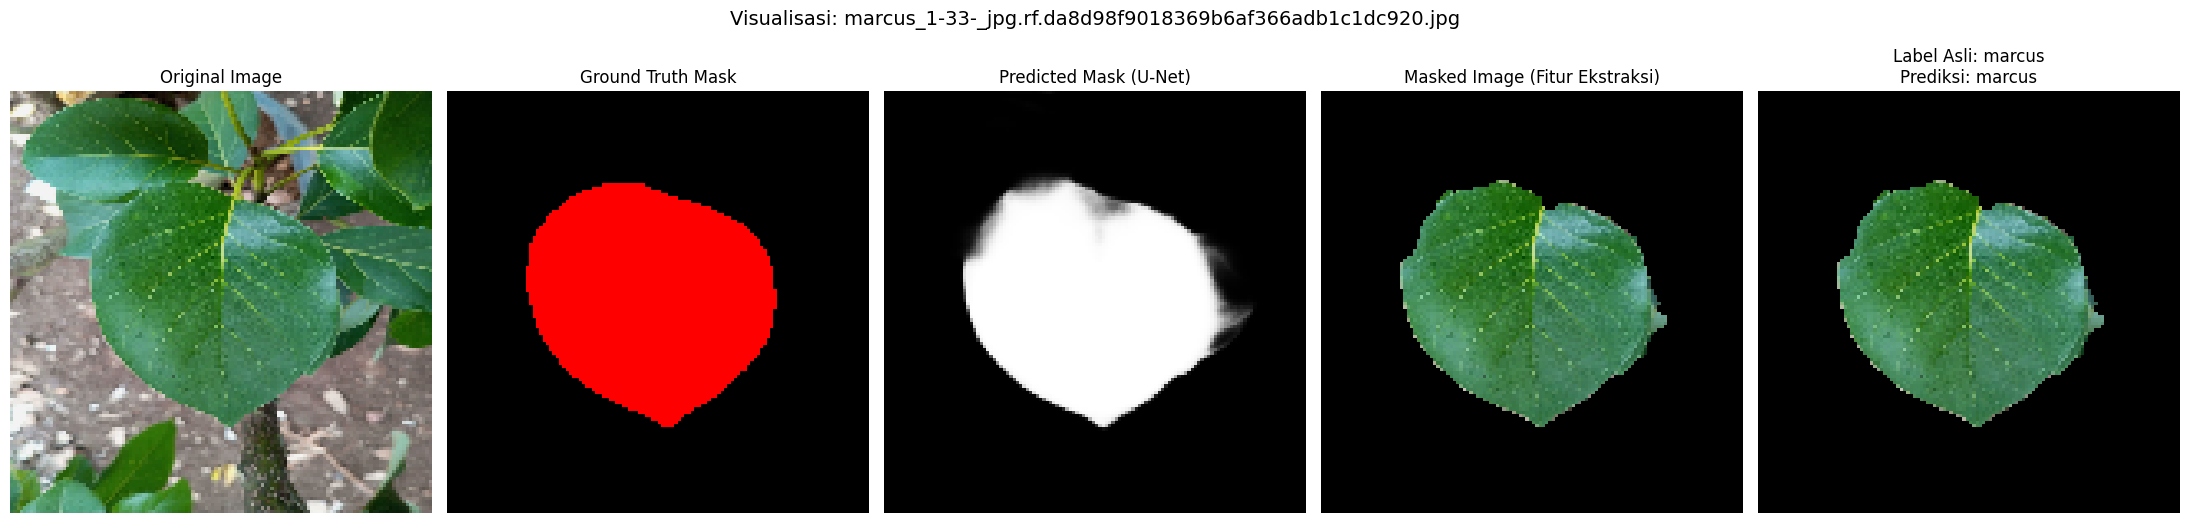

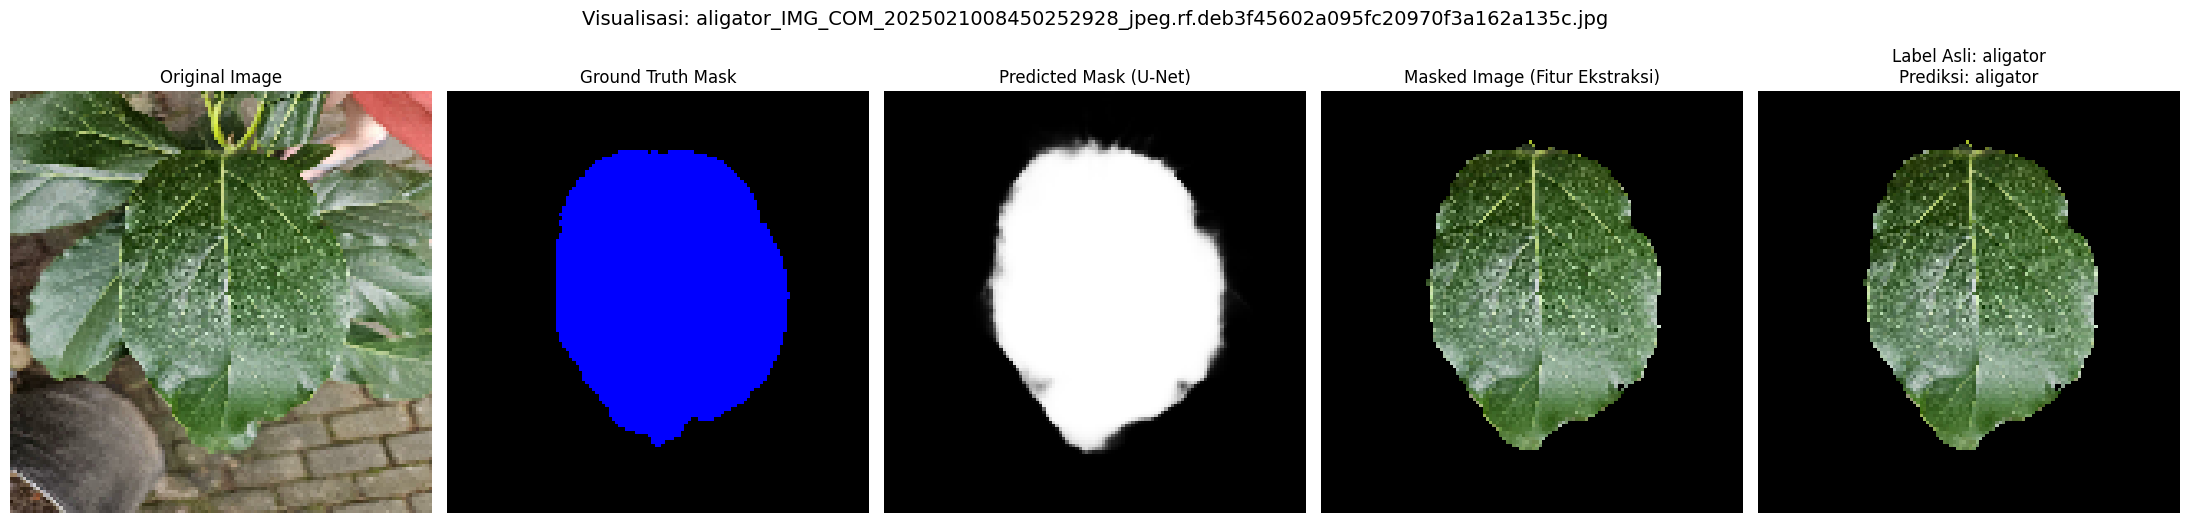

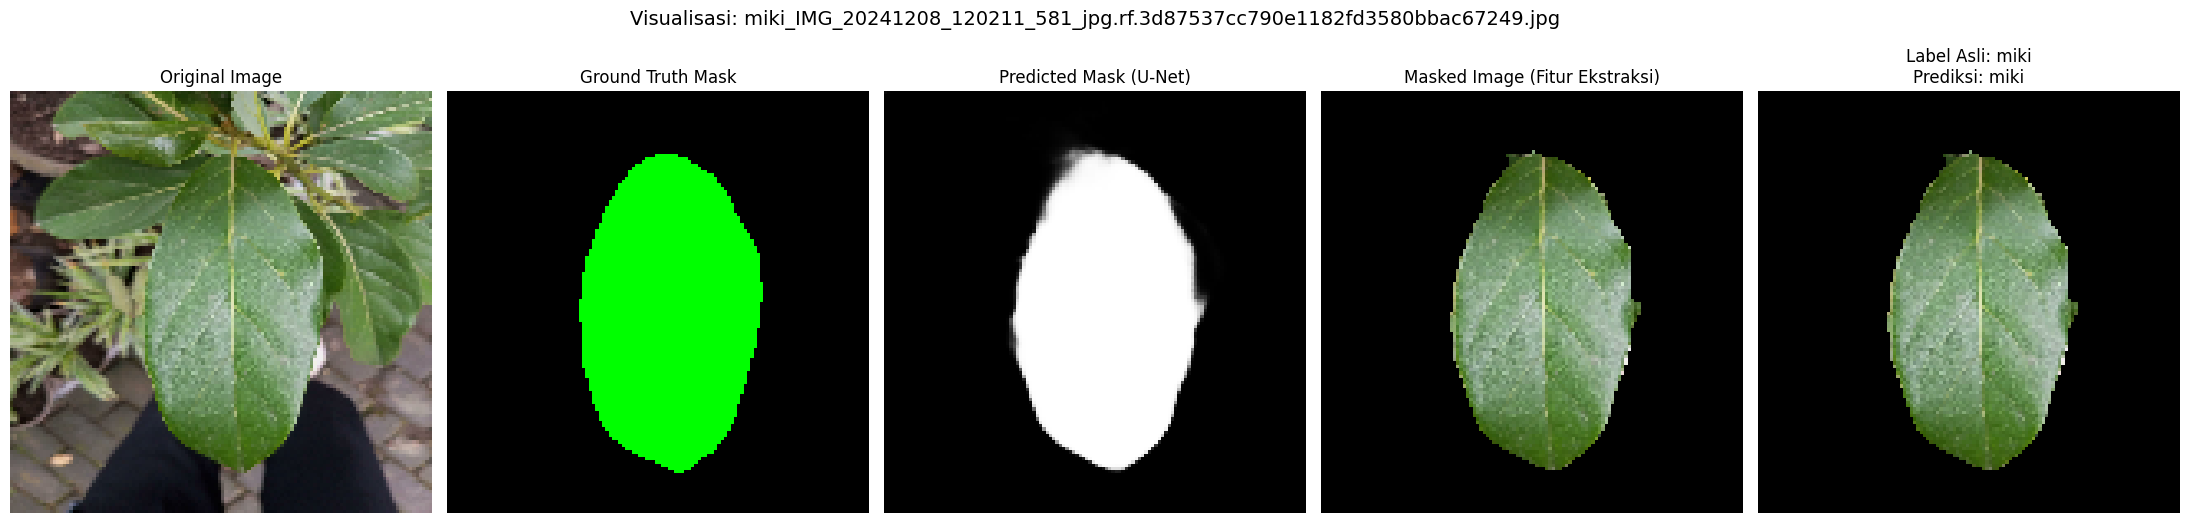

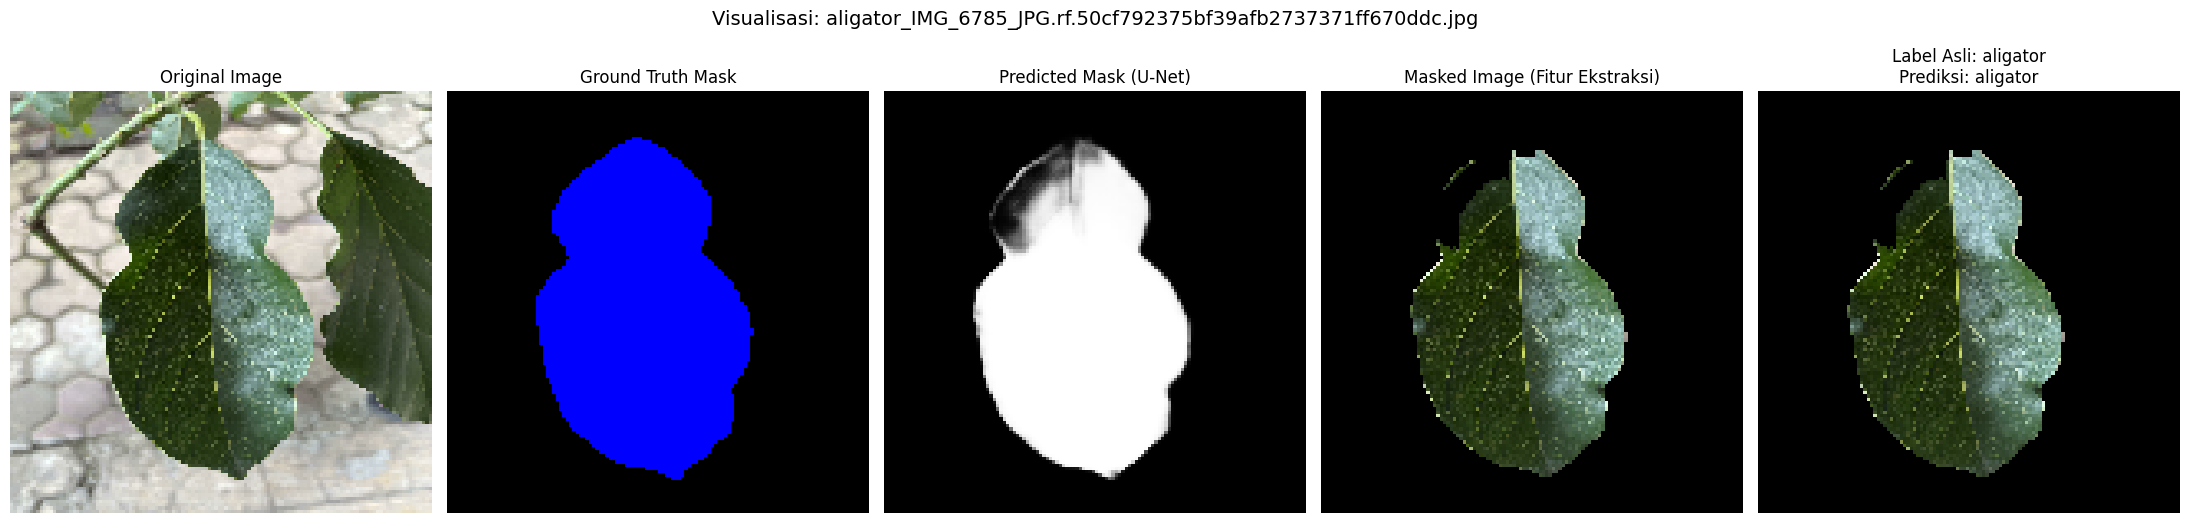

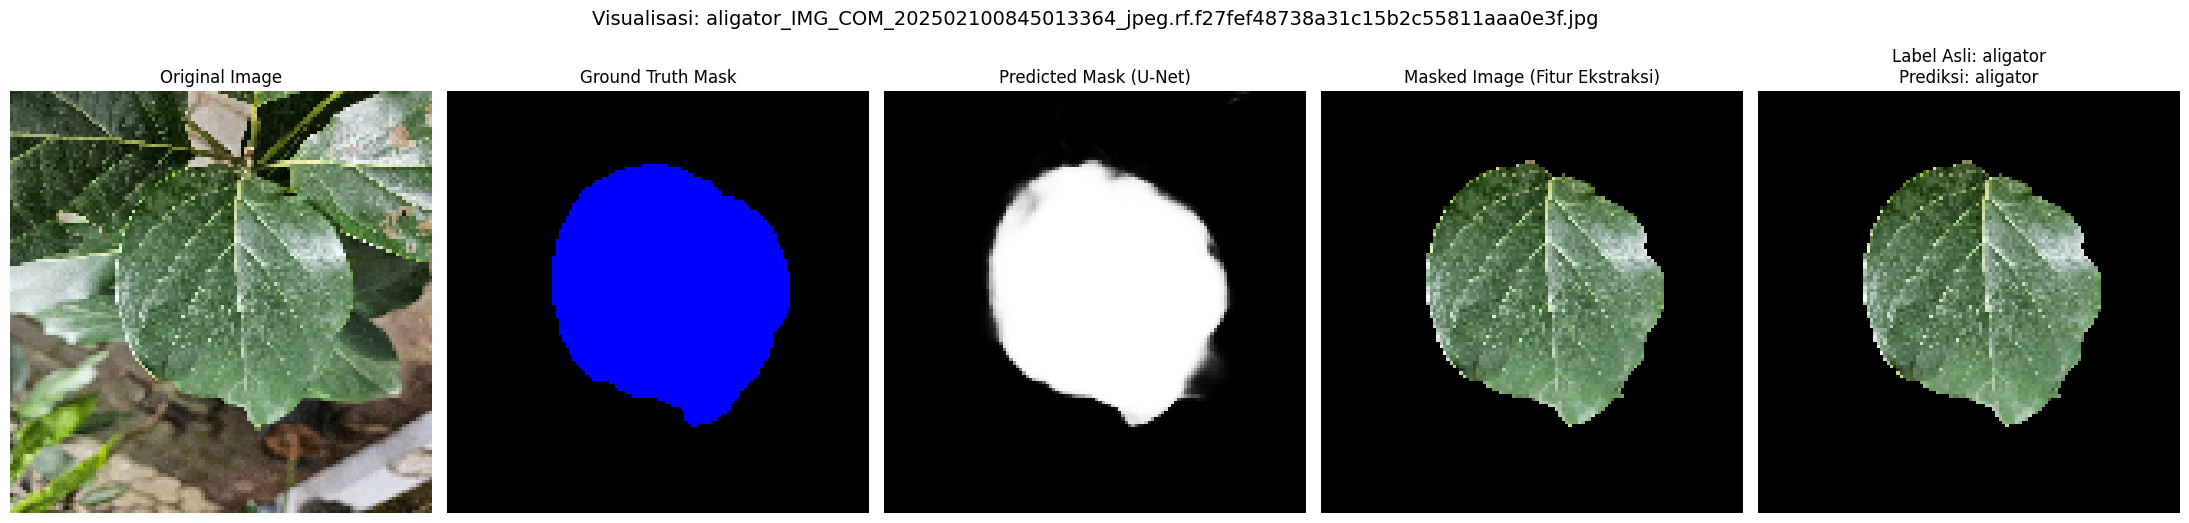

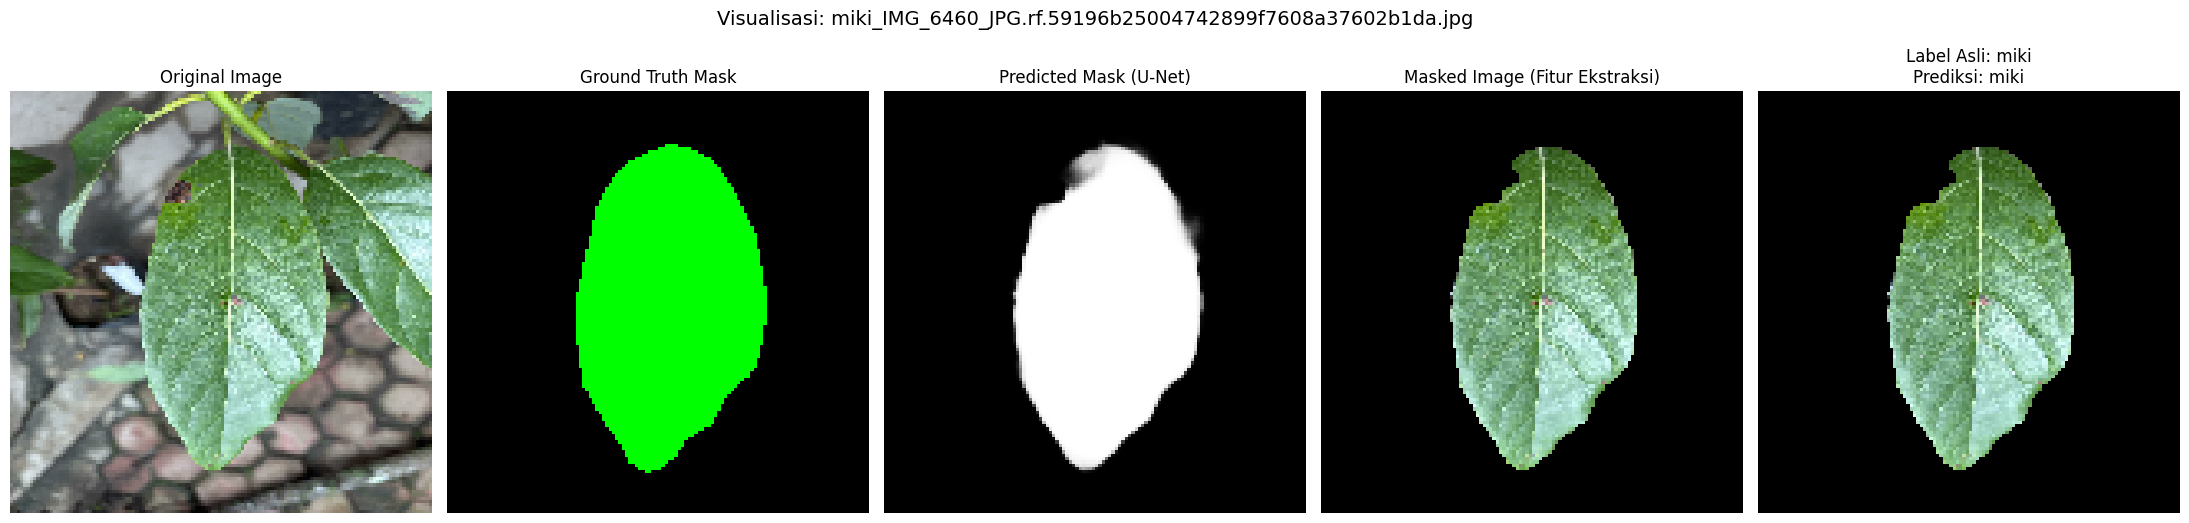

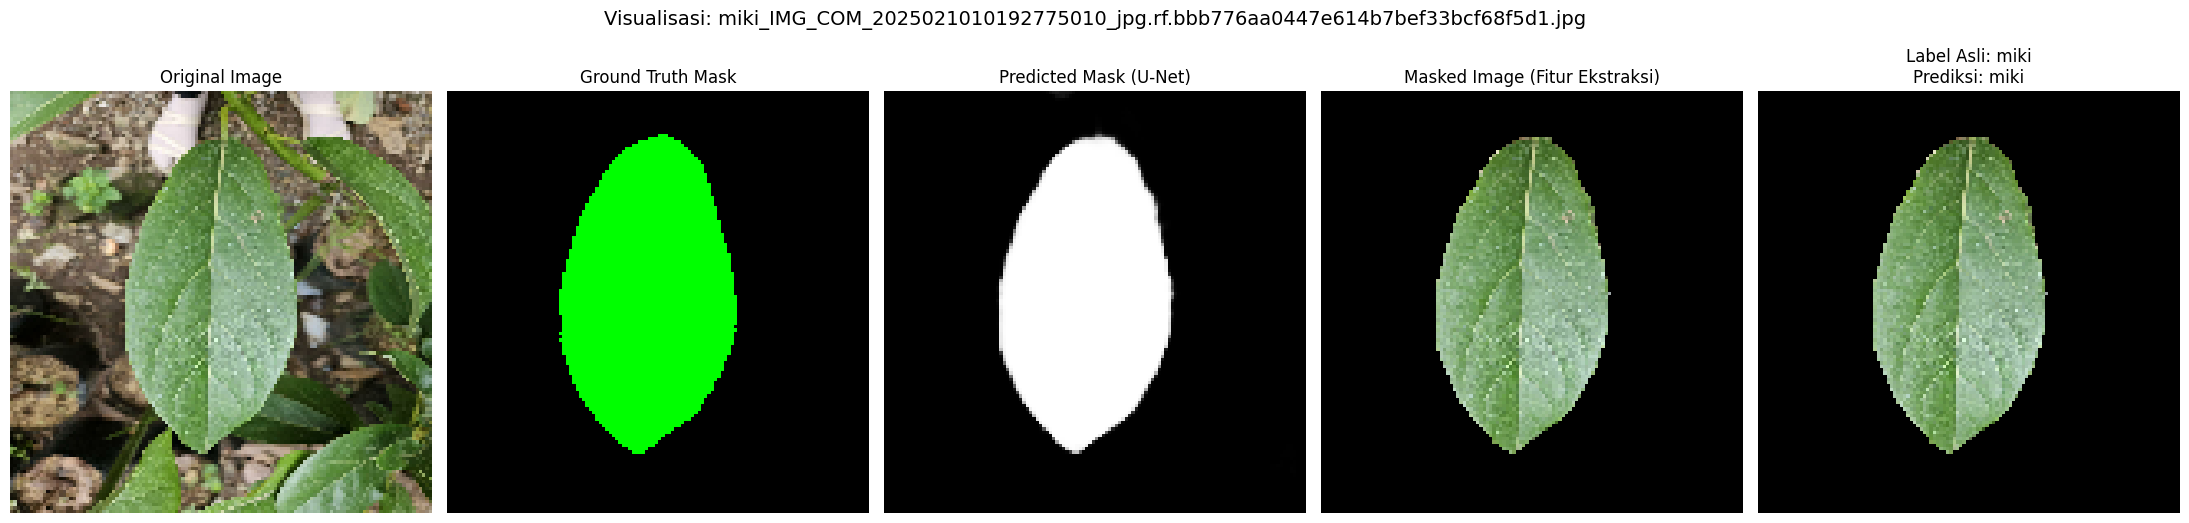

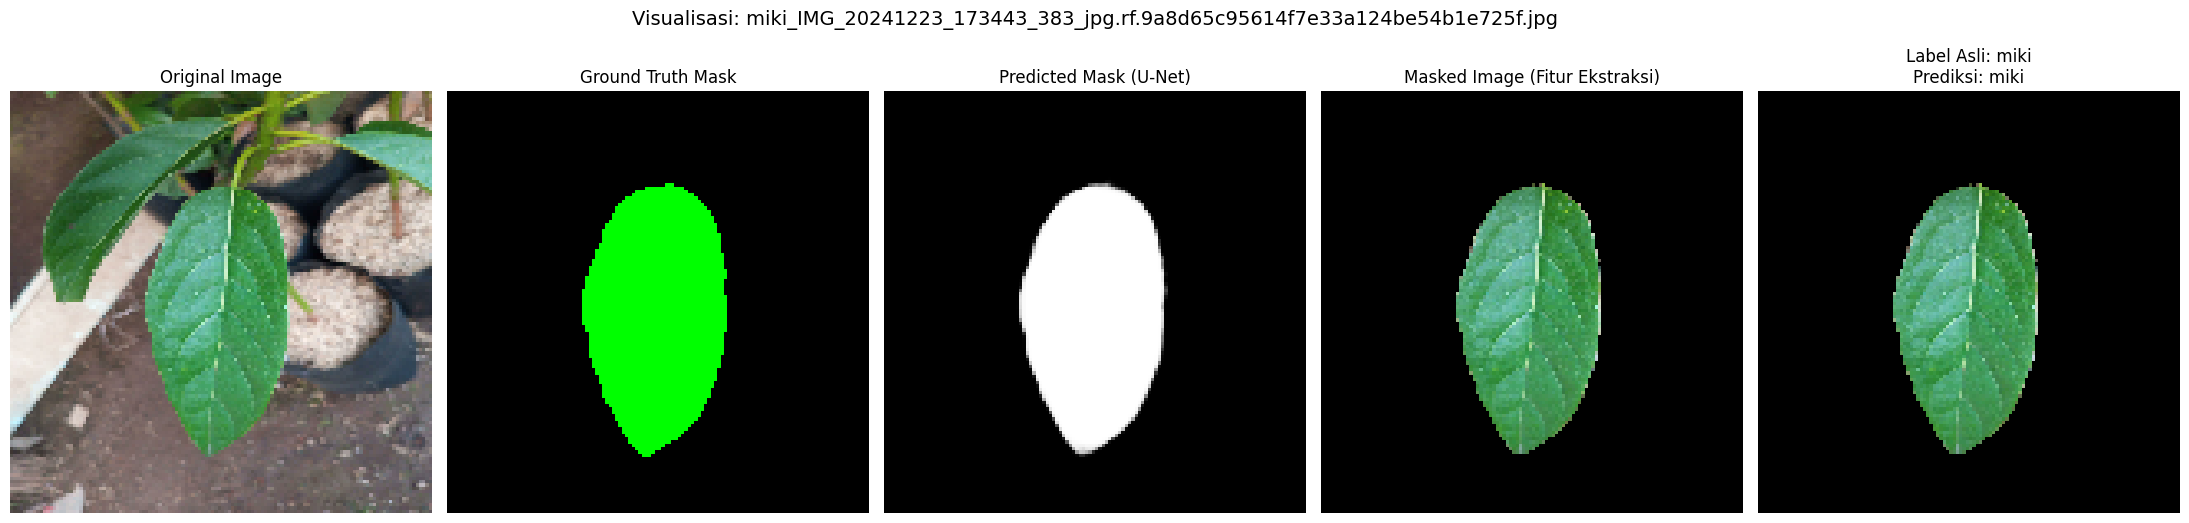

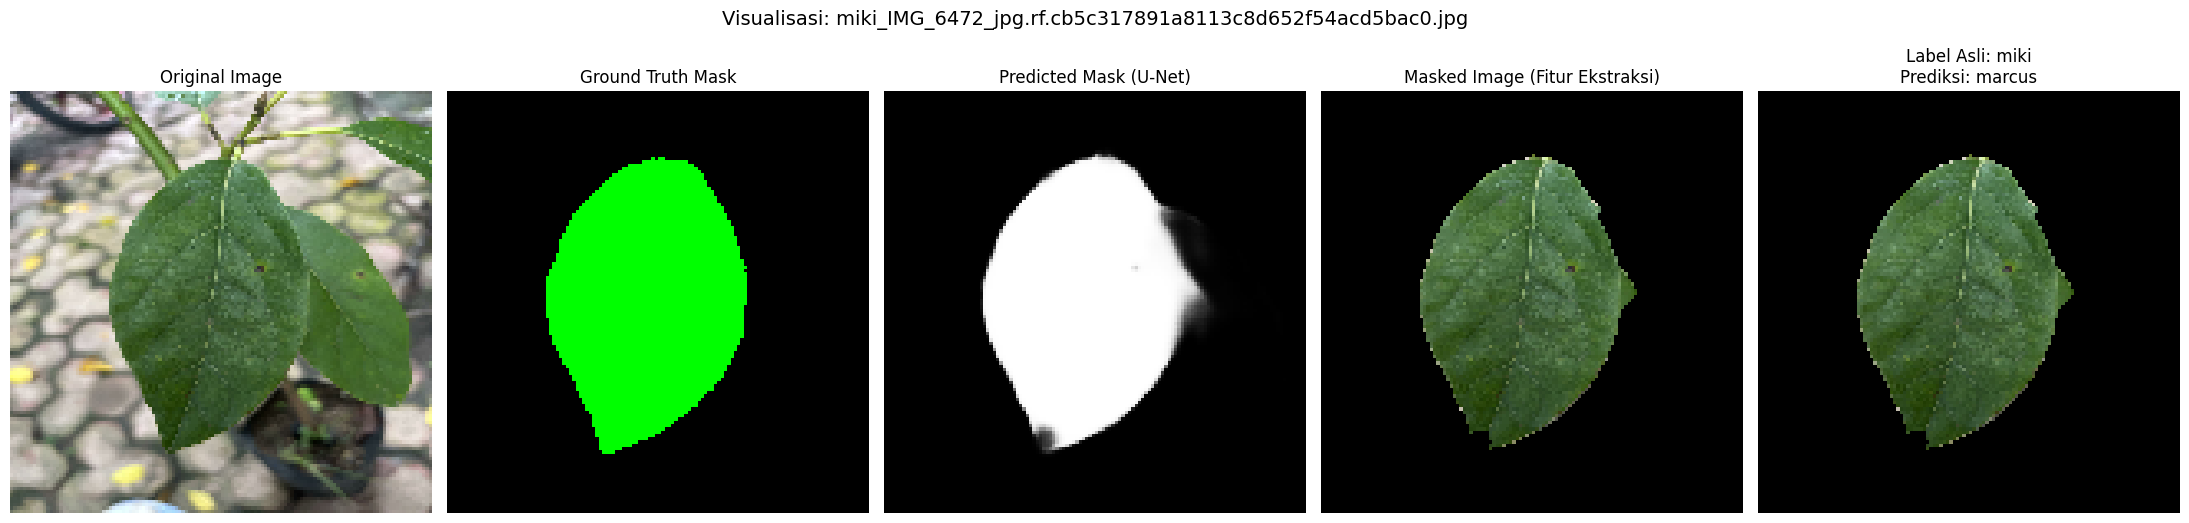

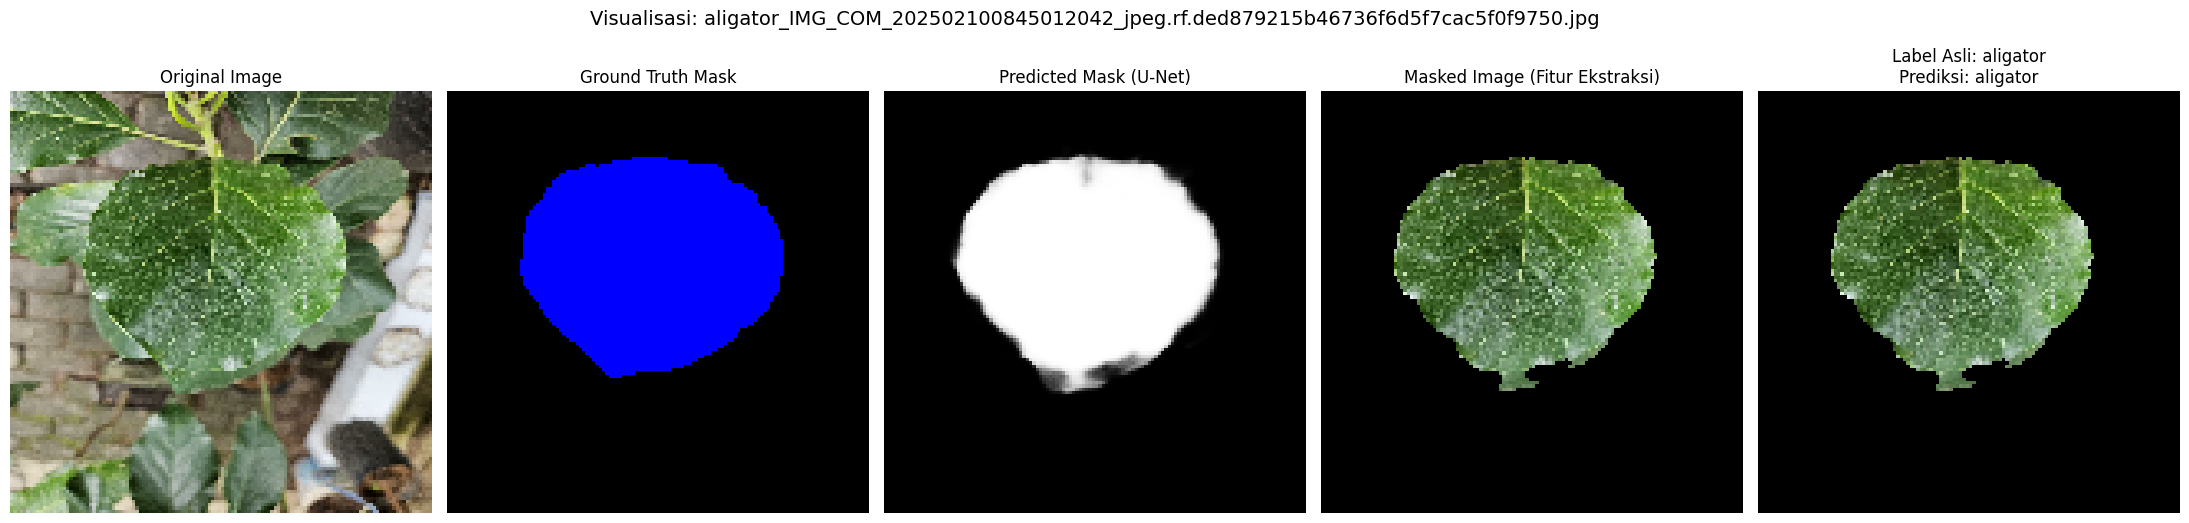

In [ ]:
# # Cetak warna untuk setiap jenis daun tanpa menampilkan RGB
# mapping = {
#     "marcus": "merah",
#     "miki": "hijau",
#     "aligator": "biru"
# }

# print("Daftar warna ground truth untuk setiap jenis daun:")
# for label, warna in mapping.items():
#     print(f"- {label}: {warna}")


# visualize_all_test_images(
#     test_image_paths,
#     test_mask_paths,
#     test_labels,
#     unet_model,
#     clf_model,
#     label_map,
#     max_visualize=25  # Ganti jumlah yang ingin divisualisasikan
# )